In [1]:
library(NormqPCR)
library(pheatmap)
library(readxl)
library(plotrix)

Loading required package: RColorBrewer

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: ReadqPCR

Loading required package: qpcR

Loading required package: MASS

Loadi

In [2]:
######################################## 
### FUNCTION FOR RLE-PLOT AND RUV_total
########################################

RLEplot_mod <- function(data,pdata_group){
  
Color_Batches <- c('purple','orange','brown','blue','darkgreen','pink','gray','red','black','green','navy','Violet')
par(mar = c(6.5,6.5,2.3,0))
boxplot(data - rowMedians(data), main = '', xlab ='', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1,4.1),xlim=c(0,50),
        outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
        staplelwd = 0 , boxcol = Color_Batches[factor(pdata_group)],
        border = Color_Batches[factor(pdata_group)], col = 'gray87')
box(lwd = 7, bty = 'l')
title('RLE plot', line = -2, cex.main = 3.5)
Median_Nano <- apply(data - rowMedians(data), 2, median)
points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
axis(2, mgp = c(3.5, .9 ,0), lwd.ticks=6, las=1, cex.axis=3)
mtext('RLE', 2, line = 3.5, cex = 3.5)
abline(h = 0, col = 'black', lwd = 5, lty = 2)
par(lwd = 3)
axis.break(2, -4.2, style = 'zigzag', brw = .02)
x_labs <- levels(factor(colnames(data)))

text(x = seq_along(x_labs), y = -4.5, labels = x_labs, 
     srt = 90,    # rotate
     adj = 1,    # justify
     xpd = TRUE)    # plot in margin

legend(36, 4.1, legend = unique(factor(pdata_group)),
       col = unique(Color_Batches[factor(pdata_group)]),
       pch = 15, bty = 'n', cex = 1)
text(x = 40, y = 4.2 ,labels  = 'Run', cex = 1.5)

}

In [3]:
##### FUNCTION FOR RUVg  ### Bhattacharia et. al. 

RUV_total <- function(raw,pData,fData,k,hkgenes = NULL,exclude = NULL){
  
  library(RUVSeq)
  library(DESeq2)
  library(limma)
  library(matrixStats)
  
  if (!is.null(hkgenes)){
    
    fData(set)$CodeClass[rownames(set) %in% hkgenes] = 'Housekeeping'
    
  }
  
  
  fData = fData[rownames(raw),]
  int = intersect(rownames(raw),rownames(fData))
  fData = fData[int,]
  raw = raw[int,]
  
  set <- newSeqExpressionSet(as.matrix(round(raw)),
                             phenoData=pData,
                             featureData=fData)
  
  cIdx <- rownames(set)[fData(set)$`Class Name` == "Housekeeping"]
  cIdx = cIdx[!(cIdx %in% exclude)]
  x <- as.factor(pData$Group)
  set <- betweenLaneNormalization(set, which="upper")
  set <- RUVg(set, cIdx, k=k)
  dds <- DESeqDataSetFromMatrix(counts(set),colData=pData(set),design=~1)
  rowData(dds) <- fData
  dds <- estimateSizeFactors(dds)
  dds <- estimateDispersionsGeneEst(dds)
  cts <- counts(dds, normalized=TRUE)
  disp <- pmax((rowVars(cts) - rowMeans(cts)),0)/rowMeans(cts)^2
  mcols(dds)$dispGeneEst <- disp
  dds <- estimateDispersionsFit(dds, fitType="mean")
  vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
  mat <- assay(vsd)
  covars <- as.matrix(colData(dds)[,grep("W",colnames(colData(dds))),drop=FALSE])
#   mat_has_na = count(is.na(mat))
#   covar_has_na = count(is.na(covars))
#   if (mat_has_na > 0) {
#       print('mat has na values')
#   }
#   if (covar_has_na > 0) {
#       print('covar has na values')
#       print(covars)
#   }
  
  mat <- removeBatchEffect(mat, covariates=covars)
  assay(vsd) <- mat
  return(list(set = set,vsd = vsd))
  
}

In [4]:
RLEplot_mod <- function(data, pdata_group) {
  
  Color_Batches <- c('purple', 'orange', 'brown', 'blue', 'darkgreen', 'pink', 'gray', 'red', 'black', 'green', 'navy', 'Violet')
  
  par(mar = c(6.5, 6.5, 2.3, 2.3))  # Adjust the margin parameters
  par(plt = c(0.1, 0.9, 0.1, 0.9))  # Adjust the plot area parameters
  boxplot(data - rowMedians(data), main = '', xlab = '', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1, 4.1), xlim = c(0, 50),
          outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
          staplelwd = 0, boxcol = Color_Batches[factor(pdata_group)],
          border = Color_Batches[factor(pdata_group)], col = 'gray87')
  box(lwd = 7, bty = 'l')
  title('RLE plot', line = -2, cex.main = 3.5)
  Median_Nano <- apply(data - rowMedians(data), 2, median)
  points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
  axis(2, mgp = c(3.5, .9, 0), lwd.ticks = 6, las = 1, cex.axis = 3)
  mtext('RLE', 2, line = 3.5, cex = 3.5)
  abline(h = 0, col = 'black', lwd = 5, lty = 2)
  par(lwd = 3)
  axis.break(2, -4.2, style = 'zigzag', brw = .02)
  x_labs <- levels(factor(colnames(data)))
  text(x = seq_along(x_labs), y = -4.5, labels = x_labs,
       srt = 90,    # rotate
       adj = 1,    # justify
       xpd = TRUE)    # plot in margin
  
  legend(36, 4.1, legend = unique(factor(pdata_group)),
         col = unique(Color_Batches[factor(pdata_group)]),
         pch = 15, bty = 'n', cex = 1)
  text(x = 40, y = 4.2, labels = 'Run', cex = 1.5)
  
}

In [5]:
raw = read.csv('Data/raw_count_transponsed_raw.csv', row.names = 1, check.names = F )
norm_count = read.csv('Data/raw_count.csv', row.names = 1, check.names = F)
# sample annotations:
# annot = read.csv('Data/annot_3.csv', row.names = 1, check.names = F )
annot = read.csv('Data/annot_clinical.csv', row.names = 1, check.names = F )
# annot = read.csv('Data/annot_clinical_2.csv', row.names = 1, check.names = F )

# gene annotations:
gannot = read.csv('Data/gannot_raw.csv', row.names = 1, check.names = F )
old_gannot=read.csv('Data/gannot.csv', row.names = 1, check.names = F)
clin = read.csv('Data/annot.csv', row.names = 1, check.names = F )

In [6]:
raw_expression <- raw
print(dim(raw_expression))
raw_expression

[1] 784  48


20230616_210462891024_K1241-B_02.RCC
A2M      45                                 
ABCB1     6                                 
ABL1     16                                 
ADA      12                                 
ADORA2A   3                                 
AICDA     7                                 
AIRE     12                                 
AKT3     64                                 
ALCAM    12                                 
AMBP      4                                 
AMICA1    8                                 
ANP32B   49                                 
ANXA1   234                                 
APOE     25                                 
APP     246                                 
ARG1      1                                 
ARG2      7                                 
ATF1     16                                 
ATF2      6                                 
ATG10     8                                 
ATG12     5                                 
ATG16L1   8                                 
ATG5      5                                 
ATG7      2                                 
ATM       3                                 
AXL      50                                 
BAGE      4                                 
BATF      2                                 
BAX      19                                 
BCL10    33                                 
⋮       ⋮                                   
POLR2A     21                               
PPIA        6                               
PRPF38A    16                               
SAP130     17                               
SDHA        6                               
SF3A3     211                               
TBP        13                               
TLK2        9                               
TMUB2       6                               
TRIM39      8                               
TUBB       61                               
USP39       6                               
ZC3H14     71                               
ZKSCAN5     8                               
ZNF143      8                               
ZNF346      3                               
NEG_A      11                               
NEG_B      15                               
NEG_C       6                               
NEG_D       1                               
NEG_E      16                               
NEG_F      17                               
NEG_G       3                               
NEG_H       5                               
POS_A   24074                               
POS_B    7964                               
POS_C    2175                               
POS_D     462                               
POS_E      96                               
POS_F      59                               
        20230616_210462891024_K1628-B_03.RCC
A2M     20742                               
ABCB1     161                               
ABL1     1557                               
ADA        70                               
ADORA2A    27                               
AICDA      10                               
AIRE       10                               
AKT3     4438                               
ALCAM    1637                               
AMBP        3                               
AMICA1    259                               
ANP32B   1166                               
ANXA1    4739                               
APOE      235                               
APP      1895                               
ARG1        8                               
ARG2      165                               
ATF1      207                               
ATF2      301                               
ATG10     216                               
ATG12      31                               
ATG16L1   167                               
ATG5      440                               
ATG7      119                               
ATM        15                               
AXL      2619                               
BAG

In [7]:
fData=gannot
head(fData)

Class Name   % Samples above Threshold
A2M     Endogenous   100                      
ABCB1   Endogenous   100                      
ABCF1   Housekeeping 100                      
ABL1    Endogenous   100                      
ADA     Endogenous   100                      
ADORA2A Endogenous   100                      
        Immune Response Category           Accession   Common Name
A2M     Chemokines                         NM_000014.4 A2M        
ABCB1                                      NM_000927.3 ABCB1      
ABCF1                                      NM_001090.2 ABCF1      
ABL1    Cell Cycle, Regulation, Senescence NM_005157.3 ABL        
ADA     B-Cell Functions, T-Cell Functions NM_000022.2 ADA        
ADORA2A Cell Functions                     NM_000675.3 ADORA2A    
        Gene_Class                  
A2M     Immune Response             
ABCB1   Immune Response             
ABCF1   HK                          
ABL1    Immune Response             
ADA     Immune Response             
ADORA2A Immune Response - Checkpoint

In [8]:
pData <- annot
pData

Conditions           Diagnosis  pid  
20230616_210462891024_K1241-B_02.RCC  Soft Tissue Sarcoma   Baseline  K1241
20230707_210462871024_K1241-Tx_09.RCC Soft Tissue Sarcoma   Treatment K1241
20230616_210462891024_K1628-B_03.RCC  Soft Tissue Sarcoma   Baseline  K1628
20230707_210462871024_K1628-Tx_10.RCC Soft Tissue Sarcoma   Treatment K1628
20230616_210462891024_K1865-B_04.RCC  Osteosarcoma          Baseline  K1865
20230616_210462891024_K2032-B_05.RCC  Soft Tissue Sarcoma   Baseline  K2032
20230707_210462871024_K2032-Tx_11.RCC Soft Tissue Sarcoma   Treatment K2032
20230616_210462891024_K2068-B_06.RCC  Soft Tissue Sarcoma   Baseline  K2068
20230616_210462891024_K2323-B_07.RCC  Soft Tissue Sarcoma   Baseline  K2323
20230616_210462891024_K2360-B_08.RCC  Soft Tissue Sarcoma   Baseline  K2360
20230707_210462871024_K2360-Tx_12.RCC Soft Tissue Sarcoma   Treatment K2360
20230616_210462891024_K2520-B_09.RCC  Soft Tissue Sarcoma   Baseline  K2520
20230616_210462891024_K2669-B_10.RCC  Soft Tissue Sarcoma   Baseline  K2669
20230616_210462891024_K2742-B_11.RCC  Soft Tissue Sarcoma   Baseline  K2742
20230707_210462901024_K2742-Tx_01.RCC Soft Tissue Sarcoma   Treatment K2742
20230616_210462891024_K2849-B_12.RCC  Osteosarcoma          Baseline  K2849
20230707_210462901024_K2849-Tx_02.RCC Osteosarcoma          Treatment K2849
20230616_210462891024_K853-B_01.RCC   Osteosarcoma          Baseline  K853 
20230707_210462871024_K853-Tx_08.RCC  Osteosarcoma          Treatment K853 
20230707_210462871024_K4106-B_01.RCC  Osteosarcoma          Baseline  K4106
20230707_210462901024_K4106-Tx_09.RCC Osteosarcoma          Treatment K4106
20230707_210462871024_K4196-B_02.RCC  Osteosarcoma          Baseline  K4196
20230707_210462871024_K4258-B_03.RCC  Osteosarcoma          Baseline  K4258
20230707_210462901024_K4258-Tx_10.RCC Osteosarcoma          Treatment K4258
20230707_210462871024_K4307-B_04.RCC  Osteosarcoma          Baseline  K4307
20230707_210462871024_K4360-B_05.RCC  Osteosarcoma          Baseline  K4360
20230707_210462901024_K4360-Tx_11.RCC Osteosarcoma          Treatment K4360
20230707_210462871024_K4368-B_06.RCC  Soft Tissue Sarcoma   Baseline  K4368
20230707_210462901024_K4368-Tx_12.RCC Soft Tissue Sarcoma   Treatment K4368
20230707_210462871024_K5046-B_07.RCC  Osteosarcoma          Baseline  K5046
20230707_210462881024_K2894-B_01.RCC  Osteosarcoma          Baseline  K2894
20230707_210462901024_K2894-Tx_03.RCC Osteosarcoma          Treatment K2894
20230707_210462881024_K2917-B_02.RCC  Soft Tissue Sarcoma   Baseline  K2917
20230707_210462901024_K2917-Tx_04.RCC Soft Tissue Sarcoma   Treatment K2917
20230707_210462881024_K3056-B_03.RCC  Osteosarcoma          Baseline  K3056
20230707_210462901024_K3056-Tx_05.RCC Osteosarcoma          Treatment K3056
20230707_210462881024_K3566-B_04.RCC  Soft Tissue Sarcoma   Baseline  K3566
20230707_210462901024_K3566-Tx_06.RCC Soft Tissue Sarcoma   Treatment K3566
20230707_210462881024_K3812-B_05.RCC  Soft Tissue Sarcoma   Baseline  K3812
20230707_210462881024_K3953-B_06.RCC  Soft Tissue Sarcoma   Baseline  K3953
20230707_210462901024_K3953-Tx_07.RCC Soft Tissue Sarcoma   Treatment K3953
20230707_210462881024_K3975-B_07.RCC  Osteosarcoma          Baseline  K3975
20230707_210462901024_K3975-Tx_08.RCC Osteosarcoma          Treatment K3975
20230707_210462881024_K4010-B_08.RCC  Osteosarcoma          Baseline  K4010
20230707_210462881024_K4020-B_09.RCC  Osteosarcoma          Baseline  K4020
20230707_210462881024_K4023-B_10.RCC  Osteosarcoma          Baseline  K4023
20230707_210462881024_K4054-B_11.RCC  Osteosarcoma          Baseline  K4054
20230707_210462881024_K4093-B_12.RCC  Soft Tissue Sarcoma   Baseline  K4093
                                      Is_matched Subject_ID RECIST_response
20230616_210462891024_K1241-B_02.RCC  True       TI0045     SD             
20230707_210462871024_K1241-Tx_09.RCC True       TI0045     SD             
20230616_210462891024_K1628-B_03.RCC  True       TI0036     PD             
20230707_2

In [9]:
fData$IsControl = fData$`Class Name`!='Endogenous'
# fData

In [10]:
l1 = row.names(fData[fData$`Class Name`=='Negative',])
l2 = row.names(fData[fData$`Class Name`=='Positive',])

In [11]:
exclude= c(l1, l2)
exclude

[1] "NEG_A" "NEG_B" "NEG_C" "NEG_D" "NEG_E" "NEG_F" "NEG_G" "NEG_H" "POS_A"
[10] "POS_B" "POS_C" "POS_D" "POS_E" "POS_F"

In [12]:
cIdx <- rownames(raw_expression)
cIdx = cIdx[!(cIdx %in% exclude)]

In [13]:
raw_expression_ex = raw_expression[cIdx,]
print(dim(raw_expression_ex))
raw_expression_ex

[1] 770  48


20230616_210462891024_K1241-B_02.RCC
A2M      45                                 
ABCB1     6                                 
ABL1     16                                 
ADA      12                                 
ADORA2A   3                                 
AICDA     7                                 
AIRE     12                                 
AKT3     64                                 
ALCAM    12                                 
AMBP      4                                 
AMICA1    8                                 
ANP32B   49                                 
ANXA1   234                                 
APOE     25                                 
APP     246                                 
ARG1      1                                 
ARG2      7                                 
ATF1     16                                 
ATF2      6                                 
ATG10     8                                 
ATG12     5                                 
ATG16L1   8                                 
ATG5      5                                 
ATG7      2                                 
ATM       3                                 
AXL      50                                 
BAGE      4                                 
BATF      2                                 
BAX      19                                 
BCL10    33                                 
⋮       ⋮                                   
DNAJC14   4                                 
EDC3     16                                 
EIF2B4   14                                 
ERCC3    15                                 
FCF1    133                                 
G6PD     10                                 
GPATCH3  21                                 
GUSB     10                                 
HDAC3    12                                 
HPRT1    34                                 
MRPS5    13                                 
MTMR14   22                                 
NOL7      7                                 
NUBP1     5                                 
POLR2A   21                                 
PPIA      6                                 
PRPF38A  16                                 
SAP130   17                                 
SDHA      6                                 
SF3A3   211                                 
TBP      13                                 
TLK2      9                                 
TMUB2     6                                 
TRIM39    8                                 
TUBB     61                                 
USP39     6                                 
ZC3H14   71                                 
ZKSCAN5   8                                 
ZNF143    8                                 
ZNF346    3                                 
        20230616_210462891024_K1628-B_03.RCC
A2M     20742                               
ABCB1     161                               
ABL1     1557                               
ADA        70                               
ADORA2A    27                               
AICDA      10                               
AIRE       10                               
AKT3     4438                               
ALCAM    1637                               
AMBP        3                               
AMICA1    259                               
ANP32B   1166                               
ANXA1    4739                               
APOE      235                               
APP      1895                               
ARG1        8                               
ARG2      165                               
ATF1      207                               
ATF2      301                               
ATG10     216                               
ATG12      31                               
ATG16L1   167                               
ATG5      440                               
ATG7      119                               
ATM        15                               
AXL      2619                               
BAG

In [14]:
pData <- annot[colnames(raw_expression_ex),]
pData

Conditions           Diagnosis  pid  
20230616_210462891024_K1241-B_02.RCC  Soft Tissue Sarcoma   Baseline  K1241
20230616_210462891024_K1628-B_03.RCC  Soft Tissue Sarcoma   Baseline  K1628
20230616_210462891024_K1865-B_04.RCC  Osteosarcoma          Baseline  K1865
20230616_210462891024_K2032-B_05.RCC  Soft Tissue Sarcoma   Baseline  K2032
20230616_210462891024_K2068-B_06.RCC  Soft Tissue Sarcoma   Baseline  K2068
20230616_210462891024_K2323-B_07.RCC  Soft Tissue Sarcoma   Baseline  K2323
20230616_210462891024_K2360-B_08.RCC  Soft Tissue Sarcoma   Baseline  K2360
20230616_210462891024_K2520-B_09.RCC  Soft Tissue Sarcoma   Baseline  K2520
20230616_210462891024_K2669-B_10.RCC  Soft Tissue Sarcoma   Baseline  K2669
20230616_210462891024_K2742-B_11.RCC  Soft Tissue Sarcoma   Baseline  K2742
20230616_210462891024_K2849-B_12.RCC  Osteosarcoma          Baseline  K2849
20230616_210462891024_K853-B_01.RCC   Osteosarcoma          Baseline  K853 
20230707_210462871024_K1241-Tx_09.RCC Soft Tissue Sarcoma   Treatment K1241
20230707_210462871024_K1628-Tx_10.RCC Soft Tissue Sarcoma   Treatment K1628
20230707_210462871024_K2032-Tx_11.RCC Soft Tissue Sarcoma   Treatment K2032
20230707_210462871024_K2360-Tx_12.RCC Soft Tissue Sarcoma   Treatment K2360
20230707_210462871024_K4106-B_01.RCC  Osteosarcoma          Baseline  K4106
20230707_210462871024_K4196-B_02.RCC  Osteosarcoma          Baseline  K4196
20230707_210462871024_K4258-B_03.RCC  Osteosarcoma          Baseline  K4258
20230707_210462871024_K4307-B_04.RCC  Osteosarcoma          Baseline  K4307
20230707_210462871024_K4360-B_05.RCC  Osteosarcoma          Baseline  K4360
20230707_210462871024_K4368-B_06.RCC  Soft Tissue Sarcoma   Baseline  K4368
20230707_210462871024_K5046-B_07.RCC  Osteosarcoma          Baseline  K5046
20230707_210462871024_K853-Tx_08.RCC  Osteosarcoma          Treatment K853 
20230707_210462881024_K2894-B_01.RCC  Osteosarcoma          Baseline  K2894
20230707_210462881024_K2917-B_02.RCC  Soft Tissue Sarcoma   Baseline  K2917
20230707_210462881024_K3056-B_03.RCC  Osteosarcoma          Baseline  K3056
20230707_210462881024_K3566-B_04.RCC  Soft Tissue Sarcoma   Baseline  K3566
20230707_210462881024_K3812-B_05.RCC  Soft Tissue Sarcoma   Baseline  K3812
20230707_210462881024_K3953-B_06.RCC  Soft Tissue Sarcoma   Baseline  K3953
20230707_210462881024_K3975-B_07.RCC  Osteosarcoma          Baseline  K3975
20230707_210462881024_K4010-B_08.RCC  Osteosarcoma          Baseline  K4010
20230707_210462881024_K4020-B_09.RCC  Osteosarcoma          Baseline  K4020
20230707_210462881024_K4023-B_10.RCC  Osteosarcoma          Baseline  K4023
20230707_210462881024_K4054-B_11.RCC  Osteosarcoma          Baseline  K4054
20230707_210462881024_K4093-B_12.RCC  Soft Tissue Sarcoma   Baseline  K4093
20230707_210462901024_K2742-Tx_01.RCC Soft Tissue Sarcoma   Treatment K2742
20230707_210462901024_K2849-Tx_02.RCC Osteosarcoma          Treatment K2849
20230707_210462901024_K2894-Tx_03.RCC Osteosarcoma          Treatment K2894
20230707_210462901024_K2917-Tx_04.RCC Soft Tissue Sarcoma   Treatment K2917
20230707_210462901024_K3056-Tx_05.RCC Osteosarcoma          Treatment K3056
20230707_210462901024_K3566-Tx_06.RCC Soft Tissue Sarcoma   Treatment K3566
20230707_210462901024_K3953-Tx_07.RCC Soft Tissue Sarcoma   Treatment K3953
20230707_210462901024_K3975-Tx_08.RCC Osteosarcoma          Treatment K3975
20230707_210462901024_K4106-Tx_09.RCC Osteosarcoma          Treatment K4106
20230707_210462901024_K4258-Tx_10.RCC Osteosarcoma          Treatment K4258
20230707_210462901024_K4360-Tx_11.RCC Osteosarcoma          Treatment K4360
20230707_210462901024_K4368-Tx_12.RCC Soft Tissue Sarcoma   Treatment K4368
                                      Is_matched Subject_ID RECIST_response
20230616_210462891024_K1241-B_02.RCC  True       TI0045     SD             
20230616_210462891024_K1628-B_03.RCC  True       TI0036     PD             
20230616_210462891024_K1865-B_04.RCC  False      TI0004     PD             
20230616_2

In [15]:
fData_ex = fData

In [16]:
k = 1  
vsd = RUV_total(raw_expression_ex,pData,
                fData_ex,k = k)$vsd ## put exclude if there any hk associated with biology of interest 
set = RUV_total(raw_expression_ex,pData,
                fData_ex,k = k)$set # ,exclude = exc

Loading required package: EDASeq

Loading required package: ShortRead

Loading required package: BiocParallel

Loading required package: Biostrings

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:Matrix’:

    expand, unname


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: XVector

Loading required package: GenomeInfoDb


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: Rsamtools

Loading required package: GenomicRanges

Loading required package: GenomicAlignments

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The followi

In [17]:
normalizedcount <- set@assayData[["normalizedCounts"]]
normalizedcount

20230616_210462891024_K1241-B_02.RCC
A2M      974                                
ABCB1    125                                
ABL1     313                                
ADA      248                                
ADORA2A   63                                
AICDA    144                                
AIRE     237                                
AKT3    1338                                
ALCAM    261                                
AMBP      84                                
AMICA1   183                                
ANP32B   952                                
ANXA1   5105                                
APOE     552                                
APP     5088                                
ARG1      21                                
ARG2     145                                
ATF1     323                                
ATF2     120                                
ATG10    157                                
ATG12     99                                
ATG16L1  159                                
ATG5     100                                
ATG7      41                                
ATM       60                                
AXL     1033                                
BAGE      80                                
BATF      43                                
BAX      385                                
BCL10    691                                
⋮       ⋮                                   
DNAJC14   80                                
EDC3     314                                
EIF2B4   280                                
ERCC3    301                                
FCF1    2601                                
G6PD     206                                
GPATCH3  426                                
GUSB     204                                
HDAC3    237                                
HPRT1    676                                
MRPS5    261                                
MTMR14   445                                
NOL7     142                                
NUBP1    102                                
POLR2A   425                                
PPIA     118                                
PRPF38A  316                                
SAP130   339                                
SDHA     119                                
SF3A3   4092                                
TBP      257                                
TLK2     180                                
TMUB2    121                                
TRIM39   160                                
TUBB    1189                                
USP39    121                                
ZC3H14  1387                                
ZKSCAN5  156                                
ZNF143   162                                
ZNF346    57                                
        20230616_210462891024_K1628-B_03.RCC
A2M     21125                               
ABCB1     150                               
ABL1     1232                               
ADA        64                               
ADORA2A    25                               
AICDA       8                               
AIRE        8                               
AKT3     4149                               
ALCAM    1691                               
AMBP        3                               
AMICA1    302                               
ANP32B    907                               
ANXA1    4926                               
APOE      252                               
APP      1725                               
ARG1        8                               
ARG2      150                               
ATF1      176                               
ATF2      250                               
ATG10     173                               
ATG12      25                               
ATG16L1   137                               
ATG5      365                               
ATG7      105                               
ATM        12                               
AXL      2376                               
BAG

In [18]:
library(plotrix)

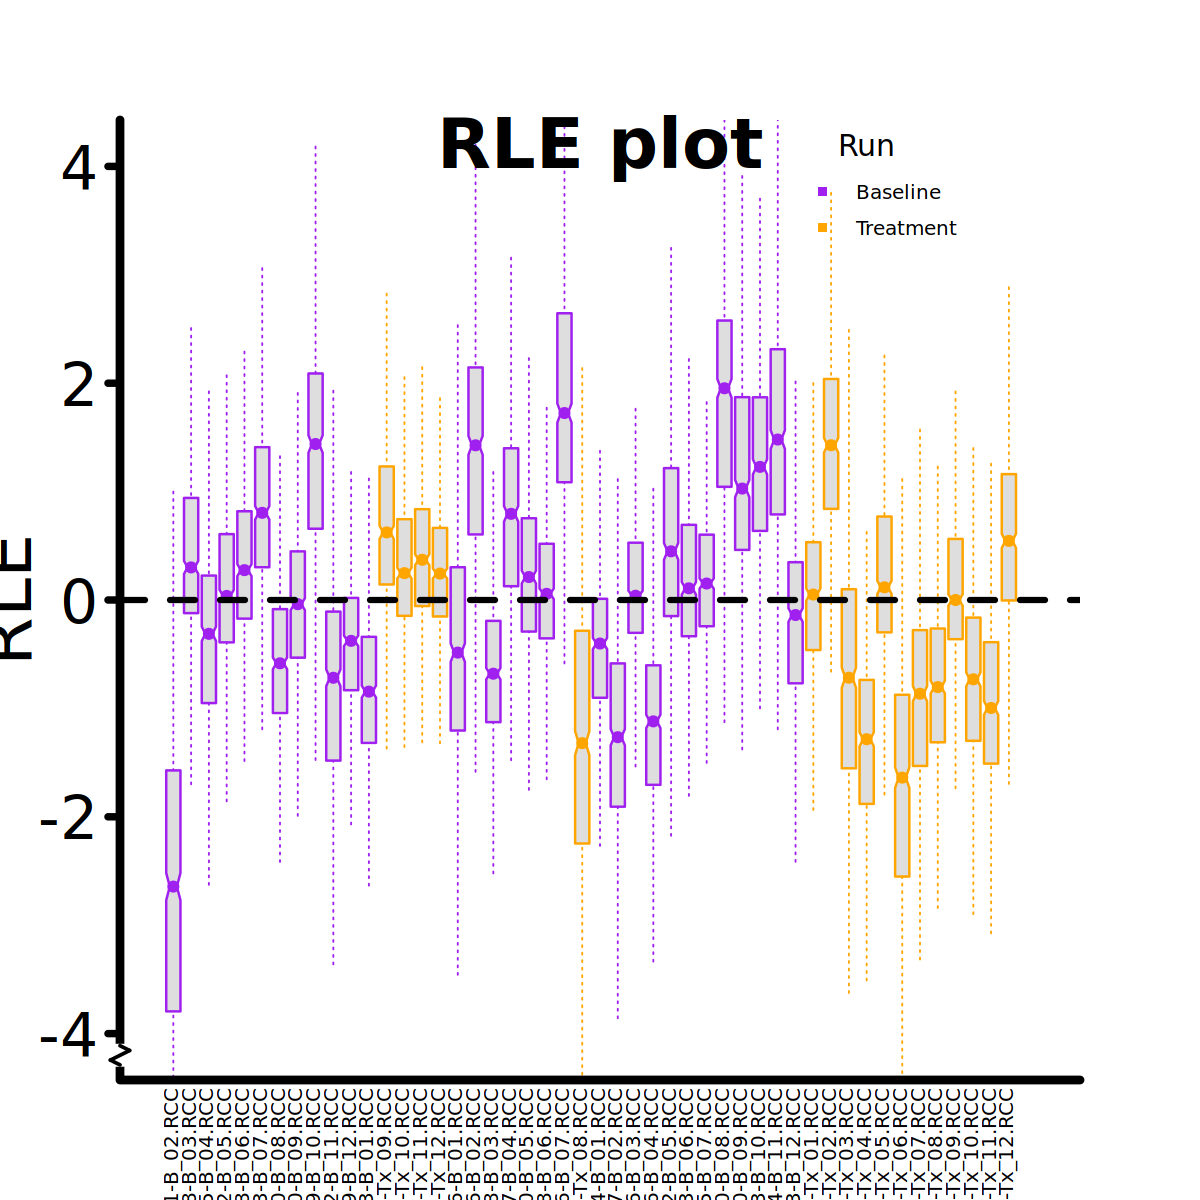

In [19]:
options(repr.plot.width=10, repr.plot.height=10)
# pdf("01_QC_plot_before_normalization.pdf")
rawdata <- as.matrix(raw)
rawdata <- log2(rawdata+1)

RLEplot_mod(rawdata,pData$Diagnosis)
# dev.off()

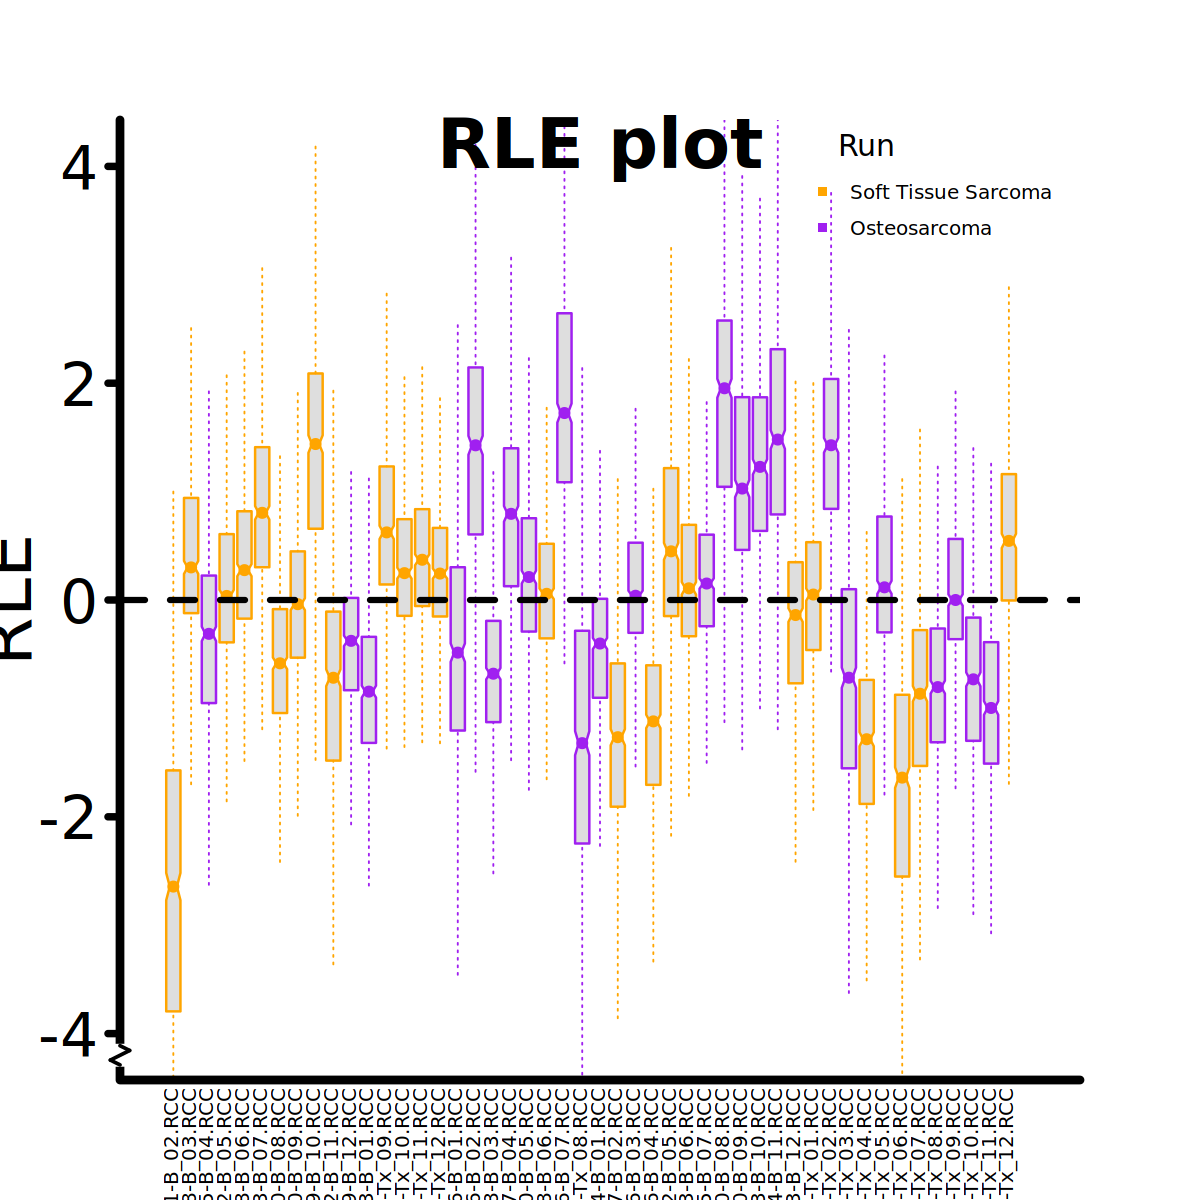

In [20]:
options(repr.plot.width=10, repr.plot.height=10)
# pdf("01_QC_plot_before_normalization.pdf")
rawdata <- as.matrix(raw)
rawdata <- log2(rawdata+1)

RLEplot_mod(rawdata,pData$Conditions)
# dev.off()

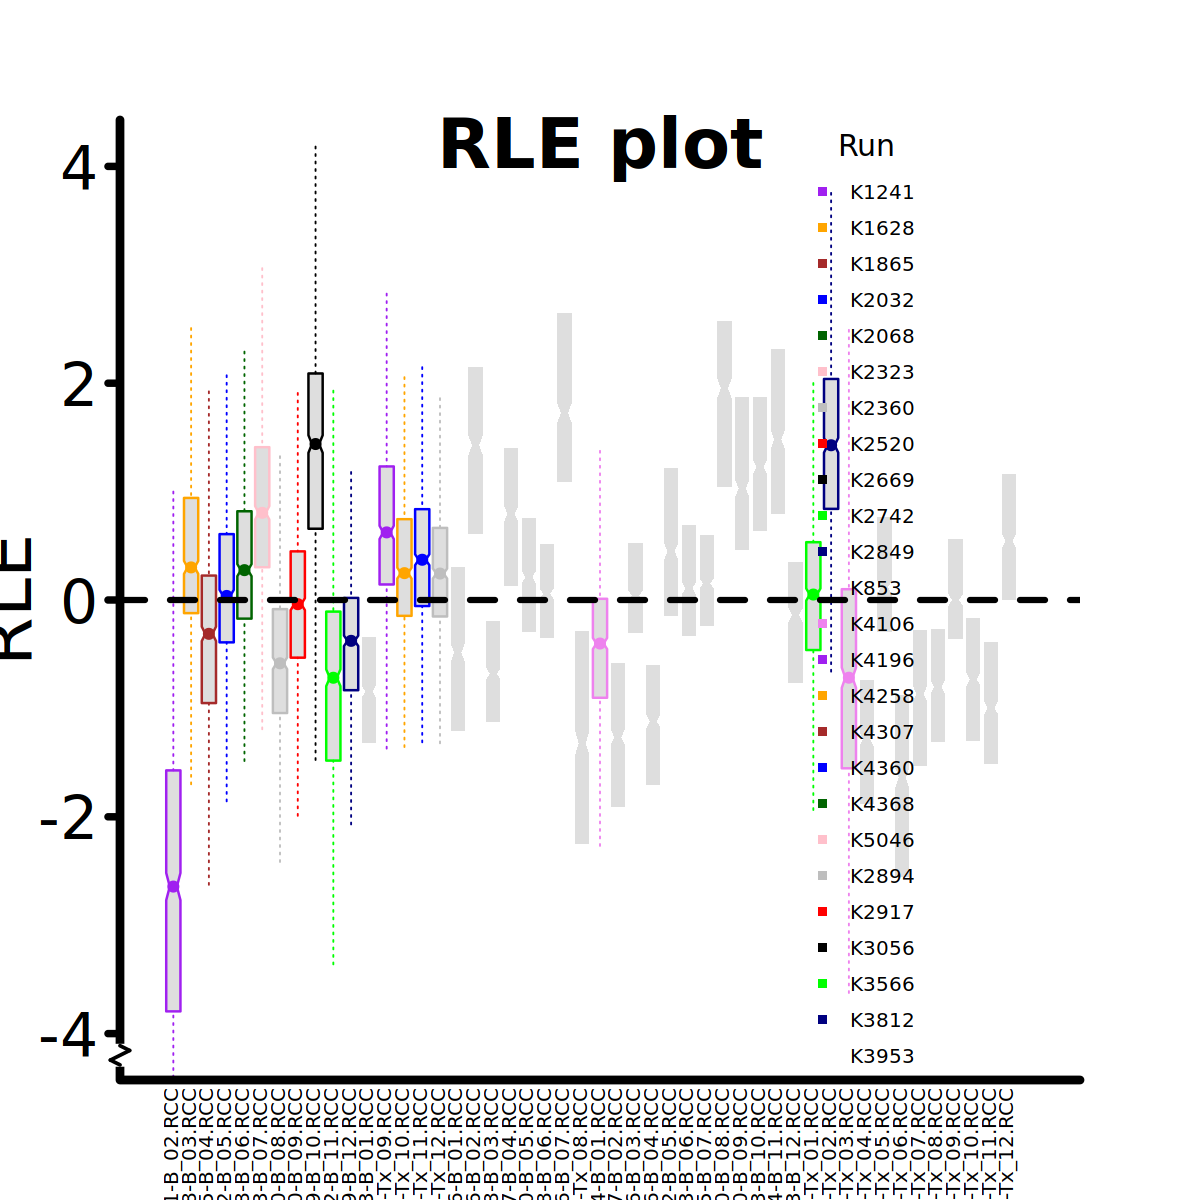

In [21]:
options(repr.plot.width=10, repr.plot.height=10)
# pdf("01_QC_plot_before_normalization.pdf")
rawdata <- as.matrix(raw)
rawdata <- log2(rawdata+1)

RLEplot_mod(rawdata,pData$pid)
# dev.off()

# After normalization plot

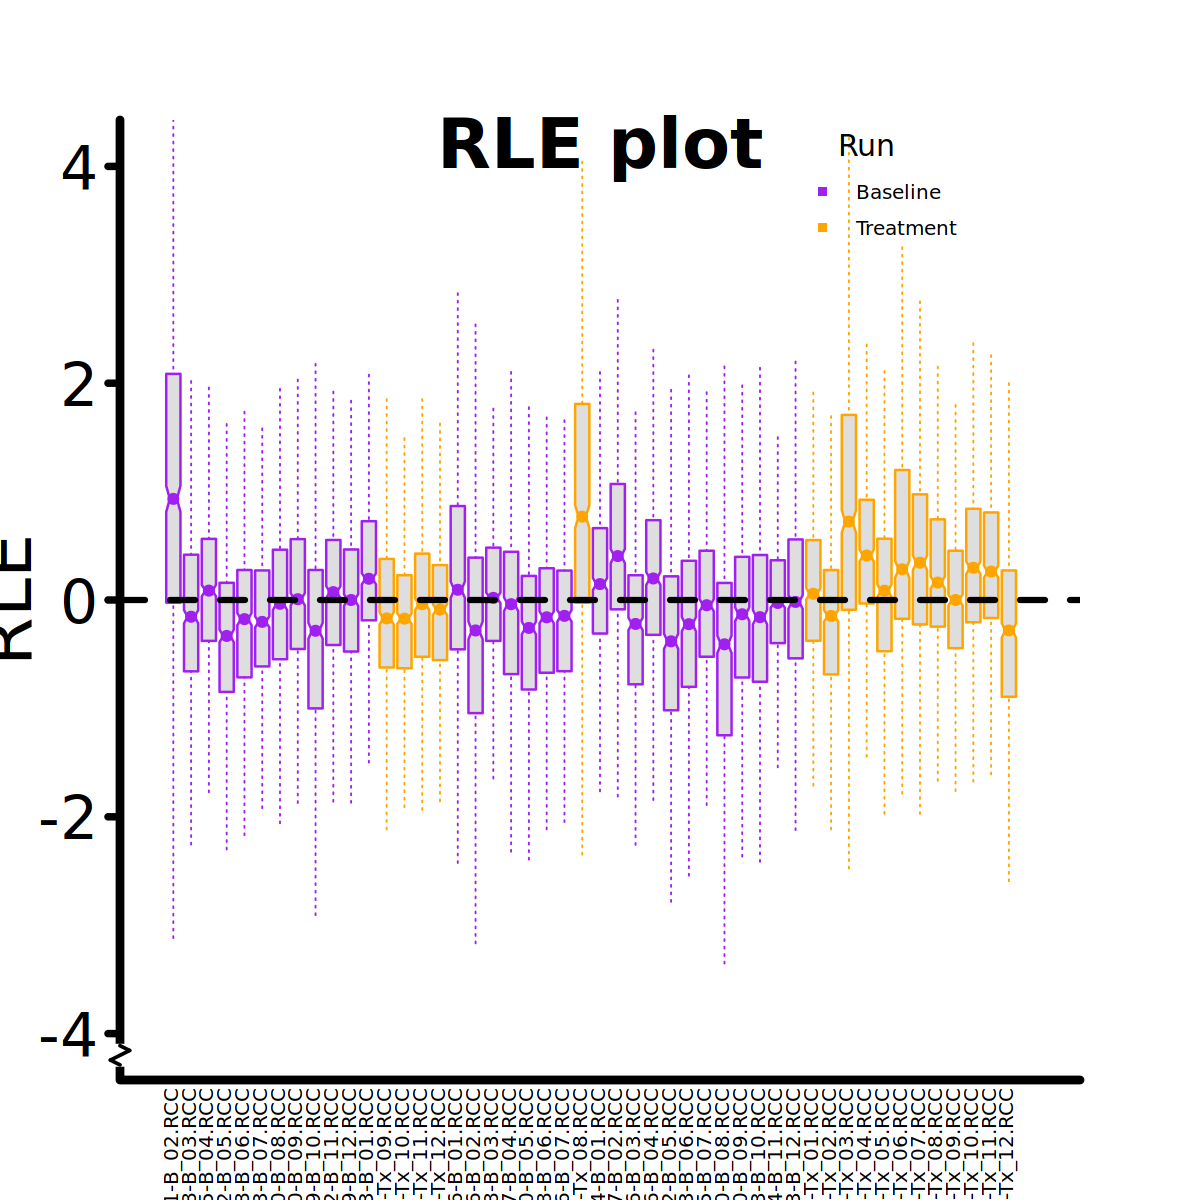

In [22]:
options(repr.plot.width=10, repr.plot.height=10)
# pdf("01_QC_plot_after_normalization.pdf")
nordata <- log2(normalizedcount)
RLEplot_mod(nordata,pData$Diagnosis) ### function is defined below
# dev.off()

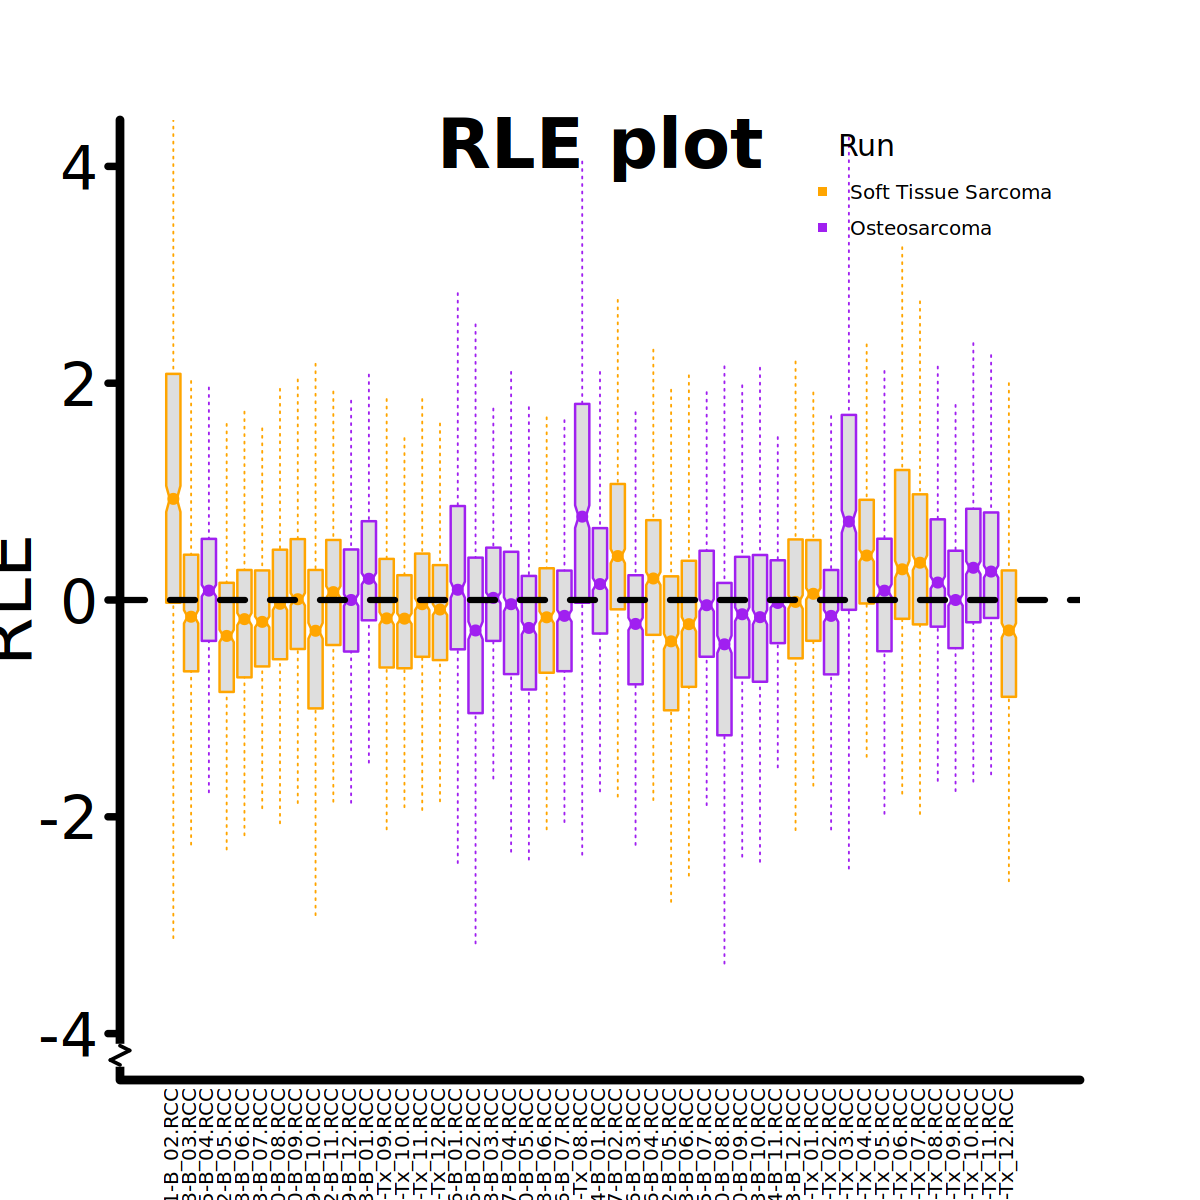

In [23]:
options(repr.plot.width=10, repr.plot.height=10)
# pdf("01_QC_plot_after_normalization.pdf")
nordata <- log2(normalizedcount)
RLEplot_mod(nordata,pData$Conditions) ### function is defined below
# dev.off()

In [24]:
dim(counts(set))
counts(set)

[1] 770  48

20230616_210462891024_K1241-B_02.RCC
A2M      45                                 
ABCB1     6                                 
ABL1     16                                 
ADA      12                                 
ADORA2A   3                                 
AICDA     7                                 
AIRE     12                                 
AKT3     64                                 
ALCAM    12                                 
AMBP      4                                 
AMICA1    8                                 
ANP32B   49                                 
ANXA1   234                                 
APOE     25                                 
APP     246                                 
ARG1      1                                 
ARG2      7                                 
ATF1     16                                 
ATF2      6                                 
ATG10     8                                 
ATG12     5                                 
ATG16L1   8                                 
ATG5      5                                 
ATG7      2                                 
ATM       3                                 
AXL      50                                 
BAGE      4                                 
BATF      2                                 
BAX      19                                 
BCL10    33                                 
⋮       ⋮                                   
DNAJC14   4                                 
EDC3     16                                 
EIF2B4   14                                 
ERCC3    15                                 
FCF1    133                                 
G6PD     10                                 
GPATCH3  21                                 
GUSB     10                                 
HDAC3    12                                 
HPRT1    34                                 
MRPS5    13                                 
MTMR14   22                                 
NOL7      7                                 
NUBP1     5                                 
POLR2A   21                                 
PPIA      6                                 
PRPF38A  16                                 
SAP130   17                                 
SDHA      6                                 
SF3A3   211                                 
TBP      13                                 
TLK2      9                                 
TMUB2     6                                 
TRIM39    8                                 
TUBB     61                                 
USP39     6                                 
ZC3H14   71                                 
ZKSCAN5   8                                 
ZNF143    8                                 
ZNF346    3                                 
        20230616_210462891024_K1628-B_03.RCC
A2M     20742                               
ABCB1     161                               
ABL1     1557                               
ADA        70                               
ADORA2A    27                               
AICDA      10                               
AIRE       10                               
AKT3     4438                               
ALCAM    1637                               
AMBP        3                               
AMICA1    259                               
ANP32B   1166                               
ANXA1    4739                               
APOE      235                               
APP      1895                               
ARG1        8                               
ARG2      165                               
ATF1      207                               
ATF2      301                               
ATG10     216                               
ATG12      31                               
ATG16L1   167                               
ATG5      440                               
ATG7      119                               
ATM        15                               
AXL      2619                               
BAG

In [25]:
pData(set)

Conditions           Diagnosis  pid  
20230616_210462891024_K1241-B_02.RCC  Soft Tissue Sarcoma   Baseline  K1241
20230616_210462891024_K1628-B_03.RCC  Soft Tissue Sarcoma   Baseline  K1628
20230616_210462891024_K1865-B_04.RCC  Osteosarcoma          Baseline  K1865
20230616_210462891024_K2032-B_05.RCC  Soft Tissue Sarcoma   Baseline  K2032
20230616_210462891024_K2068-B_06.RCC  Soft Tissue Sarcoma   Baseline  K2068
20230616_210462891024_K2323-B_07.RCC  Soft Tissue Sarcoma   Baseline  K2323
20230616_210462891024_K2360-B_08.RCC  Soft Tissue Sarcoma   Baseline  K2360
20230616_210462891024_K2520-B_09.RCC  Soft Tissue Sarcoma   Baseline  K2520
20230616_210462891024_K2669-B_10.RCC  Soft Tissue Sarcoma   Baseline  K2669
20230616_210462891024_K2742-B_11.RCC  Soft Tissue Sarcoma   Baseline  K2742
20230616_210462891024_K2849-B_12.RCC  Osteosarcoma          Baseline  K2849
20230616_210462891024_K853-B_01.RCC   Osteosarcoma          Baseline  K853 
20230707_210462871024_K1241-Tx_09.RCC Soft Tissue Sarcoma   Treatment K1241
20230707_210462871024_K1628-Tx_10.RCC Soft Tissue Sarcoma   Treatment K1628
20230707_210462871024_K2032-Tx_11.RCC Soft Tissue Sarcoma   Treatment K2032
20230707_210462871024_K2360-Tx_12.RCC Soft Tissue Sarcoma   Treatment K2360
20230707_210462871024_K4106-B_01.RCC  Osteosarcoma          Baseline  K4106
20230707_210462871024_K4196-B_02.RCC  Osteosarcoma          Baseline  K4196
20230707_210462871024_K4258-B_03.RCC  Osteosarcoma          Baseline  K4258
20230707_210462871024_K4307-B_04.RCC  Osteosarcoma          Baseline  K4307
20230707_210462871024_K4360-B_05.RCC  Osteosarcoma          Baseline  K4360
20230707_210462871024_K4368-B_06.RCC  Soft Tissue Sarcoma   Baseline  K4368
20230707_210462871024_K5046-B_07.RCC  Osteosarcoma          Baseline  K5046
20230707_210462871024_K853-Tx_08.RCC  Osteosarcoma          Treatment K853 
20230707_210462881024_K2894-B_01.RCC  Osteosarcoma          Baseline  K2894
20230707_210462881024_K2917-B_02.RCC  Soft Tissue Sarcoma   Baseline  K2917
20230707_210462881024_K3056-B_03.RCC  Osteosarcoma          Baseline  K3056
20230707_210462881024_K3566-B_04.RCC  Soft Tissue Sarcoma   Baseline  K3566
20230707_210462881024_K3812-B_05.RCC  Soft Tissue Sarcoma   Baseline  K3812
20230707_210462881024_K3953-B_06.RCC  Soft Tissue Sarcoma   Baseline  K3953
20230707_210462881024_K3975-B_07.RCC  Osteosarcoma          Baseline  K3975
20230707_210462881024_K4010-B_08.RCC  Osteosarcoma          Baseline  K4010
20230707_210462881024_K4020-B_09.RCC  Osteosarcoma          Baseline  K4020
20230707_210462881024_K4023-B_10.RCC  Osteosarcoma          Baseline  K4023
20230707_210462881024_K4054-B_11.RCC  Osteosarcoma          Baseline  K4054
20230707_210462881024_K4093-B_12.RCC  Soft Tissue Sarcoma   Baseline  K4093
20230707_210462901024_K2742-Tx_01.RCC Soft Tissue Sarcoma   Treatment K2742
20230707_210462901024_K2849-Tx_02.RCC Osteosarcoma          Treatment K2849
20230707_210462901024_K2894-Tx_03.RCC Osteosarcoma          Treatment K2894
20230707_210462901024_K2917-Tx_04.RCC Soft Tissue Sarcoma   Treatment K2917
20230707_210462901024_K3056-Tx_05.RCC Osteosarcoma          Treatment K3056
20230707_210462901024_K3566-Tx_06.RCC Soft Tissue Sarcoma   Treatment K3566
20230707_210462901024_K3953-Tx_07.RCC Soft Tissue Sarcoma   Treatment K3953
20230707_210462901024_K3975-Tx_08.RCC Osteosarcoma          Treatment K3975
20230707_210462901024_K4106-Tx_09.RCC Osteosarcoma          Treatment K4106
20230707_210462901024_K4258-Tx_10.RCC Osteosarcoma          Treatment K4258
20230707_210462901024_K4360-Tx_11.RCC Osteosarcoma          Treatment K4360
20230707_210462901024_K4368-Tx_12.RCC Soft Tissue Sarcoma   Treatment K4368
                                      Is_matched Subject_ID RECIST_response
20230616_210462891024_K1241-B_02.RCC  True       TI0045     SD             
20230616_210462891024_K1628-B_03.RCC  True       TI0036     PD             
20230616_210462891024_K1865-B_04.RCC  False      TI0004     PD             
20230616_2

In [26]:
design <- model.matrix(~Diagnosis + W_1, data=pData(set))
design

(Intercept) Diagnosis Treatment
20230616_210462891024_K1241-B_02.RCC  1           0                  
20230616_210462891024_K1628-B_03.RCC  1           0                  
20230616_210462891024_K1865-B_04.RCC  1           0                  
20230616_210462891024_K2032-B_05.RCC  1           0                  
20230616_210462891024_K2068-B_06.RCC  1           0                  
20230616_210462891024_K2323-B_07.RCC  1           0                  
20230616_210462891024_K2360-B_08.RCC  1           0                  
20230616_210462891024_K2520-B_09.RCC  1           0                  
20230616_210462891024_K2669-B_10.RCC  1           0                  
20230616_210462891024_K2742-B_11.RCC  1           0                  
20230616_210462891024_K2849-B_12.RCC  1           0                  
20230616_210462891024_K853-B_01.RCC   1           0                  
20230707_210462871024_K1241-Tx_09.RCC 1           1                  
20230707_210462871024_K1628-Tx_10.RCC 1           1                  
20230707_210462871024_K2032-Tx_11.RCC 1           1                  
20230707_210462871024_K2360-Tx_12.RCC 1           1                  
20230707_210462871024_K4106-B_01.RCC  1           0                  
20230707_210462871024_K4196-B_02.RCC  1           0                  
20230707_210462871024_K4258-B_03.RCC  1           0                  
20230707_210462871024_K4307-B_04.RCC  1           0                  
20230707_210462871024_K4360-B_05.RCC  1           0                  
20230707_210462871024_K4368-B_06.RCC  1           0                  
20230707_210462871024_K5046-B_07.RCC  1           0                  
20230707_210462871024_K853-Tx_08.RCC  1           1                  
20230707_210462881024_K2894-B_01.RCC  1           0                  
20230707_210462881024_K2917-B_02.RCC  1           0                  
20230707_210462881024_K3056-B_03.RCC  1           0                  
20230707_210462881024_K3566-B_04.RCC  1           0                  
20230707_210462881024_K3812-B_05.RCC  1           0                  
20230707_210462881024_K3953-B_06.RCC  1           0                  
20230707_210462881024_K3975-B_07.RCC  1           0                  
20230707_210462881024_K4010-B_08.RCC  1           0                  
20230707_210462881024_K4020-B_09.RCC  1           0                  
20230707_210462881024_K4023-B_10.RCC  1           0                  
20230707_210462881024_K4054-B_11.RCC  1           0                  
20230707_210462881024_K4093-B_12.RCC  1           0                  
20230707_210462901024_K2742-Tx_01.RCC 1           1                  
20230707_210462901024_K2849-Tx_02.RCC 1           1                  
20230707_210462901024_K2894-Tx_03.RCC 1           1                  
20230707_210462901024_K2917-Tx_04.RCC 1           1                  
20230707_210462901024_K3056-Tx_05.RCC 1           1                  
20230707_210462901024_K3566-Tx_06.RCC 1           1                  
20230707_210462901024_K3953-Tx_07.RCC 1           1                  
20230707_210462901024_K3975-Tx_08.RCC 1           1                  
20230707_210462901024_K4106-Tx_09.RCC 1           1                  
20230707_210462901024_K4258-Tx_10.RCC 1           1                  
20230707_210462901024_K4360-Tx_11.RCC 1           1                  
20230707_210462901024_K4368-Tx_12.RCC 1           1                  
                                      W_1         
20230616_210462891024_K1241-B_02.RCC   0.034331180
20230616_210462891024_K1628-B_03.RCC   0.085521945
20230616_210462891024_K1865-B_04.RCC  -0.214989634
20230616_210462891024_K2032-B_05.RCC   0.116582529
20230616_210462891024_K2068-B_06.RCC  -0.029203470
20230616_210462891024_K2323-B_07.RCC  -0.173686293
20230616_210462891024_K2360-B_08.RCC   0.030520175
20230616_210462891024_K2520-B_09.RCC   0.208871077
20230616_210462891024_K2669-B_10.RCC   0.152098738
20230616_210462891024_K2742-B_11.RCC   0.334744885
20230616_210462891024_K2849-B_12.RCC   0.021714

## DE analysis for Baseline vs Treatment

In [114]:
dds <- DESeqDataSetFromMatrix(countData = counts(set),
                              colData = pData(set),
                              design = ~ W_1 + Diagnosis)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [115]:
de_dds <- DESeq(dds)

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and t

In [116]:
results(de_dds)

log2 fold change (MLE): Diagnosis .Treatment vs .Baseline 
Wald test p-value: Diagnosis .Treatment vs .Baseline 
DataFrame with 770 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat    pvalue      padj
        <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
A2M     4780.7366      -0.442260  0.454865 -0.972290 0.3309064  0.608110
ABCB1     56.9506      -0.322549  0.412112 -0.782673 0.4338192  0.669843
ABL1     495.4339      -0.260286  0.252779 -1.029698 0.3031517  0.594320
ADA       78.6005      -0.226948  0.217918 -1.041437 0.2976726  0.590742
ADORA2A   34.5024       0.579089  0.249882  2.317449 0.0204793  0.137122
...           ...            ...       ...       ...       ...       ...
USP39    101.8614     -0.0889341  0.190084 -0.467868 0.6398793  0.802454
ZC3H14   357.7481     -0.3864739  0.157574 -2.452650 0.0141808  0.111421
ZKSCAN5   58.3676     -0.0237431  0.129823 -0.182889 0.8548851  0.933704
ZNF143    90.0318     -0.2333825  0.118285 -1.

In [117]:
firstC <- 'Treatment'
SecondC <- 'Baseline'
contrast<- c("Diagnosis",firstC,SecondC)
res_deseq <- as.data.frame(results(de_dds))
nam <- paste('up_in',firstC, sep = '_')

In [118]:
res_deseq[, nam] <- as.logical(res_deseq$log2FoldChange > 0)

res_deseq$threshold <- as.logical(res_deseq$padj < 0.05) 


In [119]:
res_valcanoplot1 <- results(de_dds)
res_valcanoplot1

log2 fold change (MLE): Diagnosis .Treatment vs .Baseline 
Wald test p-value: Diagnosis .Treatment vs .Baseline 
DataFrame with 770 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat    pvalue      padj
        <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
A2M     4780.7366      -0.442260  0.454865 -0.972290 0.3309064  0.608110
ABCB1     56.9506      -0.322549  0.412112 -0.782673 0.4338192  0.669843
ABL1     495.4339      -0.260286  0.252779 -1.029698 0.3031517  0.594320
ADA       78.6005      -0.226948  0.217918 -1.041437 0.2976726  0.590742
ADORA2A   34.5024       0.579089  0.249882  2.317449 0.0204793  0.137122
...           ...            ...       ...       ...       ...       ...
USP39    101.8614     -0.0889341  0.190084 -0.467868 0.6398793  0.802454
ZC3H14   357.7481     -0.3864739  0.157574 -2.452650 0.0141808  0.111421
ZKSCAN5   58.3676     -0.0237431  0.129823 -0.182889 0.8548851  0.933704
ZNF143    90.0318     -0.2333825  0.118285 -1.

In [120]:
norm_mean_w1 <- sapply( levels(de_dds$Diagnosis), function(lvl) rowMeans( counts(de_dds,normalized=TRUE)[,de_dds$Diagnosis == lvl, drop=F] ) )


In [121]:
colnames(norm_mean_w1) <- paste('Rowmean_exp_',levels(de_dds$Diagnosis),sep='')

res1 <- cbind(norm_mean_w1,res_deseq)

In [122]:
dim(res_deseq)

[1] 770   8

In [124]:
top_de_genes = res1[row.names(res_deseq)[which(res_deseq$threshold)],]
top_de_genes

Rowmean_exp_ Baseline Rowmean_exp_ Treatment baseMean    log2FoldChange
AMBP       8.652198           720.67968               260.828598  6.3963764    
ARG1       7.820747            88.02451                36.226246  3.5178118    
ATF1     228.318695           166.03378               206.259455 -0.4570358    
ATG10     91.909627            63.70953                81.922092 -0.5018531    
BAGE      12.381042            28.57603                18.116768  1.1868465    
BCL2     296.983067           156.73736               247.312713 -0.8563117    
BCL6     294.851059           184.33133               255.708656 -0.7234375    
C4BPA     27.594342            65.04762                40.859045  2.7477327    
C6        19.583187            62.75906                34.874644  1.7259973    
C8A       10.413022            50.17814                24.496502  2.3281702    
C8B       11.454757            78.68402                35.265121  3.0087152    
C8G       19.069881            37.90718                25.741423  1.0466176    
C9        16.417124           156.69219                66.097875  3.2659025    
CCL11     16.933851            33.91658                22.948566  1.0741718    
CCL16     13.139252            31.00232                19.465756  1.3210184    
CCL18    383.346966            88.59854               278.956897 -1.5774326    
CHUK     291.563127           192.67231               256.539295 -0.5854432    
CLEC4A   137.503022            88.23789               120.054956 -0.5999661    
CLU       12.491243            20.44396                15.307830  0.7283453    
CRP        8.165846            49.01356                22.632746  2.5909762    
CTAGE1     6.733831            12.45240                 8.759159  0.9943025    
CTLA4     38.323569           130.20457                70.864758  1.8454835    
CXCL2    248.898180            76.97678               188.009352 -1.4374587    
CXCL6     17.940147            52.52024                30.187262  1.6079155    
DEFB1      8.048926            13.48252                 9.973325  0.7091156    
EGR1     228.068663            68.40568               171.521358 -1.7263606    
F12       14.983733            63.02203                31.997296  2.1903957    
FADD      58.253409            43.16211                52.908573 -0.4522992    
FOS     2795.983485           309.69060              1915.421421 -3.1827407    
FYN      613.683671           358.78972               523.408731 -0.7850101    
⋮       ⋮                     ⋮                      ⋮           ⋮             
IRAK4     142.497057            102.86554              128.46089 -0.4802627    
IRF3      118.446217             78.75870              104.39022 -0.5813868    
LAMP1    3167.764788           2046.80974             2770.75987 -0.6113450    
MAGEB2     13.217198             30.25230               19.25046  1.2508111    
MAP2K2    981.809249            660.58944              868.04390 -0.5681070    
MAP3K7    561.595138            416.92121              510.35645 -0.4209595    
MASP2       9.331034             20.59743               13.32122  1.2825693    
MX1      1275.596739            471.69510              990.88158 -1.4040603    
NFATC1    139.587118             72.75011              115.91568 -0.9256980    
NFATC2    296.396146            150.63858              244.77367 -0.9554902    
NFKBIA   1500.270989            876.75073             1279.44090 -0.7410441    
PRM1        8.410843             13.20315               10.10812  0.7678552    
PSMD7     943.408500            552.30844              804.89390 -0.7660936    
RAG1       25.862228             42.13319               31.62486  0.7102833    
REL       107.184309             75.13668               95.83411 -0.5121003    
RPS6    21278.287570          12625.35161            18213.70608 -0.7240732    
SELL       70.487894             35.68010               58.16013 -0.7836465    
STAT3    2202.590345           1472.11393             1943.87995 -0.5729263    
TBK1    

In [46]:
log2(720.67968/8.652198)

[1] 6.380148

In [76]:
log2(88.02451/7.820747)

[1] 3.492527

In [37]:
library(EnhancedVolcano)
library('tidyr')

Loading required package: ggrepel


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [48]:
write.csv(top_de_genes, file = '0729_DEseq2_DGE_Baseline_vs_Treatment.csv')

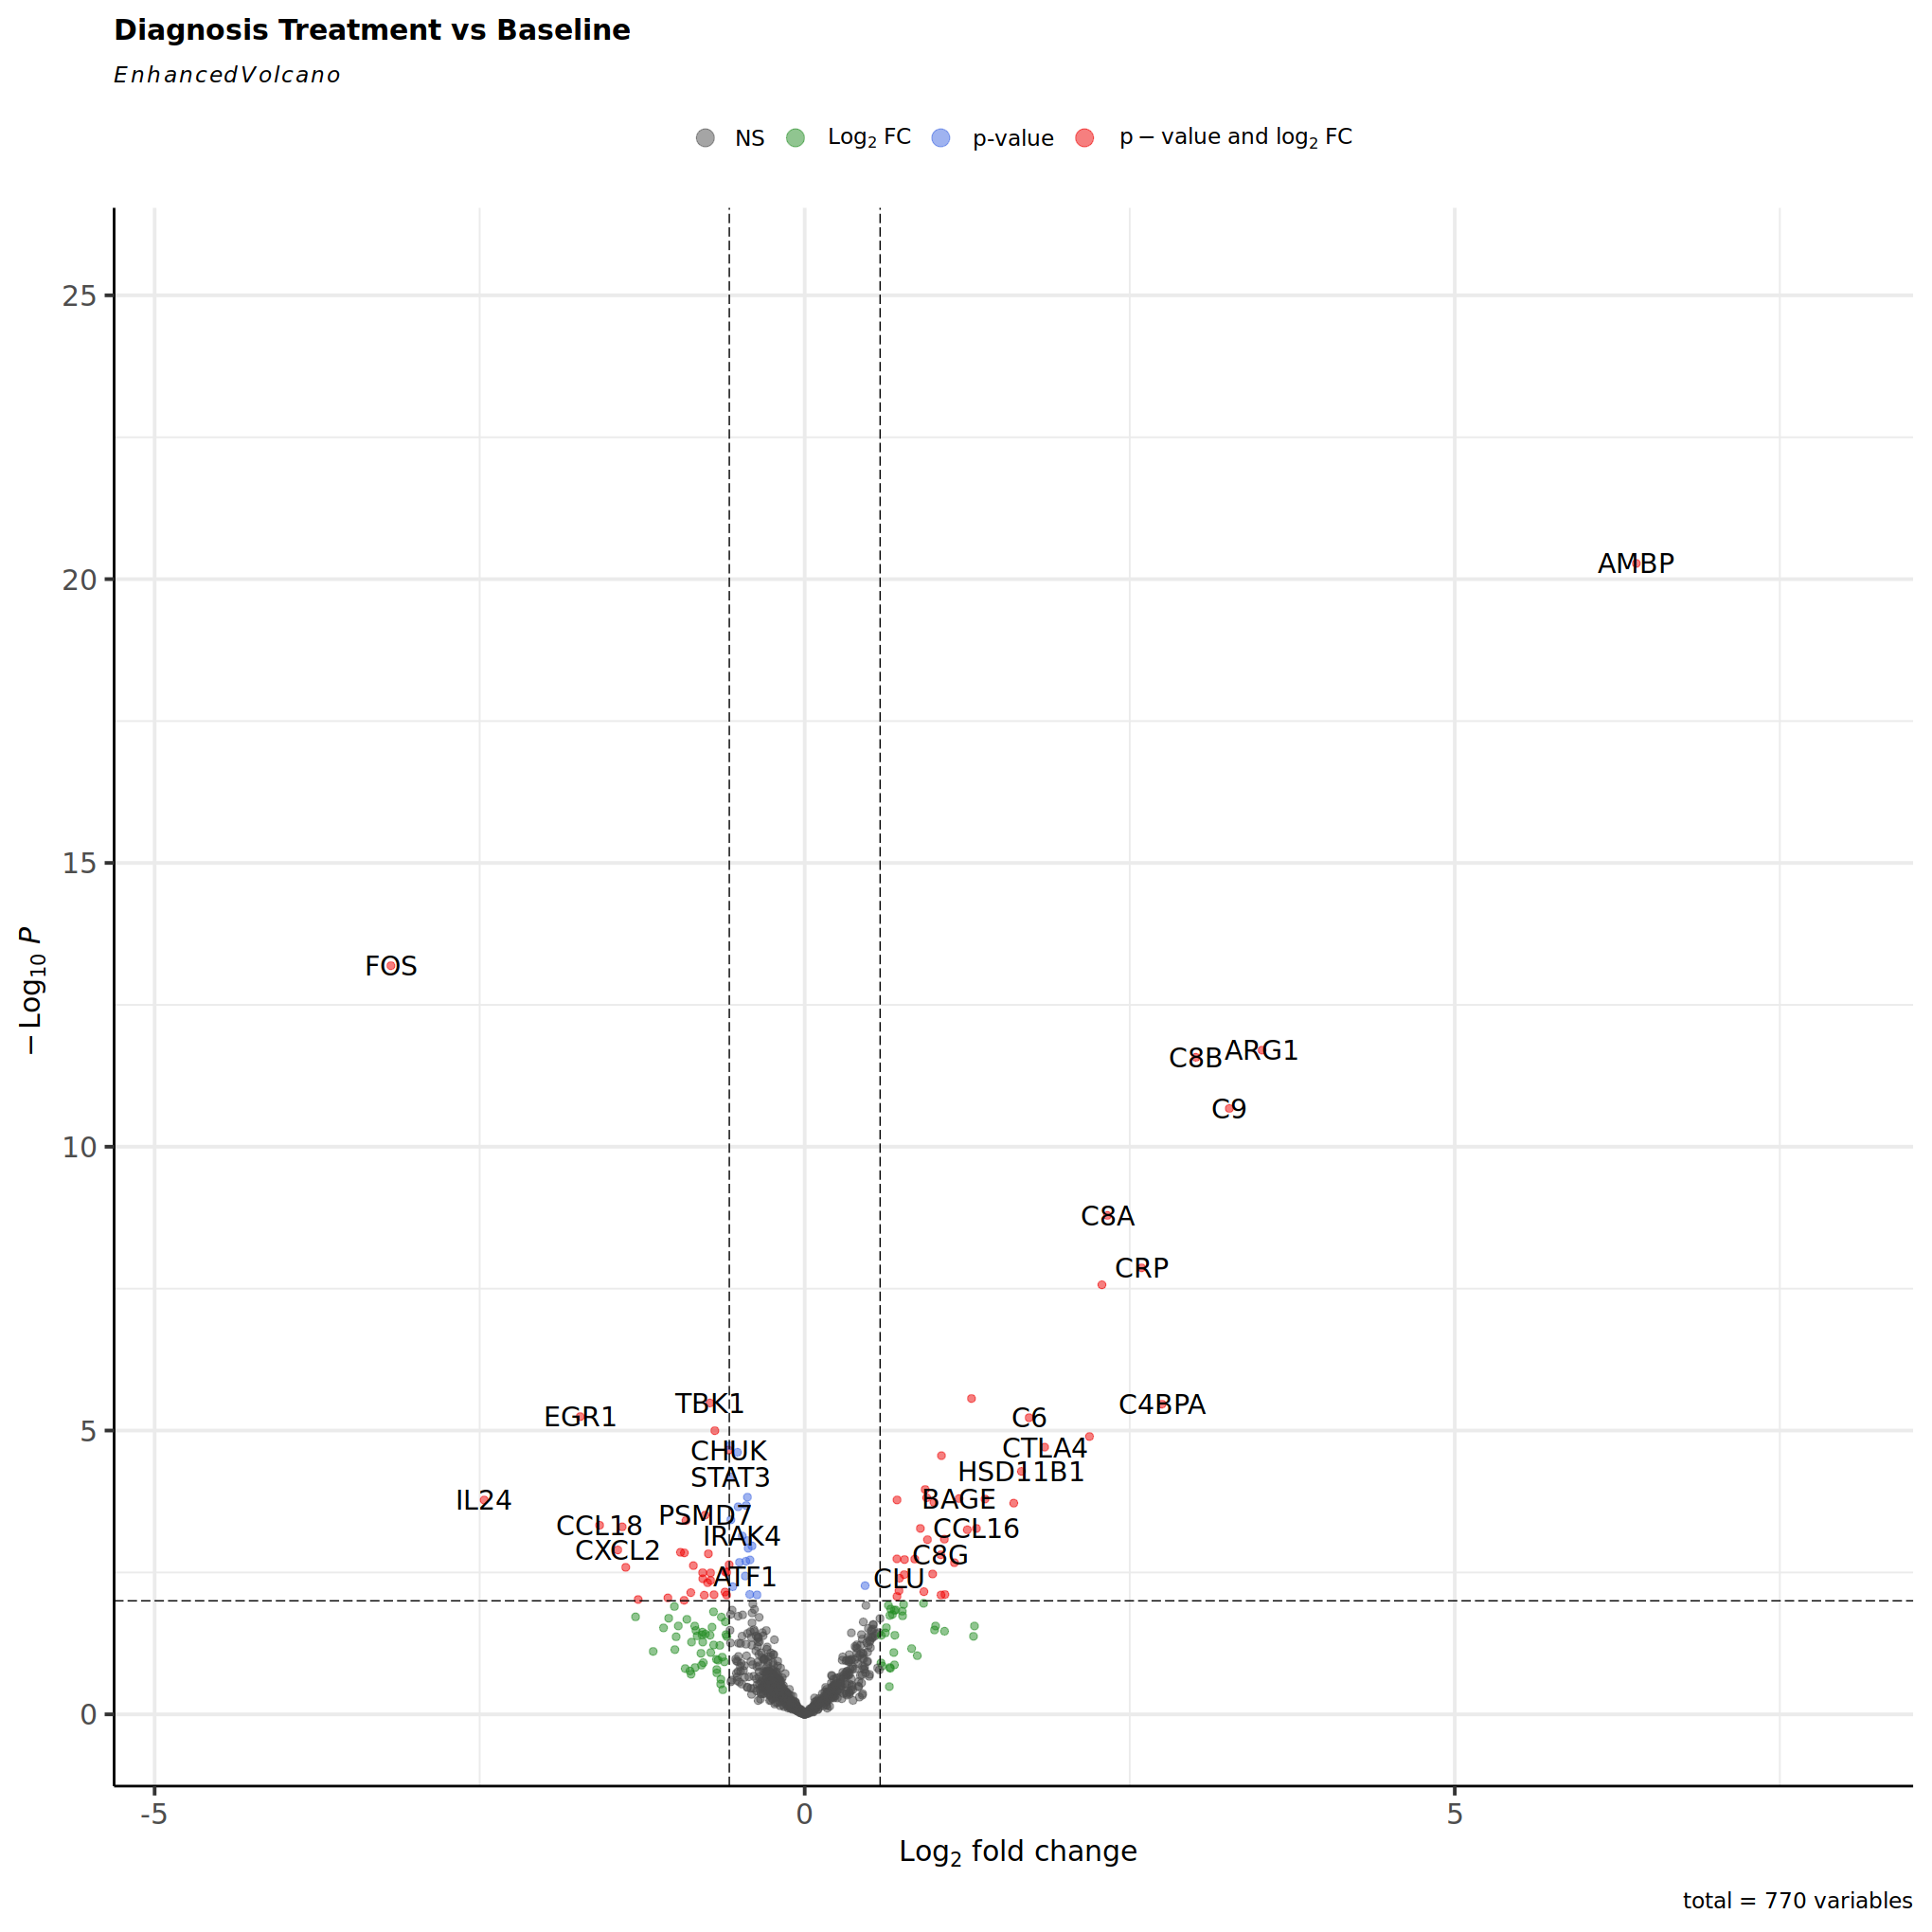

In [125]:
options(repr.plot.width=17, repr.plot.height=17)
# pdf("05_Baseline_vs_Treatment_volcano_plot.pdf")
# jpeg('01_SD_vs_PD_volcano_plot.jpg')
sdvspd_volplot <- EnhancedVolcano(res_valcanoplot1,
                lab = rownames(res_valcanoplot1), selectLab = row.names(top_de_genes),
                x = 'log2FoldChange',
                y = 'pvalue', title = 'Diagnosis Treatment vs Baseline',
                pCutoff = 0.01, drawConnectors = FALSE,max.overlaps = 30,
                FCcutoff = 0.58,
                pointSize = 2.0,
                labSize = 6.0)
# dev.off()
sdvspd_volplot

In [126]:
ggsave("06_baseline_vs_treatment_volcano_plot.pdf", 
       width = 10,
       height = 10, sdvspd_volplot)

In [79]:
goi = c('FOS', 'EGR1', 'IL24' ,'ARG1', 'C8B', 'C9')
goi

[1] "FOS"  "EGR1" "IL24" "ARG1" "C8B"  "C9"

In [80]:
tcounts <- t(log2((counts(de_dds[goi, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(de_dds), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi)+1):ncol(.))

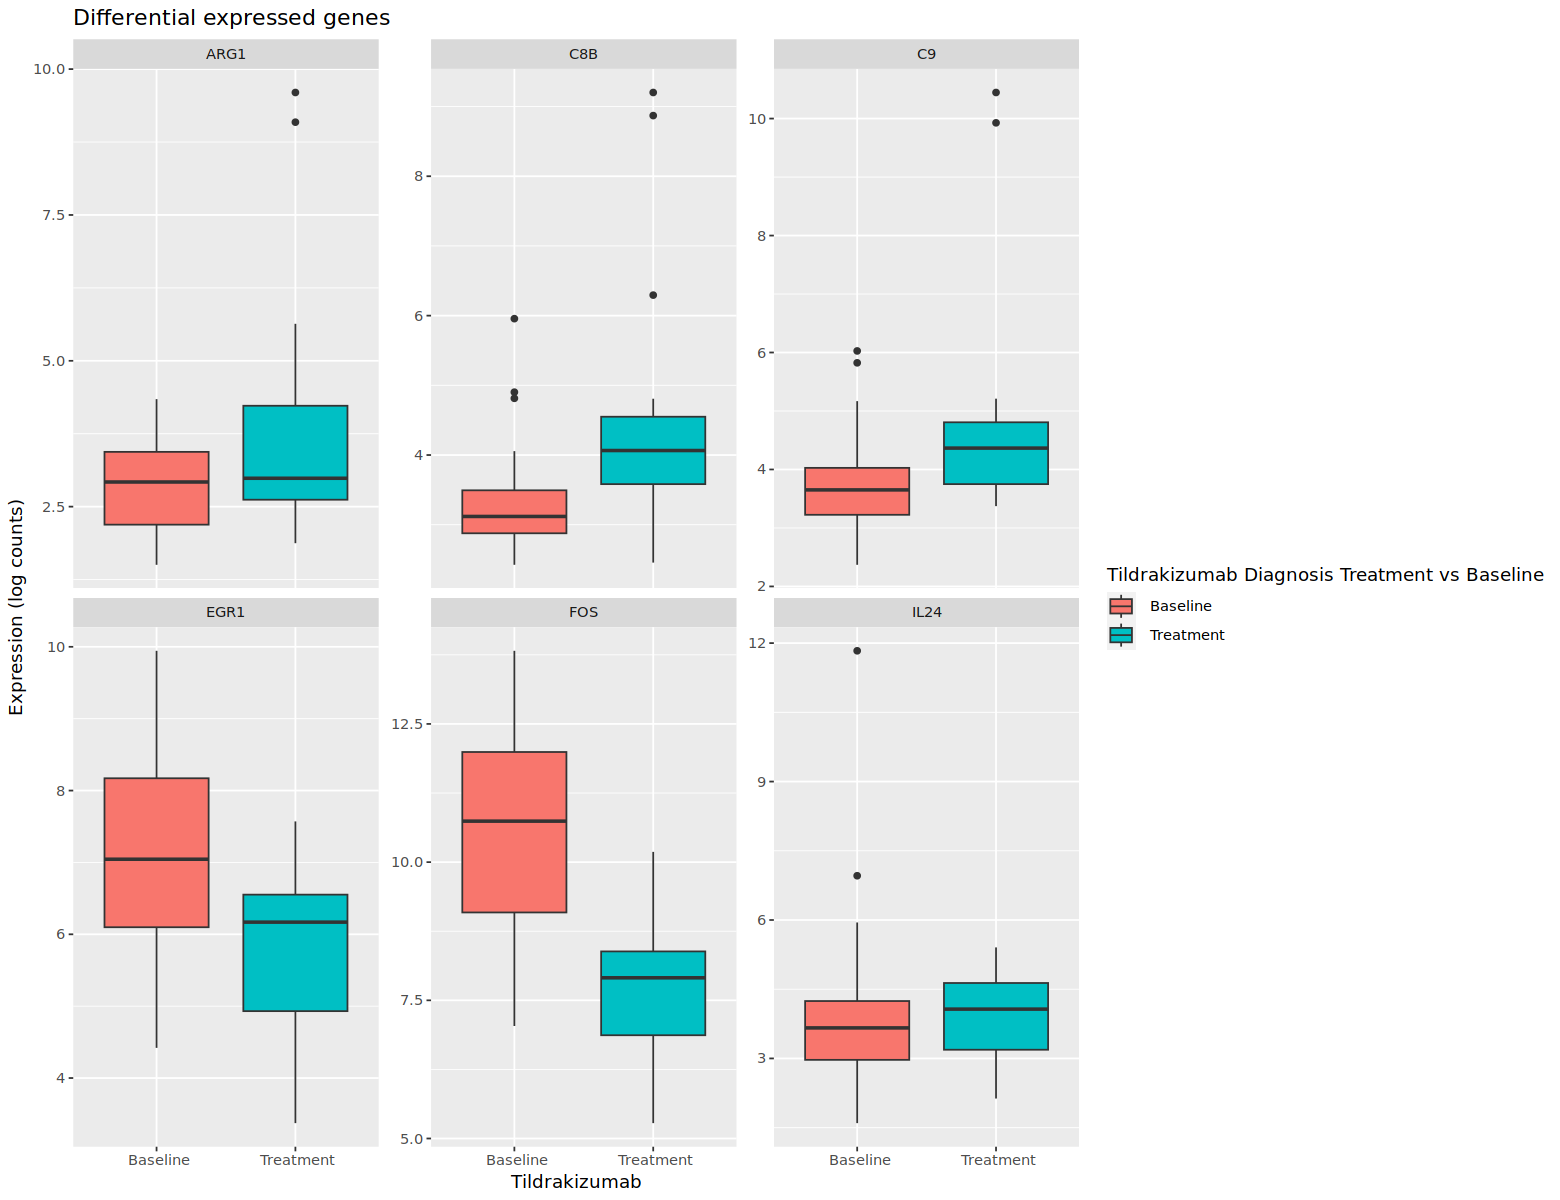

In [114]:
options(repr.plot.width=13, repr.plot.height=10)
sd_boxplot = ggplot(tcounts, aes(Diagnosis, expression, fill=Diagnosis)) + 
  geom_boxplot() + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab Diagnosis Treatment vs Baseline", 
       title="Differential expressed genes")
sd_boxplot

In [19]:
library(ggplot2)


png 
  2

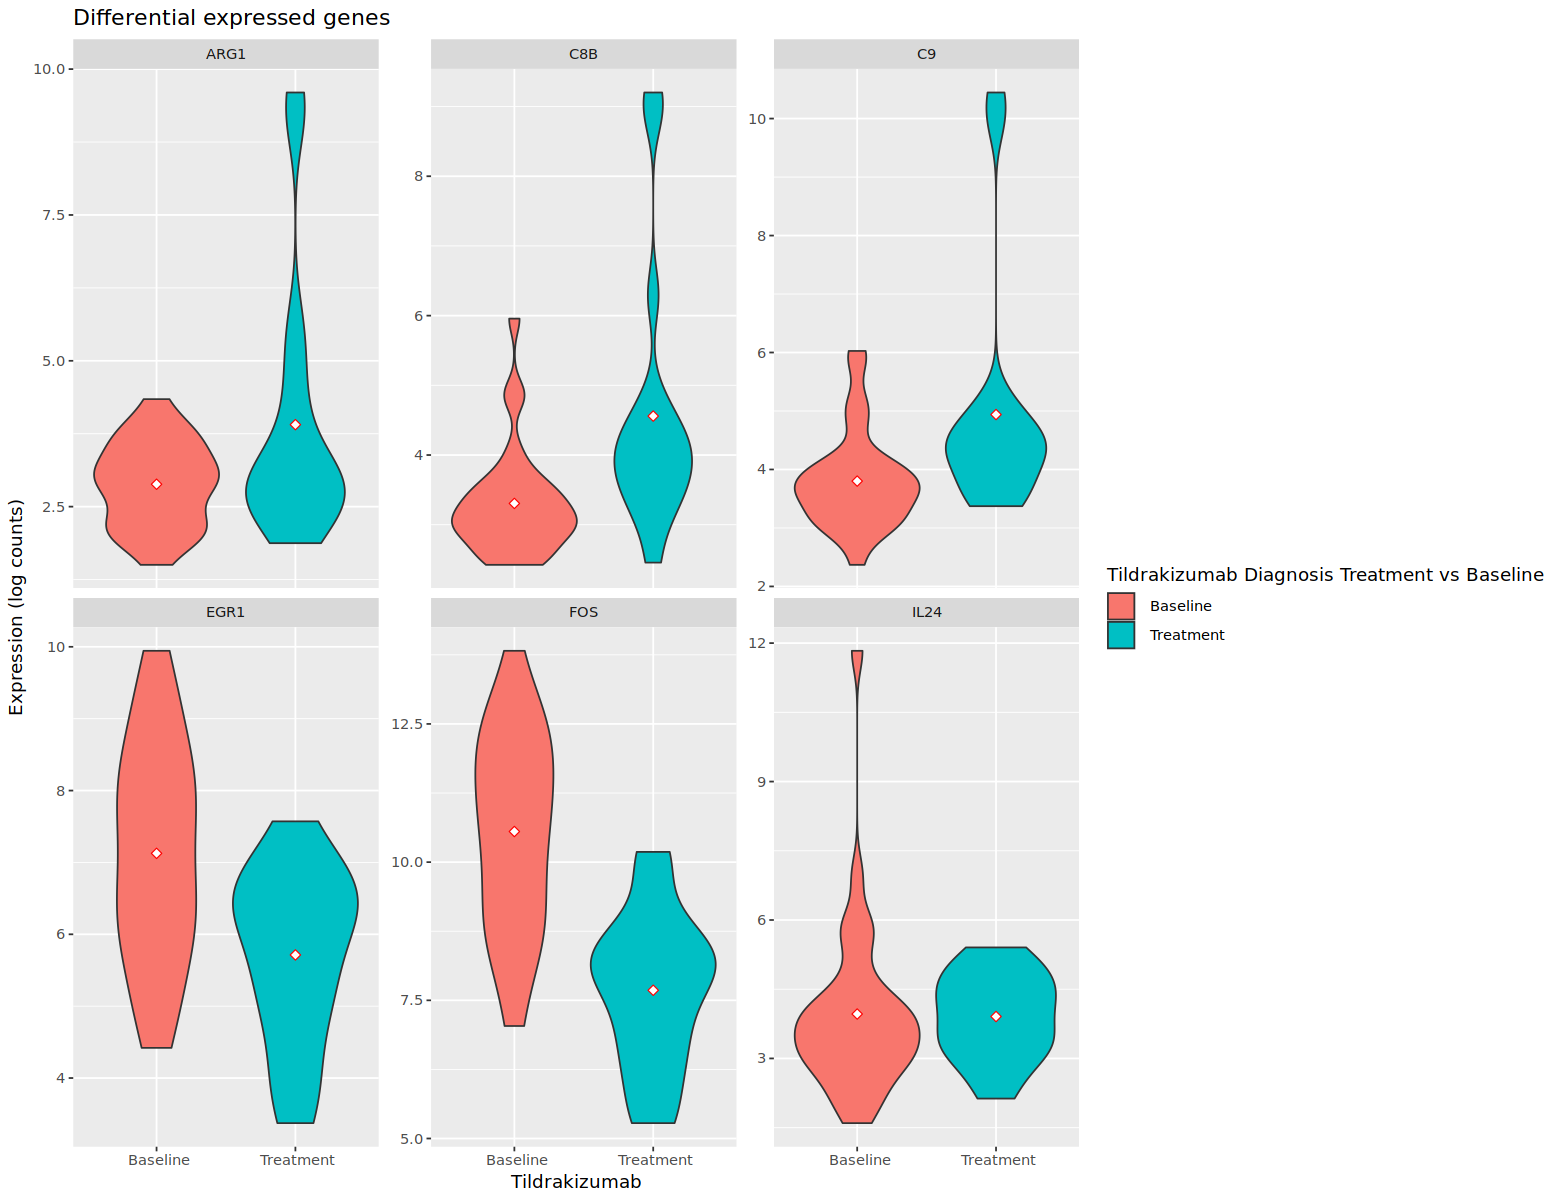

In [83]:
options(repr.plot.width=13, repr.plot.height=10)
pdf("05_Baseline_vs_Treatment_box_plot.pdf")
sd_boxplot = ggplot(tcounts, aes(Diagnosis, expression, fill=Diagnosis)) + 
  geom_violin() + 
  stat_summary(fun = mean, geom = "point", shape = 23, size = 2, color = "red", fill = "white") + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab Diagnosis Treatment vs Baseline", 
       title="Differential expressed genes")
dev.off()
sd_boxplot

In [59]:
pData(set)

Conditions           Diagnosis  pid  
20230616_210462891024_K1241-B_02.RCC  Soft Tissue Sarcoma   Baseline  K1241
20230616_210462891024_K1628-B_03.RCC  Soft Tissue Sarcoma   Baseline  K1628
20230616_210462891024_K1865-B_04.RCC  Osteosarcoma          Baseline  K1865
20230616_210462891024_K2032-B_05.RCC  Soft Tissue Sarcoma   Baseline  K2032
20230616_210462891024_K2068-B_06.RCC  Soft Tissue Sarcoma   Baseline  K2068
20230616_210462891024_K2323-B_07.RCC  Soft Tissue Sarcoma   Baseline  K2323
20230616_210462891024_K2360-B_08.RCC  Soft Tissue Sarcoma   Baseline  K2360
20230616_210462891024_K2520-B_09.RCC  Soft Tissue Sarcoma   Baseline  K2520
20230616_210462891024_K2669-B_10.RCC  Soft Tissue Sarcoma   Baseline  K2669
20230616_210462891024_K2742-B_11.RCC  Soft Tissue Sarcoma   Baseline  K2742
20230616_210462891024_K2849-B_12.RCC  Osteosarcoma          Baseline  K2849
20230616_210462891024_K853-B_01.RCC   Osteosarcoma          Baseline  K853 
20230707_210462871024_K1241-Tx_09.RCC Soft Tissue Sarcoma   Treatment K1241
20230707_210462871024_K1628-Tx_10.RCC Soft Tissue Sarcoma   Treatment K1628
20230707_210462871024_K2032-Tx_11.RCC Soft Tissue Sarcoma   Treatment K2032
20230707_210462871024_K2360-Tx_12.RCC Soft Tissue Sarcoma   Treatment K2360
20230707_210462871024_K4106-B_01.RCC  Osteosarcoma          Baseline  K4106
20230707_210462871024_K4196-B_02.RCC  Osteosarcoma          Baseline  K4196
20230707_210462871024_K4258-B_03.RCC  Osteosarcoma          Baseline  K4258
20230707_210462871024_K4307-B_04.RCC  Osteosarcoma          Baseline  K4307
20230707_210462871024_K4360-B_05.RCC  Osteosarcoma          Baseline  K4360
20230707_210462871024_K4368-B_06.RCC  Soft Tissue Sarcoma   Baseline  K4368
20230707_210462871024_K5046-B_07.RCC  Osteosarcoma          Baseline  K5046
20230707_210462871024_K853-Tx_08.RCC  Osteosarcoma          Treatment K853 
20230707_210462881024_K2894-B_01.RCC  Osteosarcoma          Baseline  K2894
20230707_210462881024_K2917-B_02.RCC  Soft Tissue Sarcoma   Baseline  K2917
20230707_210462881024_K3056-B_03.RCC  Osteosarcoma          Baseline  K3056
20230707_210462881024_K3566-B_04.RCC  Soft Tissue Sarcoma   Baseline  K3566
20230707_210462881024_K3812-B_05.RCC  Soft Tissue Sarcoma   Baseline  K3812
20230707_210462881024_K3953-B_06.RCC  Soft Tissue Sarcoma   Baseline  K3953
20230707_210462881024_K3975-B_07.RCC  Osteosarcoma          Baseline  K3975
20230707_210462881024_K4010-B_08.RCC  Osteosarcoma          Baseline  K4010
20230707_210462881024_K4020-B_09.RCC  Osteosarcoma          Baseline  K4020
20230707_210462881024_K4023-B_10.RCC  Osteosarcoma          Baseline  K4023
20230707_210462881024_K4054-B_11.RCC  Osteosarcoma          Baseline  K4054
20230707_210462881024_K4093-B_12.RCC  Soft Tissue Sarcoma   Baseline  K4093
20230707_210462901024_K2742-Tx_01.RCC Soft Tissue Sarcoma   Treatment K2742
20230707_210462901024_K2849-Tx_02.RCC Osteosarcoma          Treatment K2849
20230707_210462901024_K2894-Tx_03.RCC Osteosarcoma          Treatment K2894
20230707_210462901024_K2917-Tx_04.RCC Soft Tissue Sarcoma   Treatment K2917
20230707_210462901024_K3056-Tx_05.RCC Osteosarcoma          Treatment K3056
20230707_210462901024_K3566-Tx_06.RCC Soft Tissue Sarcoma   Treatment K3566
20230707_210462901024_K3953-Tx_07.RCC Soft Tissue Sarcoma   Treatment K3953
20230707_210462901024_K3975-Tx_08.RCC Osteosarcoma          Treatment K3975
20230707_210462901024_K4106-Tx_09.RCC Osteosarcoma          Treatment K4106
20230707_210462901024_K4258-Tx_10.RCC Osteosarcoma          Treatment K4258
20230707_210462901024_K4360-Tx_11.RCC Osteosarcoma          Treatment K4360
20230707_210462901024_K4368-Tx_12.RCC Soft Tissue Sarcoma   Treatment K4368
                                      Is_matched Subject_ID RECIST_response
20230616_210462891024_K1241-B_02.RCC  True       TI0045     SD             
20230616_210462891024_K1628-B_03.RCC  True       TI0036     PD             
20230616_210462891024_K1865-B_04.RCC  False      TI0004     PD             
20230616_2

## RECIST response

In [127]:
dds2 <- DESeqDataSetFromMatrix(countData = counts(set),
                              colData = pData(set),
                              design = ~ W_1 + RECIST_response)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [128]:
de_dds2 <- DESeq(dds2)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [129]:
sizeFactors(de_dds2)

20230616_210462891024_K1241-B_02.RCC  20230616_210462891024_K1628-B_03.RCC 
                            0.1240372                             1.2701185 
 20230616_210462891024_K1865-B_04.RCC  20230616_210462891024_K2032-B_05.RCC 
                            0.7604205                             1.0270521 
 20230616_210462891024_K2068-B_06.RCC  20230616_210462891024_K2323-B_07.RCC 
                            1.2435968                             1.7798508 
 20230616_210462891024_K2360-B_08.RCC  20230616_210462891024_K2520-B_09.RCC 
                            0.6452191                             0.9509093 
 20230616_210462891024_K2669-B_10.RCC  20230616_210462891024_K2742-B_11.RCC 
                            2.6956989                             0.5648595 
 20230616_210462891024_K2849-B_12.RCC   20230616_210462891024_K853-B_01.RCC 
                            0.7402247                             0.5202792 
20230707_210462871024_K1241-Tx_09.RCC 20230707_210462871024_K1628-Tx_10.RCC 
                            1.5798643                             1.2284191 
20230707_210462871024_K2032-Tx_11.RCC 20230707_210462871024_K2360-Tx_12.RCC 
                            1.3127814                             1.2027714 
 20230707_210462871024_K4106-B_01.RCC  20230707_210462871024_K4196-B_02.RCC 
                            0.6568340                             2.8219062 
 20230707_210462871024_K4258-B_03.RCC  20230707_210462871024_K4307-B_04.RCC 
                            0.5930969                             1.8480522 
 20230707_210462871024_K4360-B_05.RCC  20230707_210462871024_K4368-B_06.RCC 
                            1.1892635                             1.0571643 
 20230707_210462871024_K5046-B_07.RCC  20230707_210462871024_K853-Tx_08.RCC 
                            3.4360287                             0.3574250 
 20230707_210462881024_K2894-B_01.RCC  20230707_210462881024_K2917-B_02.RCC 
                            0.7175996                             0.3902331 
 20230707_210462881024_K3056-B_03.RCC  20230707_210462881024_K3566-B_04.RCC 
                            1.0778825                             0.4284830 
 20230707_210462881024_K3812-B_05.RCC  20230707_210462881024_K3953-B_06.RCC 
                            1.4130605                             1.0689332 
 20230707_210462881024_K3975-B_07.RCC  20230707_210462881024_K4010-B_08.RCC 
                            1.0996786                             3.9561952 
 20230707_210462881024_K4020-B_09.RCC  20230707_210462881024_K4023-B_10.RCC 
                            2.1868645                             2.4691819 
 20230707_210462881024_K4054-B_11.RCC  20230707_210462881024_K4093-B_12.RCC 
                            2.9062523                             0.8500726 
20230707_210462901024_K2742-Tx_01.RCC 20230707_210462901024_K2849-Tx_02.RCC 
                            1.0441191                             2.8353719 
20230707_210462901024_K2894-Tx_03.RCC 20230707_210462901024_K2917-Tx_04.RCC 
                            0.5490069                             0.3638185 
20230707_210462901024_K3056-Tx_05.RCC 20230707_210462901024_K3566-Tx_06.RCC 
                            1.1326558                             0.2693377 
20230707_210462901024_K3953-Tx_07.RCC 20230707_210462901024_K3975-Tx_08.RCC 
                            0.4929175                             0.5356478 
20230707_210462901024_K4106-Tx_09.RCC 20230707_210462901024_K4258-Tx_10.RCC 
                            0.9998178                             0.5673776 
20230707_210462901024_K4360-Tx_11.RCC 20230707_210462901024_K4368-Tx_12.RCC 
                            0.4715943                             1.5213894

In [130]:
results(de_dds2)

log2 fold change (MLE): RECIST response SD vs PD 
Wald test p-value: RECIST response SD vs PD 
DataFrame with 770 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat     pvalue        padj
        <numeric>      <numeric> <numeric> <numeric>  <numeric>   <numeric>
A2M     4780.7366      -1.115111  0.419819 -2.656172 0.00790332   0.0276616
ABCB1     56.9506      -0.457725  0.394698 -1.159684 0.24617749   0.3638324
ABL1     495.4339      -0.220363  0.243883 -0.903561 0.36622811   0.4964712
ADA       78.6005      -0.466252  0.202898 -2.297968 0.02156363   0.0570584
ADORA2A   34.5024       0.537251  0.242381  2.216552 0.02665369   0.0670697
...           ...            ...       ...       ...        ...         ...
USP39    101.8614     -0.6804868  0.157161 -4.329866 0.00001492 0.000273533
ZC3H14   357.7481     -0.4434777  0.146979 -3.017292 0.00255044 0.011689500
ZKSCAN5   58.3676      0.0699423  0.125220  0.558555 0.57646558 0.700123813
ZNF143    90.0318     -0.132004

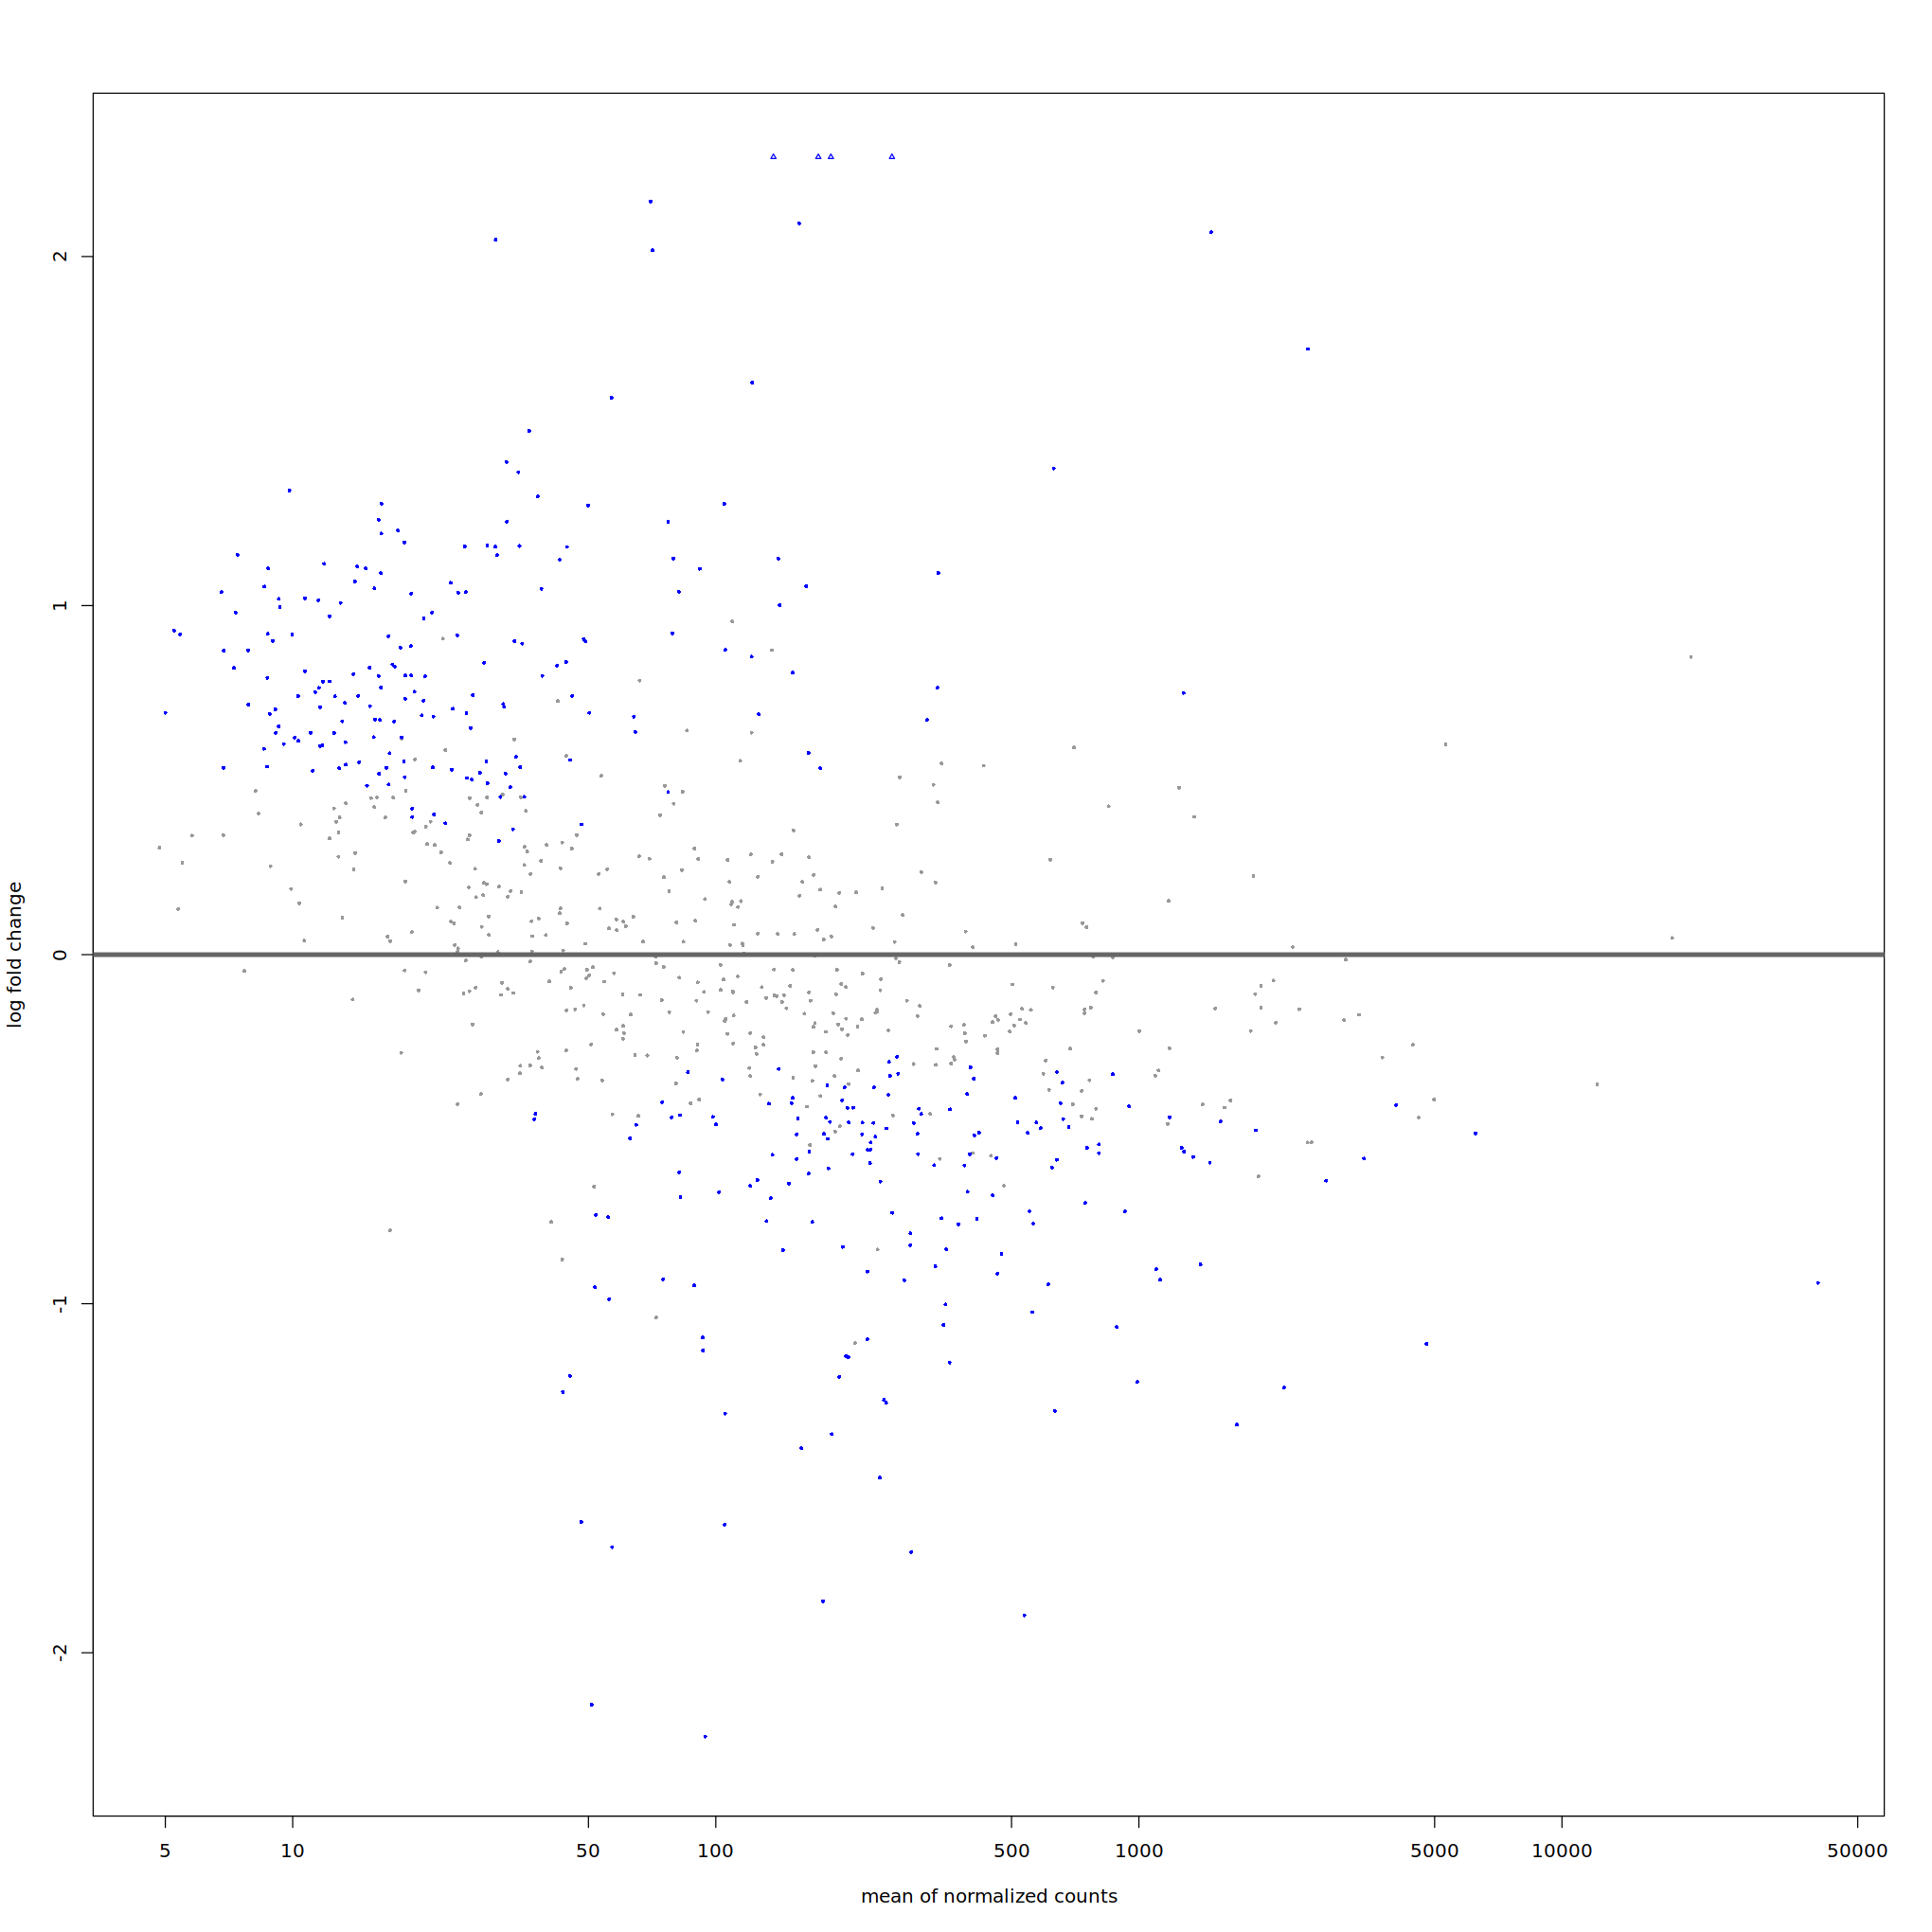

In [131]:
plotMA(de_dds2)

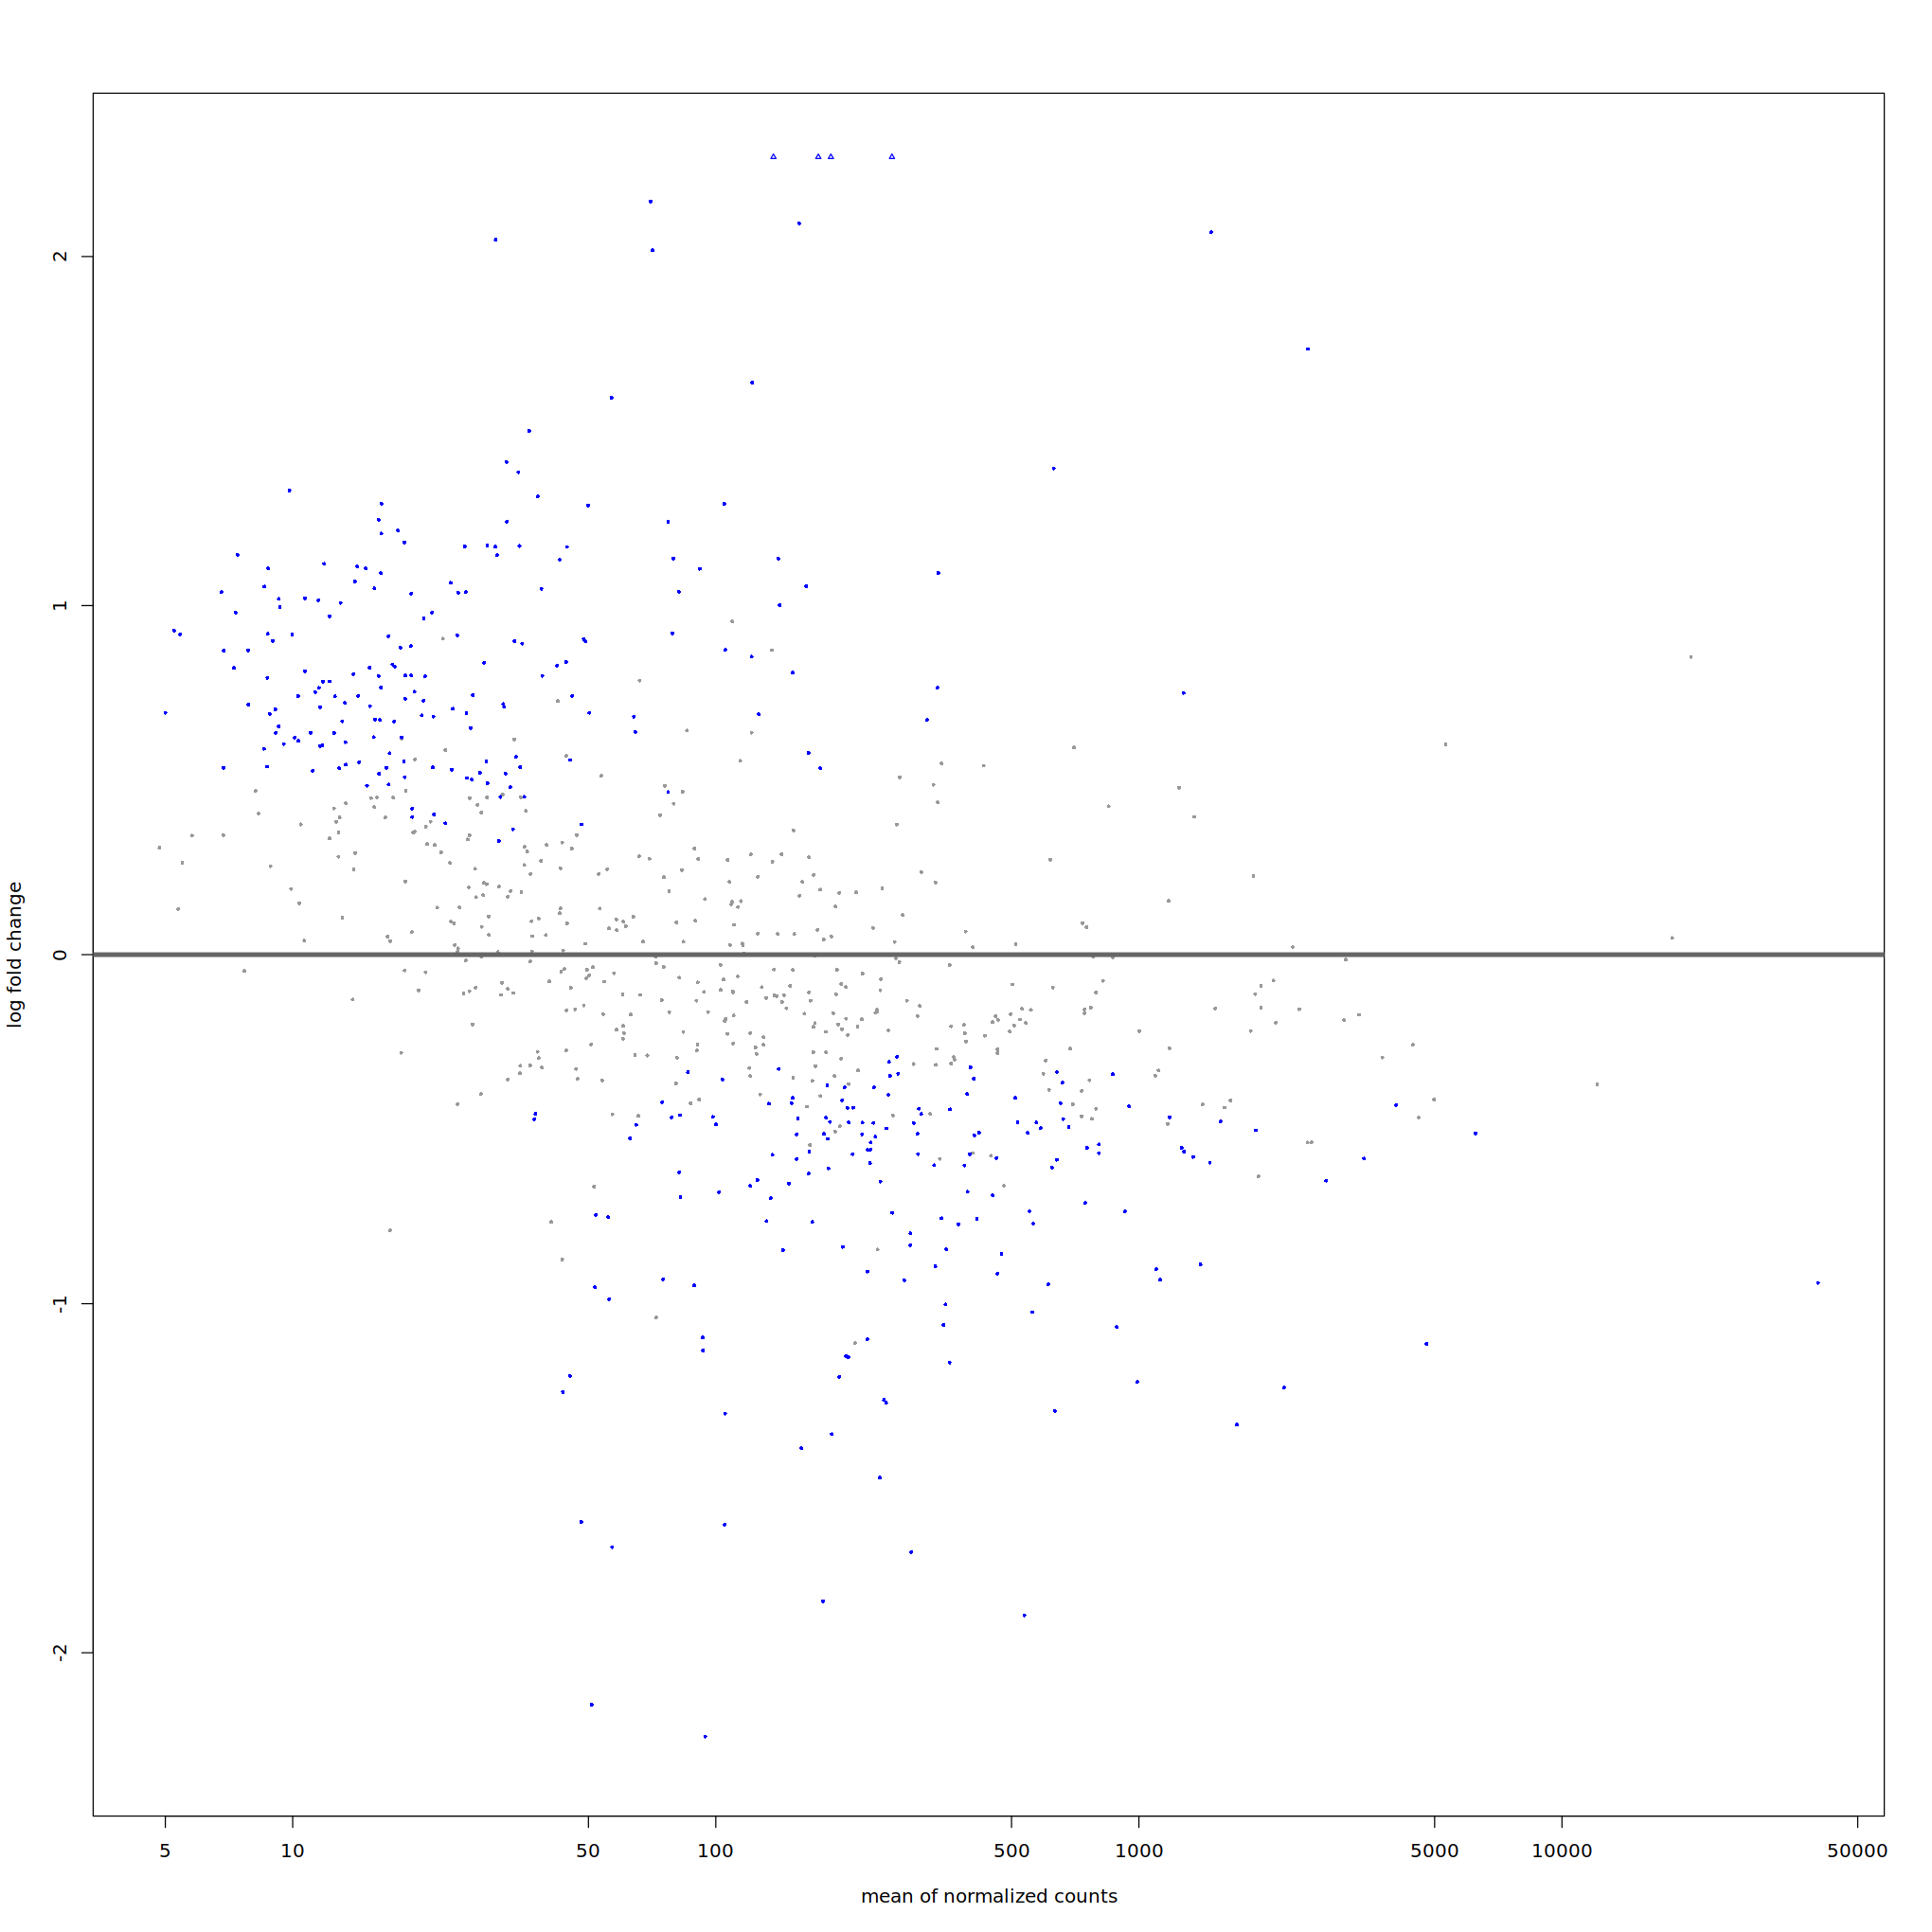

In [132]:
plotMA(results(de_dds2))

In [133]:
firstC <- 'SD'
SecondC <- 'PD'
contrast<- c("RECIST_response",firstC,SecondC)
res_deseq2 <- as.data.frame(results(de_dds2))
nam2 <- paste('up_in',firstC, sep = '_')

In [134]:
res_deseq2[, nam2] <- as.logical(res_deseq2$log2FoldChange > 0)

res_deseq2$threshold <- as.logical(res_deseq2$padj < 0.05) 
res_deseq2

baseMean   log2FoldChange lfcSE     stat        pvalue      
A2M     4780.73656 -1.115110813   0.4198187 -2.65617234 7.903321e-03
ABCB1     56.95062 -0.457724567   0.3946977 -1.15968400 2.461775e-01
ABL1     495.43386 -0.220363452   0.2438833 -0.90356122 3.662281e-01
ADA       78.60051 -0.466252241   0.2028976 -2.29796769 2.156363e-02
ADORA2A   34.50241  0.537251264   0.2423815  2.21655247 2.665369e-02
AICDA     16.21358  1.291657925   0.2743352  4.70831976 2.497671e-06
AIRE      23.75232  0.530043163   0.2512030  2.11001915 3.485671e-02
AKT3     868.81176 -0.007535277   0.3420137 -0.02203209 9.824224e-01
ALCAM    306.01394  0.236578114   0.4050455  0.58407794 5.591679e-01
AMBP     260.82860  4.058066959   0.8786232  4.61866594 3.862151e-06
AMICA1   165.98874  0.279130369   0.2123908  1.31422987 1.887689e-01
ANP32B   572.66520 -0.480939674   0.1667338 -2.88447682 3.920646e-03
ANXA1   3761.75456 -0.294679927   0.3292803 -0.89492128 3.708292e-01
APOE    1413.92604 -0.429016271   0.3845096 -1.11574932 2.645295e-01
APP     3081.89250 -0.014465707   0.2629858 -0.05500565 9.561340e-01
ARG1      36.22625  1.500336323   0.6309865  2.37776306 1.741801e-02
ARG2      58.27736 -0.215512908   0.3374826 -0.63858968 5.230899e-01
ATF1     206.25945 -0.481151058   0.1487753 -3.23407988 1.220353e-03
ATF2     332.44293 -0.269952530   0.1704396 -1.58386078 1.132254e-01
ATG10     81.92209 -0.623637033   0.1471839 -4.23712717 2.263979e-05
ATG12     31.21771 -0.080262459   0.1957595 -0.41000540 6.818020e-01
ATG16L1  140.90114 -0.327237153   0.1182756 -2.76673317 5.662108e-03
ATG5     204.66125 -0.438613133   0.1948549 -2.25097324 2.438723e-02
ATG7     106.55695 -0.226705169   0.1216711 -1.86326300 6.242527e-02
ATM       16.00814  0.518290631   0.2035042  2.54682955 1.087065e-02
AXL      779.47722 -0.005925144   0.2666212 -0.02222308 9.822700e-01
BAGE      18.11677  0.619439214   0.3294186  1.88040125 6.005341e-02
BATF      23.53318  0.263089505   0.1812377  1.45162676 1.466054e-01
BAX      602.49082 -0.303408538   0.1892664 -1.60307640 1.089178e-01
BCL10    198.94364 -0.417187528   0.1505788 -2.77055984 5.596002e-03
⋮       ⋮          ⋮              ⋮         ⋮           ⋮           
DNAJC14   93.80740 -0.10701270    0.1335192 -0.8014778  4.228551e-01
EDC3     400.15896 -0.32286508    0.1311548 -2.4617103  1.382763e-02
EIF2B4   300.75048 -0.57163747    0.1109563 -5.1519134  2.578421e-07
ERCC3    139.34307 -0.11865362    0.1371213 -0.8653189  3.868638e-01
FCF1    1181.08823 -0.26823399    0.1358572 -1.9743813  4.833841e-02
G6PD     288.64423 -0.79836980    0.2103263 -3.7958627  1.471309e-04
GPATCH3   83.12804  0.24238397    0.1372691  1.7657576  7.743652e-02
GUSB     165.75873  0.57781186    0.2348005  2.4608629  1.386033e-02
HDAC3    232.42449 -0.53799489    0.1087979 -4.9449002  7.618288e-07
HPRT1    463.55184 -0.91384655    0.1847055 -4.9475865  7.513932e-07
MRPS5    398.68656 -0.57153437    0.1455589 -3.9264815  8.619750e-05
MTMR14   268.20157 -0.29263392    0.1254951 -2.3318348  1.970938e-02
NOL7     232.23795 -0.55855177    0.1470993 -3.7971079  1.463941e-04
NUBP1     62.71533 -0.52618153    0.1144842 -4.5961053  4.304613e-06
POLR2A   769.81552 -0.15181094    0.1895097 -0.8010722  4.230899e-01
PPIA     195.86875  0.17675847    0.1762899  1.0026578  3.160260e-01
PRPF38A  393.49907 -0.67937604    0.1397025 -4.8630186  1.156090e-06
SAP130   231.41909 -0.59738878    0.1311056 -4.5565472  5.200135e-06
SDHA     276.79191  0.11311809    0.2061393  0.5487458  5.831799e-01
SF3A3    687.65150 -0.26967842    0.1728338 -1.5603342  1.186809e-01
TBP      197.77961 -0.29834110    0.1517576 -1.9659057  4.930951e-02
TLK2     240.07194 -0.15819865    0.1515391 -1.0439461  2.965103e-01
TMUB2    162.04067 -0.16925493    0.1106932 -1.5290457  1.262531e-01
TRIM39    60.37809 -0.20448861    0.1454225 -1.4061686  1.596741e-01
TUBB    1398.25993 -0.88772512    0.1982773 -4.4771904  7.563178e-06
USP39    101.86143 -0.68048677    0.1571612 -4.3298660  1.492001e-05
ZC3H14

In [135]:
res_valcanoplot2 <- results(de_dds2)
res_valcanoplot2

log2 fold change (MLE): RECIST response SD vs PD 
Wald test p-value: RECIST response SD vs PD 
DataFrame with 770 rows and 6 columns
         baseMean log2FoldChange     lfcSE      stat     pvalue        padj
        <numeric>      <numeric> <numeric> <numeric>  <numeric>   <numeric>
A2M     4780.7366      -1.115111  0.419819 -2.656172 0.00790332   0.0276616
ABCB1     56.9506      -0.457725  0.394698 -1.159684 0.24617749   0.3638324
ABL1     495.4339      -0.220363  0.243883 -0.903561 0.36622811   0.4964712
ADA       78.6005      -0.466252  0.202898 -2.297968 0.02156363   0.0570584
ADORA2A   34.5024       0.537251  0.242381  2.216552 0.02665369   0.0670697
...           ...            ...       ...       ...        ...         ...
USP39    101.8614     -0.6804868  0.157161 -4.329866 0.00001492 0.000273533
ZC3H14   357.7481     -0.4434777  0.146979 -3.017292 0.00255044 0.011689500
ZKSCAN5   58.3676      0.0699423  0.125220  0.558555 0.57646558 0.700123813
ZNF143    90.0318     -0.132004

In [52]:
lvl

ERROR: Error in eval(expr, envir, enclos): object 'lvl' not found


In [136]:
norm_mean_w2 <- sapply(levels(de_dds2$RECIST_response), function(lvl) rowMeans( counts(de_dds2,normalized=TRUE)[,de_dds2$RECIST_response == lvl, drop=F] ) )
norm_mean_w2

PD          SD        
A2M     6342.845705 2934.60758
ABCB1     66.259471   45.94924
ABL1     513.717217  473.82626
ADA       88.585095   66.80055
ADORA2A   29.074102   40.91767
AICDA      9.545459   24.09408
AIRE      19.229423   29.09755
AKT3     891.774614  841.67384
ALCAM    272.726799  345.35328
AMBP     114.943541  433.23821
AMICA1   152.749977  181.63455
ANP32B   643.949601  488.42000
ANXA1   4119.114584 3339.41999
APOE    1610.511780 1181.59745
APP     3103.530979 3056.31976
ARG1      27.484827   46.55701
ARG2      62.864404   52.85631
ATF1     237.212651  169.67841
ATF2     350.883523  310.64950
ATG10     95.337057   66.06804
ATG12     30.185187   32.43796
ATG16L1  153.652563  125.83128
ATG5     225.844035  179.62705
ATG7     113.043065   98.89154
ATM       12.675798   19.94637
AXL      775.692967  783.94953
BAGE      13.883925   23.11922
BATF      21.666657   25.73906
BAX      655.771750  539.52244
BCL10    224.613330  168.60674
⋮       ⋮           ⋮         
DNAJC14   96.12860    91.06416
EDC3     427.72872   367.57650
EIF2B4   349.41378   243.23931
ERCC3    143.45281   134.48611
FCF1    1243.74877  1107.03487
G6PD     356.36232   208.61377
GPATCH3   75.41980    92.23776
GUSB     134.84715   202.29060
HDAC3    264.94698   193.98881
HPRT1    590.98765   312.94587
MRPS5    460.56844   325.55342
MTMR14   286.63407   246.41771
NOL7     270.57430   186.93136
NUBP1     72.34805    51.33120
POLR2A   797.40137   737.21406
PPIA     171.98325   224.09707
PRPF38A  463.98713   310.19499
SAP130   272.62301   182.72356
SDHA     265.42399   290.22673
SF3A3    730.13520   637.44350
TBP      212.21811   180.71593
TLK2     246.16126   232.87547
TMUB2    168.34680   154.58797
TRIM39    64.05040    56.03808
TUBB    1740.53551   993.75243
USP39    122.75539    77.16858
ZC3H14   398.66957   309.38631
ZKSCAN5   56.47281    60.60689
ZNF143    93.23973    86.24057
ZNF346   118.00103   134.98424

In [137]:
function(lvl) counts(de_dds2,normalized=TRUE)[,de_dds2$RECIST_response == lvl, drop=F]

function(lvl) counts(de_dds2,normalized=TRUE)[,de_dds2$RECIST_response == lvl, drop=F]

In [138]:
norm_mean_w2_1 <- sapply(levels(de_dds2$RECIST_response), function(lvl) rowMeans( counts(de_dds2,normalized=FALSE)[,de_dds2$RECIST_response == lvl, drop=F] ) )
norm_mean_w2_1

PD         SD        
A2M     9755.96154 2128.00000
ABCB1    179.19231   33.86364
ABL1     764.03846  426.45455
ADA      149.34615   57.36364
ADORA2A   45.84615   33.36364
AICDA     13.34615   16.68182
AIRE      24.96154   16.68182
AKT3    1324.53846  777.68182
ALCAM    469.11538  494.27273
AMBP     142.69231  428.27273
AMICA1   280.42308  134.18182
ANP32B  1037.30769  446.86364
ANXA1   6994.57692 2886.77273
APOE    2592.07692 1321.72727
APP     4897.88462 2651.81818
ARG1      34.80769   42.77273
ARG2      87.11538   45.95455
ATF1     378.38462  156.40909
ATF2     578.53846  310.59091
ATG10    150.03846   60.27273
ATG12     48.76923   24.68182
ATG16L1  253.92308  114.22727
ATG5     380.46154  216.72727
ATG7     183.34615   88.40909
ATM       19.00000   13.59091
AXL     1177.26923  640.22727
BAGE      16.46154   15.04545
BATF      34.80769   18.31818
BAX     1084.07692  516.50000
BCL10    364.34615  139.95455
⋮       ⋮          ⋮         
DNAJC14  156.80769   83.63636
EDC3     677.96154  326.81818
EIF2B4   575.03846  208.45455
ERCC3    224.88462  125.72727
FCF1    1943.07692  976.31818
G6PD     546.11538  176.90909
GPATCH3  104.69231   65.95455
GUSB     224.65385  157.22727
HDAC3    416.03846  175.00000
HPRT1    926.76923  257.72727
MRPS5    783.23077  309.81818
MTMR14   457.42308  241.86364
NOL7     474.61538  167.72727
NUBP1    120.07692   43.81818
POLR2A  1309.50000  786.27273
PPIA     267.00000  187.95455
PRPF38A  789.15385  292.27273
SAP130   433.38462  171.04545
SDHA     416.07692  261.40909
SF3A3   1072.03846  539.63636
TBP      362.92308  167.36364
TLK2     394.23077  215.59091
TMUB2    267.38462  134.50000
TRIM39   101.42308   47.00000
TUBB    3028.92308 1000.77273
USP39    207.80769   68.36364
ZC3H14   635.80769  279.04545
ZKSCAN5   87.69231   50.77273
ZNF143   152.65385   73.90909
ZNF346   208.53846  125.63636

In [139]:
colnames(norm_mean_w2) <- paste('Rowmean_exp_',levels(de_dds2$RECIST_response),sep='')

res2 <- cbind(norm_mean_w2,res_deseq2)

In [140]:
dim(res_deseq2)

[1] 770   8

In [141]:
res_deseq2

baseMean   log2FoldChange lfcSE     stat        pvalue      
A2M     4780.73656 -1.115110813   0.4198187 -2.65617234 7.903321e-03
ABCB1     56.95062 -0.457724567   0.3946977 -1.15968400 2.461775e-01
ABL1     495.43386 -0.220363452   0.2438833 -0.90356122 3.662281e-01
ADA       78.60051 -0.466252241   0.2028976 -2.29796769 2.156363e-02
ADORA2A   34.50241  0.537251264   0.2423815  2.21655247 2.665369e-02
AICDA     16.21358  1.291657925   0.2743352  4.70831976 2.497671e-06
AIRE      23.75232  0.530043163   0.2512030  2.11001915 3.485671e-02
AKT3     868.81176 -0.007535277   0.3420137 -0.02203209 9.824224e-01
ALCAM    306.01394  0.236578114   0.4050455  0.58407794 5.591679e-01
AMBP     260.82860  4.058066959   0.8786232  4.61866594 3.862151e-06
AMICA1   165.98874  0.279130369   0.2123908  1.31422987 1.887689e-01
ANP32B   572.66520 -0.480939674   0.1667338 -2.88447682 3.920646e-03
ANXA1   3761.75456 -0.294679927   0.3292803 -0.89492128 3.708292e-01
APOE    1413.92604 -0.429016271   0.3845096 -1.11574932 2.645295e-01
APP     3081.89250 -0.014465707   0.2629858 -0.05500565 9.561340e-01
ARG1      36.22625  1.500336323   0.6309865  2.37776306 1.741801e-02
ARG2      58.27736 -0.215512908   0.3374826 -0.63858968 5.230899e-01
ATF1     206.25945 -0.481151058   0.1487753 -3.23407988 1.220353e-03
ATF2     332.44293 -0.269952530   0.1704396 -1.58386078 1.132254e-01
ATG10     81.92209 -0.623637033   0.1471839 -4.23712717 2.263979e-05
ATG12     31.21771 -0.080262459   0.1957595 -0.41000540 6.818020e-01
ATG16L1  140.90114 -0.327237153   0.1182756 -2.76673317 5.662108e-03
ATG5     204.66125 -0.438613133   0.1948549 -2.25097324 2.438723e-02
ATG7     106.55695 -0.226705169   0.1216711 -1.86326300 6.242527e-02
ATM       16.00814  0.518290631   0.2035042  2.54682955 1.087065e-02
AXL      779.47722 -0.005925144   0.2666212 -0.02222308 9.822700e-01
BAGE      18.11677  0.619439214   0.3294186  1.88040125 6.005341e-02
BATF      23.53318  0.263089505   0.1812377  1.45162676 1.466054e-01
BAX      602.49082 -0.303408538   0.1892664 -1.60307640 1.089178e-01
BCL10    198.94364 -0.417187528   0.1505788 -2.77055984 5.596002e-03
⋮       ⋮          ⋮              ⋮         ⋮           ⋮           
DNAJC14   93.80740 -0.10701270    0.1335192 -0.8014778  4.228551e-01
EDC3     400.15896 -0.32286508    0.1311548 -2.4617103  1.382763e-02
EIF2B4   300.75048 -0.57163747    0.1109563 -5.1519134  2.578421e-07
ERCC3    139.34307 -0.11865362    0.1371213 -0.8653189  3.868638e-01
FCF1    1181.08823 -0.26823399    0.1358572 -1.9743813  4.833841e-02
G6PD     288.64423 -0.79836980    0.2103263 -3.7958627  1.471309e-04
GPATCH3   83.12804  0.24238397    0.1372691  1.7657576  7.743652e-02
GUSB     165.75873  0.57781186    0.2348005  2.4608629  1.386033e-02
HDAC3    232.42449 -0.53799489    0.1087979 -4.9449002  7.618288e-07
HPRT1    463.55184 -0.91384655    0.1847055 -4.9475865  7.513932e-07
MRPS5    398.68656 -0.57153437    0.1455589 -3.9264815  8.619750e-05
MTMR14   268.20157 -0.29263392    0.1254951 -2.3318348  1.970938e-02
NOL7     232.23795 -0.55855177    0.1470993 -3.7971079  1.463941e-04
NUBP1     62.71533 -0.52618153    0.1144842 -4.5961053  4.304613e-06
POLR2A   769.81552 -0.15181094    0.1895097 -0.8010722  4.230899e-01
PPIA     195.86875  0.17675847    0.1762899  1.0026578  3.160260e-01
PRPF38A  393.49907 -0.67937604    0.1397025 -4.8630186  1.156090e-06
SAP130   231.41909 -0.59738878    0.1311056 -4.5565472  5.200135e-06
SDHA     276.79191  0.11311809    0.2061393  0.5487458  5.831799e-01
SF3A3    687.65150 -0.26967842    0.1728338 -1.5603342  1.186809e-01
TBP      197.77961 -0.29834110    0.1517576 -1.9659057  4.930951e-02
TLK2     240.07194 -0.15819865    0.1515391 -1.0439461  2.965103e-01
TMUB2    162.04067 -0.16925493    0.1106932 -1.5290457  1.262531e-01
TRIM39    60.37809 -0.20448861    0.1454225 -1.4061686  1.596741e-01
TUBB    1398.25993 -0.88772512    0.1982773 -4.4771904  7.563178e-06
USP39    101.86143 -0.68048677    0.1571612 -4.3298660  1.492001e-05
ZC3H14

In [142]:
top_de_genes2 = res2[row.names(res_deseq2)[which(res_deseq2$threshold)],]
top_de_genes2

Rowmean_exp_PD Rowmean_exp_SD baseMean    log2FoldChange lfcSE    
A2M       6342.845705    2934.607578    4780.736563 -1.1151108     0.4198187
AICDA        9.545459      24.094082      16.213578  1.2916579     0.2743352
AMBP       114.943541     433.238211     260.828598  4.0580670     0.8786232
ANP32B     643.949601     488.419999     572.665200 -0.4809397     0.1667338
ARG1        27.484827      46.557015      36.226246  1.5003363     0.6309865
ATF1       237.212651     169.678405     206.259455 -0.4811511     0.1487753
ATG10       95.337057      66.068042      81.922092 -0.6236370     0.1471839
ATG16L1    153.652563     125.831278     140.901141 -0.3272372     0.1182756
ATM         12.675798      19.946368      16.008143  0.5182906     0.2035042
BCL10      224.613330     168.606737     198.943642 -0.4171875     0.1505788
BID         12.039131      23.777246      17.419101  0.8257252     0.1838329
BIRC5      219.302616      88.278159     159.249740 -1.4142071     0.3449615
BLK          4.939744       9.160312       6.874171  0.8712044     0.3250001
BMI1       260.854745     190.534635     228.624695 -0.5597554     0.1642777
BST2       415.238125     229.780985     330.236935 -0.8930923     0.3034375
C1QBP      715.465016     513.880840     623.072269 -0.6102105     0.2176338
C2         182.269895     109.564567     148.946620 -0.6558164     0.2546108
CAMP         9.200464      15.774189      12.213421  0.7827310     0.2705136
CASP3       99.925971      61.934173      82.513063 -0.6947249     0.2117773
CASP8      271.072324     194.203691     235.840867 -0.4816371     0.1982062
CCL1         6.911340      11.089824       8.826479  0.6899922     0.2588895
CCL15        6.281533      11.614194       8.725669  0.9191797     0.2391210
CCL20       31.925233      58.838544      44.260501  0.8385745     0.2522200
CCL22        9.920499      16.842022      13.092863  0.6684988     0.1973817
CCL24        3.816184       7.304382       5.414941  0.9172417     0.3075715
CCL25       11.182101      26.850855      18.363613  1.1808279     0.2357234
CCL7        10.744830      22.555960      16.158265  1.0931166     0.2495258
CCND3      290.967855     154.093092     228.233589 -0.9077736     0.2245540
CCR1        76.048948      51.574848      64.831652 -0.4872428     0.2045139
CCR3         5.985779      14.355393       9.821852  1.3298877     0.2803766
⋮         ⋮              ⋮              ⋮           ⋮              ⋮        
TNFRSF13B    5.808270     13.35800         9.268562  1.0189795     0.2422785
TNFRSF14   180.292174    128.10596       156.373494 -0.4695904     0.1992563
TNFRSF4     35.526840     65.47259        49.251977  0.8972986     0.3008963
TNFSF10    469.176274    262.57573       374.484358 -0.7721694     0.3115726
TNFSF14     27.330953     61.02040        42.771948  1.1315451     0.3616660
TNFSF18      7.667897     16.01676        11.494457  1.0151617     0.2505559
TNFSF4      47.552826    112.11095        77.141968  1.2397836     0.3184993
TNFSF8      18.026135     25.80451        21.591224  0.4017939     0.1582003
TREM2       69.600258     39.24010        55.685187 -0.7521107     0.2811662
TTK        145.648452     57.26354       105.138703 -1.3151869     0.3145571
TXK         13.543626     21.88261        17.365662  0.6675937     0.2491714
VCAM1      464.049192    205.01771       345.326429 -1.0608202     0.4130267
XCR1        22.967486     45.78854        33.427134  0.8979337     0.1739945
ZAP70       39.384155     52.13256        45.227174  0.5576656     0.1974442
ABCF1      334.025920    246.16069       293.754357 -0.4826839     0.1665301
CNOT10     201.979886    167.35410       186.109735 -0.4789009     0.1594916
EDC3       427.728724    367.57650       400.158956 -0.3228651     0.1311548
EIF2B4     349.413784    243.23931       300.750485 -0.5716375     0.1109563
G6PD       356.362319    208.61377       288.644234 -0.7983698     0.2103263
GUSB       134.847147    202.29060       165.758729  0.5778119     0.2348005
HDAC3 

In [91]:
write.csv(top_de_genes2, file = '0729_DEseq2_DGE_RECIST_response_PD_vs_SD.csv')

In [63]:
# ANP32B
print(log2(488.419999/643.949601))
print(log2(446.86364/1037.30769))
print(log2(488.419999/572.665200))

[1] -0.3988255
[1] -1.214937
[1] -0.2295697


In [49]:
# AMBP
print(log2(433.238211/114.943541))
# AMBP
print(log2(428.27273/142.69231))
print((2934.607578+ 6342.845705)/2)

[1] 1.914235
[1] 1.585622
[1] 4638.727


In [47]:
# A2M
print(log2(2934.607578/6342.845705))
# A2M
log2(2128.00000/9755.96154)

[1] -1.111963


[1] -2.196786

In [50]:
# AICDA
log2(24.094082/9.545459)
print((24.094082+ 9.545459)/2)

[1] 1.335792

[1] 16.81977


In [41]:
# ATF1
log2(169.678405/237.212651)

[1] -0.483378

In [143]:
options(repr.plot.width=17, repr.plot.height=17)
# pdf("05_PS_vs_SD_volcano_plot.pdf")
# jpeg('01_SD_vs_PD_volcano_plot.jpg')
sdvspd_volplot2 <- EnhancedVolcano(res_valcanoplot2,
                lab = rownames(res_valcanoplot2), selectLab = row.names(top_de_genes2),
                x = 'log2FoldChange',
                y = 'pvalue', title = 'Diagnosis PD vs SD',
                pCutoff = 0.01, drawConnectors = FALSE,max.overlaps = 30,
                FCcutoff = 0.58,
                pointSize = 2.0,
                labSize = 6.0)
dev.off()
sdvspd_volplot2

null device 
          1

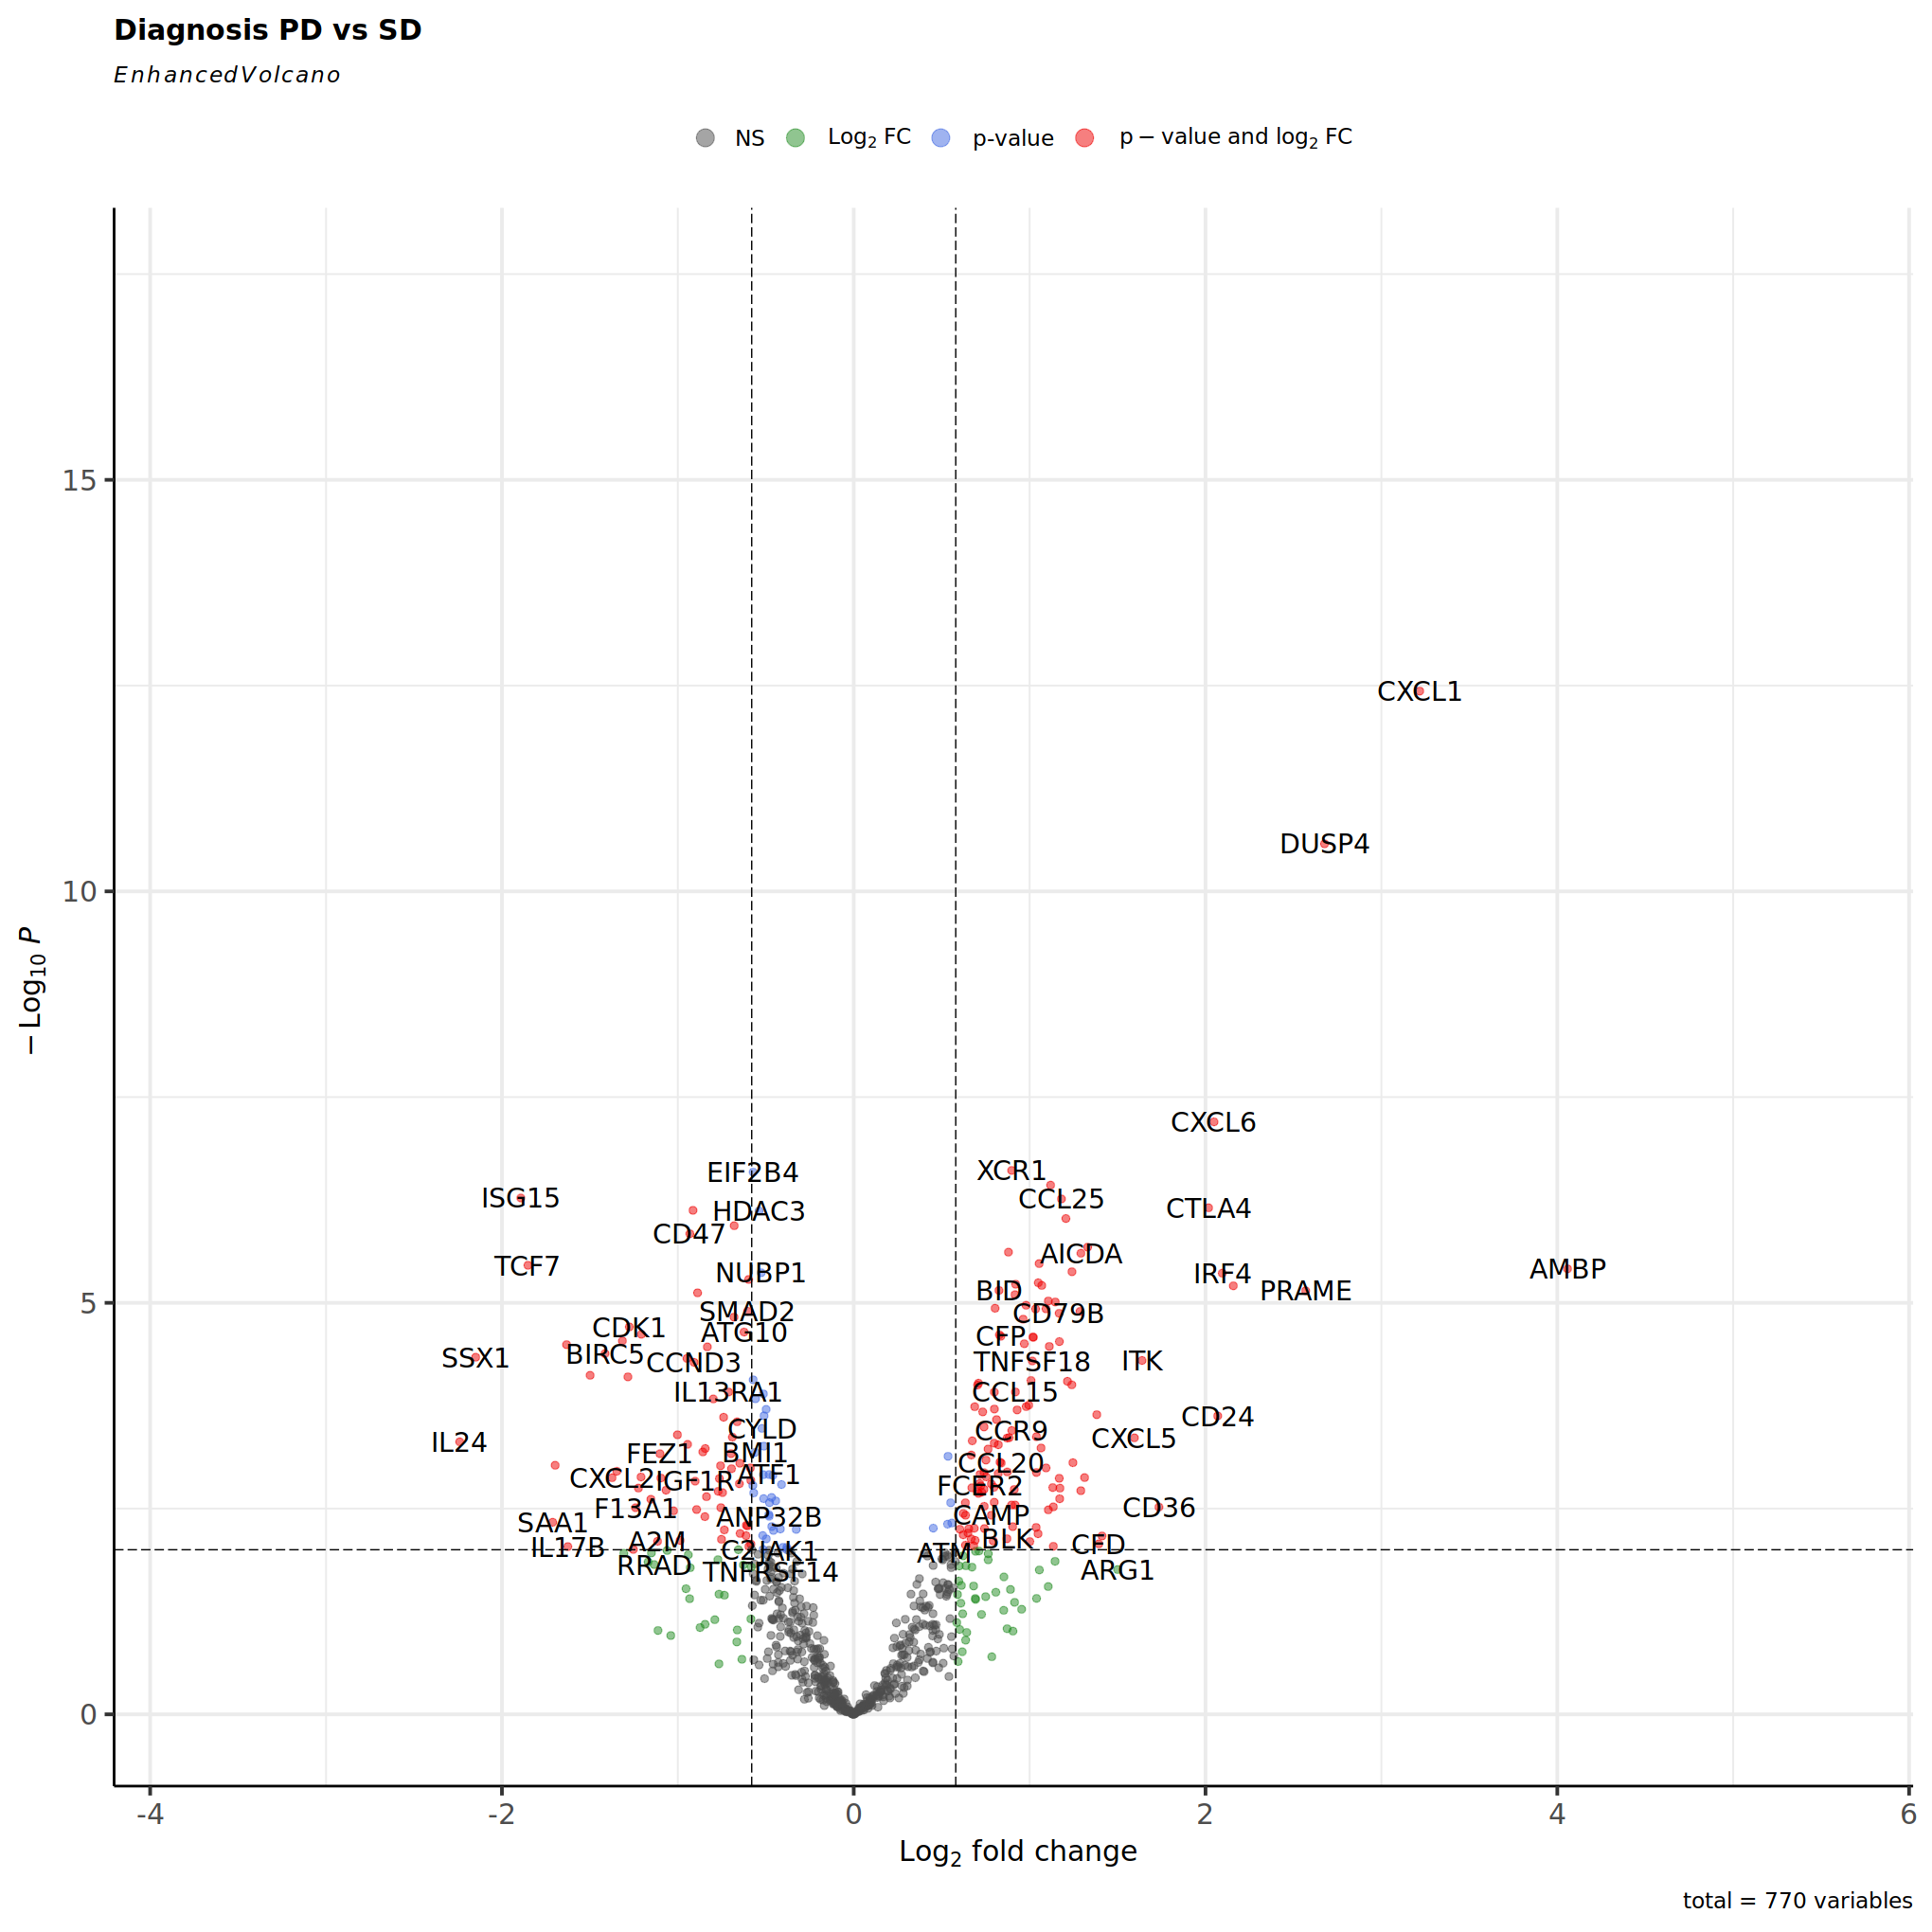

In [144]:
sdvspd_volplot2

In [145]:
ggsave("05_RECIST_response_PD_vs_SD_volcano_plot.pdf", 
       width = 10,
       height = 10, sdvspd_volplot2)

In [146]:
goi2 = c('CXCL1', 'DUSP4', 'CXCL6')
goi2

[1] "CXCL1" "DUSP4" "CXCL6"

In [147]:
tcounts2 <- t(log2((counts(de_dds2[goi2, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(de_dds2), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi2)+1):ncol(.))

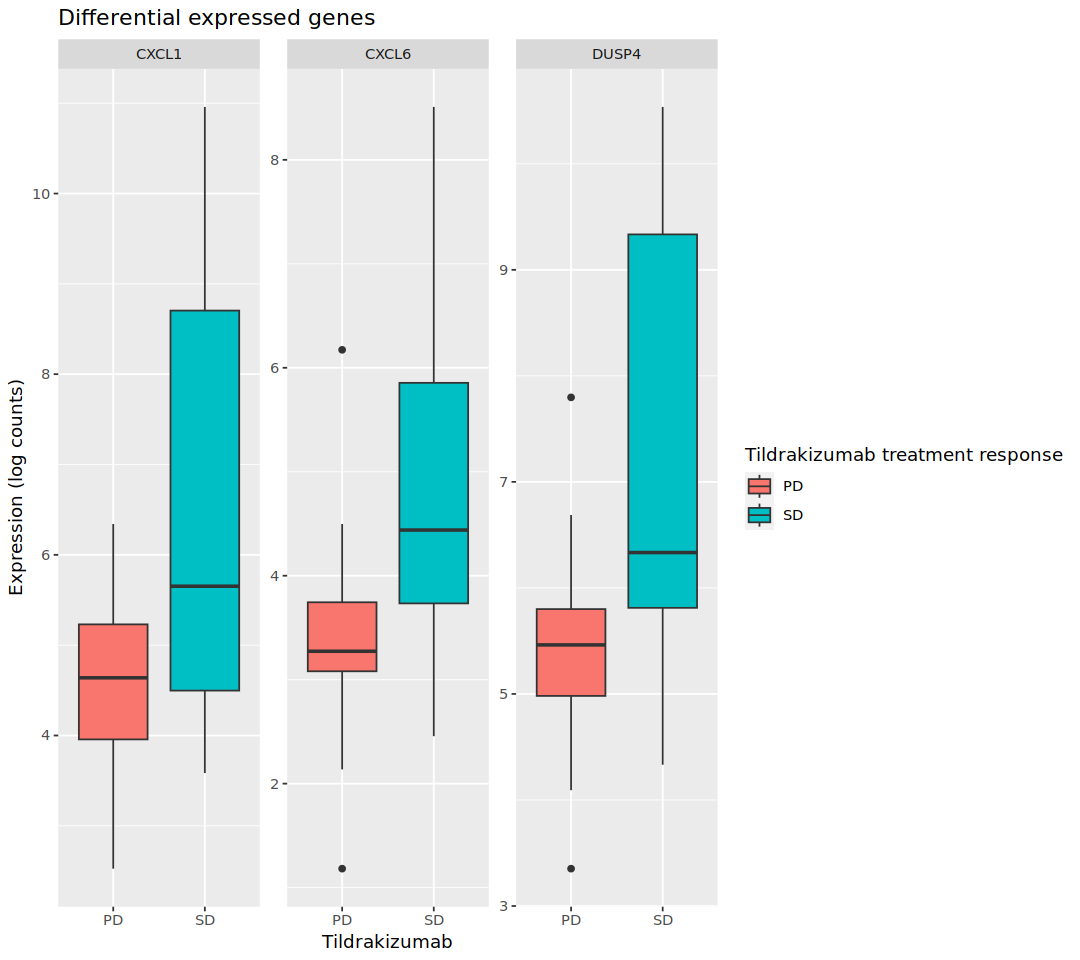

In [96]:
options(repr.plot.width=9, repr.plot.height=8)
sd_boxplot = ggplot(tcounts2, aes(RECIST_response, expression, fill=RECIST_response)) + 
  geom_boxplot() + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab treatment response", 
       title="Differential expressed genes")
sd_boxplot

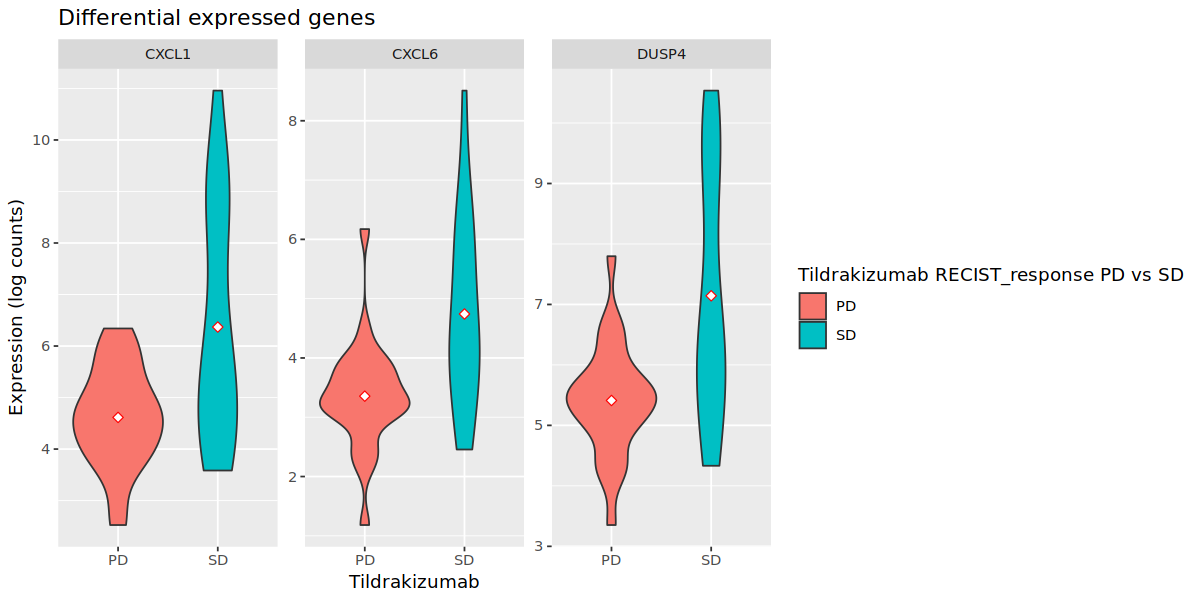

In [148]:
options(repr.plot.width=10, repr.plot.height=5)
# pdf("05_PD_vs_SD_violin_plot.pdf")
sd_boxplot2 = ggplot(tcounts2, aes(RECIST_response, expression, fill=RECIST_response)) + 
  geom_violin() + 
  stat_summary(fun = mean, geom = "point", shape = 23, size = 2, color = "red", fill = "white") + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab RECIST_response PD vs SD", 
       title="Differential expressed genes")
# dev.off()
sd_boxplot2

In [149]:
ggsave("05_PD_vs_SD_violin_plot.pdf", 
       width = 10,
       height = 10, sd_boxplot2)

In [92]:
goi3 = c('EIF2B4', 'HDAC3', 'CD47')
goi3

[1] "EIF2B4" "HDAC3"  "CD47"

In [93]:
tcounts3 <- t(log2((counts(de_dds2[goi3, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(de_dds2), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi3)+1):ncol(.))

png 
  2

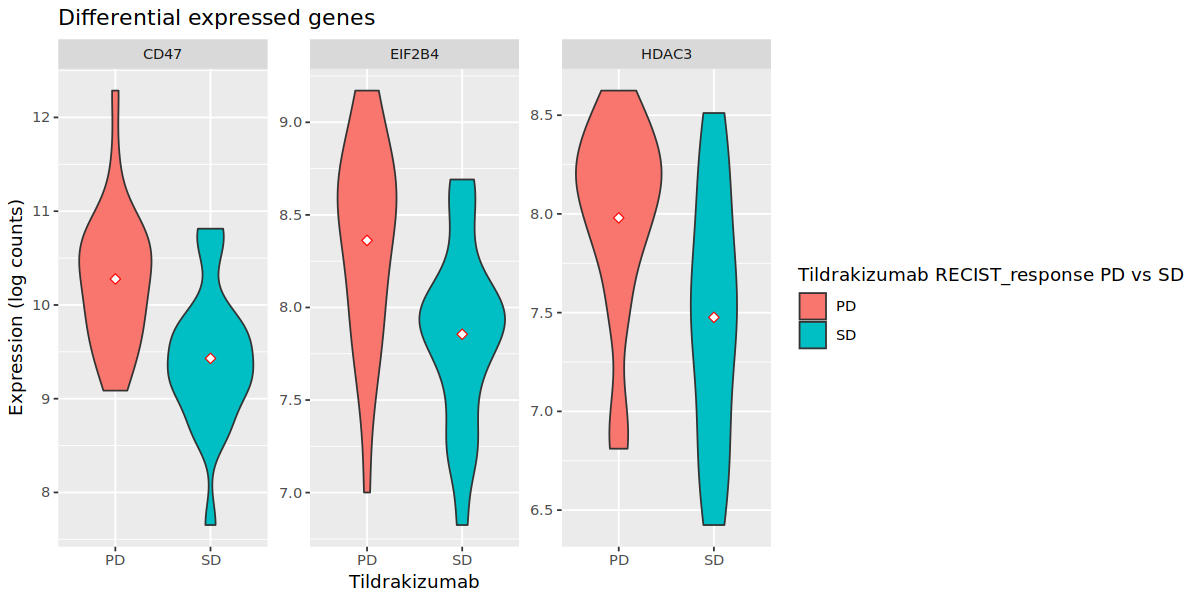

In [94]:
options(repr.plot.width=10, repr.plot.height=5)
pdf("05_PD_vs_SD_violin_plot2.pdf")
sd_boxplot2 = ggplot(tcounts3, aes(RECIST_response, expression, fill=RECIST_response)) + 
  geom_violin() + 
  stat_summary(fun = mean, geom = "point", shape = 23, size = 2, color = "red", fill = "white") + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab RECIST_response PD vs SD", 
       title="Differential expressed genes")
dev.off()
sd_boxplot2

In [157]:
sorted_top_de2 = top_de_genes2[order(top_de_genes2$up_in_SD==FALSE, top_de_genes2$padj),]
sorted_top_de2

Rowmean_exp_PD Rowmean_exp_SD baseMean   
CXCL1                      29.542193     263.66985      136.850704 
DUSP4                      51.748470     346.99450      187.069567 
CXCL6                      12.342079      51.27702       30.187262 
XCR1                       22.967486      45.78854       33.427134 
IL21                        7.360729      17.18609       11.864018 
CCL25                      11.182101      26.85085       18.363613 
CTLA4                      32.231651     116.52207       70.864758 
IL4                         9.764453      23.78603       16.191010 
CCR3                        5.985779      14.35539        9.821852 
AICDA                       9.545459      24.09408       16.213578 
IL22RA2                    12.696567      24.22853       17.982052 
PASD1                       5.523314      12.17891        8.573796 
AMBP                      114.943541     433.23821      260.828598 
IRF4                       57.568639     275.25120      157.339812 
MBL2                       19.622518      46.77472       32.067278 
KIR3DL3                     8.990314      19.99237       14.032923 
LY9                        55.874524     106.26601       78.970621 
SEMG1                      10.463292      21.68277       15.605555 
SERPINB2                   22.360040     126.62692       70.149029 
BID                        12.039131      23.77725       17.419101 
PRAME                      31.947910     343.43645      174.713489 
DEFB1                       7.091766      13.37880        9.973325 
CTAGE1                      5.612828      12.47755        8.759159 
IL2                         4.502868      10.82264        7.399429 
IFNG                       14.317695      29.65770       21.348531 
CCL7                       10.744830      22.55596       16.158265 
IFNA7                      12.498745      26.79571       19.051518 
KIR_Inhibiting_Subgroup_2  10.047126      18.48325       13.913683 
TNFRSF10C                  27.880826      75.99929       49.935121 
CD79B                      28.762579      63.07930       44.491078 
⋮                         ⋮              ⋮              ⋮          
IRF7                        180.85123      125.17663      155.33371
MAGEC2                       58.90591       25.37077       43.53564
MIF                        1577.18009     1067.37541     1343.51961
PIN1                        223.50920      175.34095      201.43208
CD4                         267.82186      168.03080      222.08429
VCAM1                       464.04919      205.01771      345.32643
JAK1                        734.55615      570.10473      659.18259
CD74                       4759.88741     3220.47594     4054.32382
MAPK14                      452.07014      354.52816      407.36340
MME                         275.42097      117.93197      203.23851
CYFIP2                      877.57562      344.07185      633.05306
PSMD7                       939.46624      645.85386      804.89390
COL3A1                    47978.36392    31151.38156    40265.99700
SYK                         117.23818       79.97654      100.15993
TNFSF10                     469.17627      262.57573      374.48436
CD68                        610.62279      405.92087      516.80108
EDC3                        427.72872      367.57650      400.15896
NCAM1                       480.36068      210.81206      356.81757
CTSS                        789.53801      511.60385      662.15152
NFKBIA                     1517.36383      998.25924     1279.44090
CASP8                       271.07232      194.20369      235.84087
RRAD                        120.04126       61.65199       93.27951
DDX58                       197.36852      128.18309      165.65853
HAVCR2                      115.10540       78.66360       98.40291
STAT1                       543.85219      362.46962      460.71851
LAMP3                       113.84887       29.24811       75.07352
GTF3C1                      337.27202      260.22259      301.95769
CCR1          

In [158]:
col_labels = as.data.frame(colData(de_dds2)[,c('pid',"Diagnosis","Conditions","RECIST_response")])
col_labels

pid   Diagnosis  Conditions          
20230616_210462891024_K1241-B_02.RCC  K1241  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K1628-B_03.RCC  K1628  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K1865-B_04.RCC  K1865  Baseline  Osteosarcoma        
20230616_210462891024_K2032-B_05.RCC  K2032  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K2068-B_06.RCC  K2068  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K2323-B_07.RCC  K2323  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K2360-B_08.RCC  K2360  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K2520-B_09.RCC  K2520  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K2669-B_10.RCC  K2669  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K2742-B_11.RCC  K2742  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K2849-B_12.RCC  K2849  Baseline  Osteosarcoma        
20230616_210462891024_K853-B_01.RCC   K853   Baseline  Osteosarcoma        
20230707_210462871024_K1241-Tx_09.RCC K1241  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K1628-Tx_10.RCC K1628  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K2032-Tx_11.RCC K2032  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K2360-Tx_12.RCC K2360  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K4106-B_01.RCC  K4106  Baseline  Osteosarcoma        
20230707_210462871024_K4196-B_02.RCC  K4196  Baseline  Osteosarcoma        
20230707_210462871024_K4258-B_03.RCC  K4258  Baseline  Osteosarcoma        
20230707_210462871024_K4307-B_04.RCC  K4307  Baseline  Osteosarcoma        
20230707_210462871024_K4360-B_05.RCC  K4360  Baseline  Osteosarcoma        
20230707_210462871024_K4368-B_06.RCC  K4368  Baseline  Soft Tissue Sarcoma 
20230707_210462871024_K5046-B_07.RCC  K5046  Baseline  Osteosarcoma        
20230707_210462871024_K853-Tx_08.RCC  K853   Treatment Osteosarcoma        
20230707_210462881024_K2894-B_01.RCC  K2894  Baseline  Osteosarcoma        
20230707_210462881024_K2917-B_02.RCC  K2917  Baseline  Soft Tissue Sarcoma 
20230707_210462881024_K3056-B_03.RCC  K3056  Baseline  Osteosarcoma        
20230707_210462881024_K3566-B_04.RCC  K3566  Baseline  Soft Tissue Sarcoma 
20230707_210462881024_K3812-B_05.RCC  K3812  Baseline  Soft Tissue Sarcoma 
20230707_210462881024_K3953-B_06.RCC  K3953  Baseline  Soft Tissue Sarcoma 
20230707_210462881024_K3975-B_07.RCC  K3975  Baseline  Osteosarcoma        
20230707_210462881024_K4010-B_08.RCC  K4010  Baseline  Osteosarcoma        
20230707_210462881024_K4020-B_09.RCC  K4020  Baseline  Osteosarcoma        
20230707_210462881024_K4023-B_10.RCC  K4023  Baseline  Osteosarcoma        
20230707_210462881024_K4054-B_11.RCC  K4054  Baseline  Osteosarcoma        
20230707_210462881024_K4093-B_12.RCC  K4093  Baseline  Soft Tissue Sarcoma 
20230707_210462901024_K2742-Tx_01.RCC K2742  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K2849-Tx_02.RCC K2849  Treatment Osteosarcoma        
20230707_210462901024_K2894-Tx_03.RCC K2894  Treatment Osteosarcoma        
20230707_210462901024_K2917-Tx_04.RCC K2917  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K3056-Tx_05.RCC K3056  Treatment Osteosarcoma        
20230707_210462901024_K3566-Tx_06.RCC K3566  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K3953-Tx_07.RCC K3953  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K3975-Tx_08.RCC K3975  Treatment Osteosarcoma        
20230707_210462901024_K4106-Tx_09.RCC K4106  Treatment Osteosarcoma        
20230707_210462901024_K4258-Tx_10.RCC K4258  Treatment Osteosarcoma        
20230707_210462901024_K4360-Tx_11.RCC K4360  Treatment Osteosarcoma        
20230707_210462901024_K4368-Tx_12.RCC K4368  Treatment Soft Tissue Sarcoma 
                                      RECIST_response
20230616_210462891024_K1241-B_02.RCC  SD             
20230616_210462891024_K1628-B_03.RCC  PD             
20230616_210462891024_K1865-B_04.RCC  PD             
20230616_210462891024_K2032-B_05.RCC  PD             
20230616_210462891024_K2068-B_06.RCC  PD    

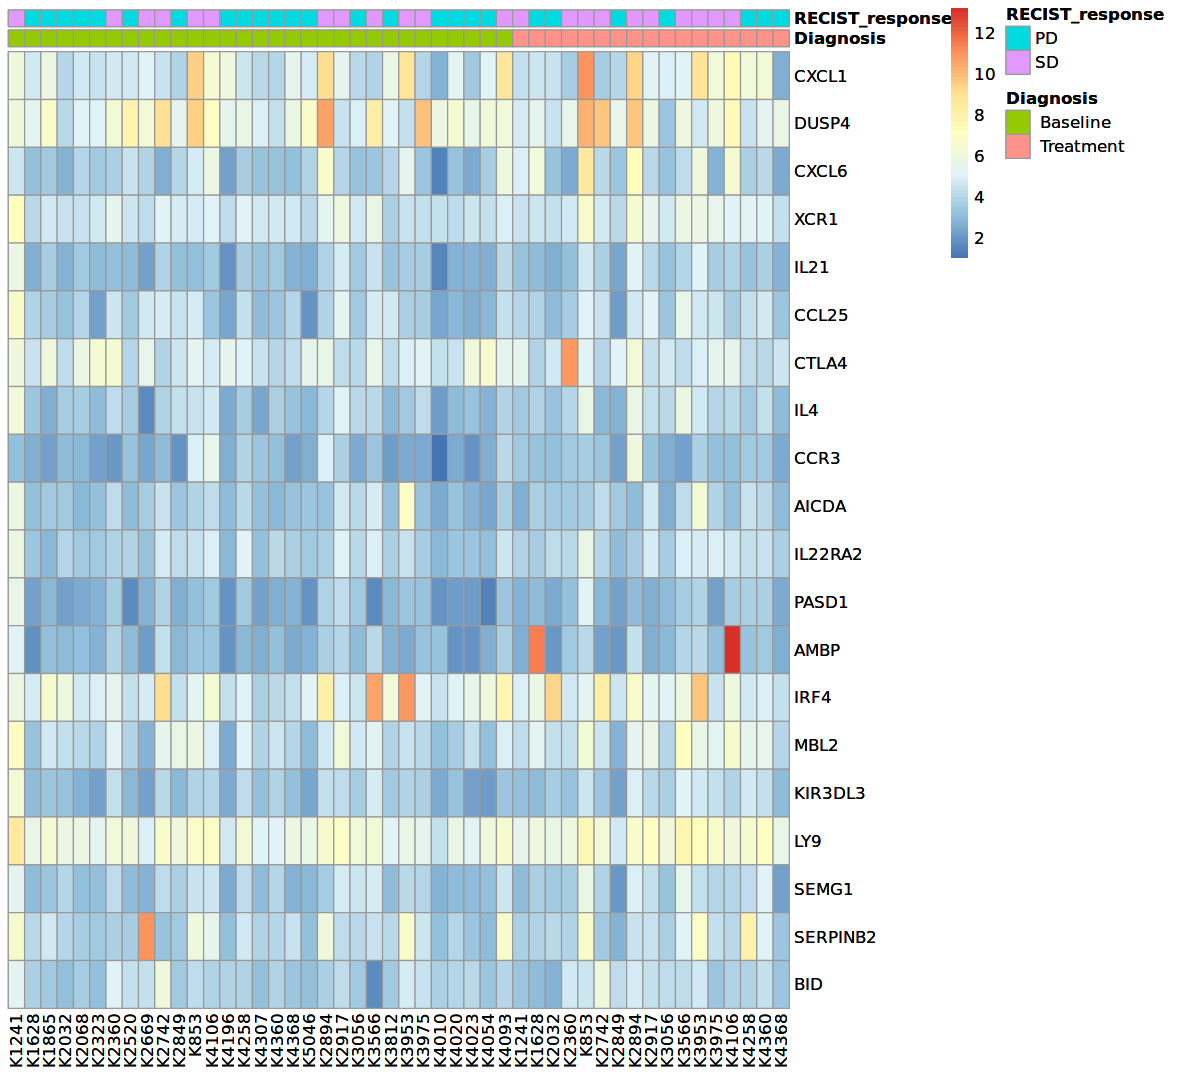

In [159]:
options(repr.plot.width=10, repr.plot.height=9)
# pdf("06_baseline_vs_treatment_heatmap.pdf")
# select <- order(rowMeans(counts(de_dds4,normalized=TRUE)),
#                 decreasing=TRUE)[1:15]
norm_transform_dds <- normTransform(de_dds2)
# print(select)
df <- as.data.frame(colData(de_dds2)[,c('pid',"Diagnosis","Conditions","RECIST_response")])



mt = assay(norm_transform_dds)[row.names( sorted_top_de2),][1:20,]
# Get column names
column_names <- colnames(mt)

# Identify columns containing "B_" and "Tx_"
B_columns <- column_names[grepl("B_", column_names)]
Tx_columns <- column_names[grepl("Tx_", column_names)]
# print(B_columns)
# print(Tx_columns)
# Combine the column names with "B_" first and "Tx_" second
sorted_columns <- c(B_columns, Tx_columns)

# Reorder the dataframe with sorted column names
sorted_mt <- mt[, sorted_columns]
sorted_df = df[sorted_columns,]
# print(colnames(sorted_mt))
row.names(sorted_mt) <- row.names(sorted_top_de2)[1:20]
# pheatmap(mt, cluster_rows=FALSE, show_rownames=FALSE,
#          cluster_cols=FALSE, annotation_col=df)
# genelist <- c('FOS','HLA-DMB' ,'HLA-DRA','IL24', 'EGR1','CTLA4','ARG1','AMBP') 
# Labels to plot
labels <- rownames(sorted_mt) 
# print(labels)
# Set the rest of genes to ""
# labels[!labels %in% genelist] <- "" 

heatmap2 <- pheatmap(sorted_mt, labels_row = labels, labels_col = sorted_df[,c('pid')],
         cluster_rows=FALSE, show_rownames=TRUE,clustering_distance_rows = "euclidean", 
          cluster_cols=FALSE, annotation_col=sorted_df[,c("Diagnosis","RECIST_response")], angle_col=90)

heatmap2

In [160]:
ggsave("05_PD_vs_SD_heatmap.pdf", width = 9,
  height = 8, heatmap2)

## PD vs SD in baseline only

In [20]:
library("pheatmap")

In [21]:
counts(set)

20230616_210462891024_K1241-B_02.RCC
A2M      45                                 
ABCB1     6                                 
ABL1     16                                 
ADA      12                                 
ADORA2A   3                                 
AICDA     7                                 
AIRE     12                                 
AKT3     64                                 
ALCAM    12                                 
AMBP      4                                 
AMICA1    8                                 
ANP32B   49                                 
ANXA1   234                                 
APOE     25                                 
APP     246                                 
ARG1      1                                 
ARG2      7                                 
ATF1     16                                 
ATF2      6                                 
ATG10     8                                 
ATG12     5                                 
ATG16L1   8                                 
ATG5      5                                 
ATG7      2                                 
ATM       3                                 
AXL      50                                 
BAGE      4                                 
BATF      2                                 
BAX      19                                 
BCL10    33                                 
⋮       ⋮                                   
DNAJC14   4                                 
EDC3     16                                 
EIF2B4   14                                 
ERCC3    15                                 
FCF1    133                                 
G6PD     10                                 
GPATCH3  21                                 
GUSB     10                                 
HDAC3    12                                 
HPRT1    34                                 
MRPS5    13                                 
MTMR14   22                                 
NOL7      7                                 
NUBP1     5                                 
POLR2A   21                                 
PPIA      6                                 
PRPF38A  16                                 
SAP130   17                                 
SDHA      6                                 
SF3A3   211                                 
TBP      13                                 
TLK2      9                                 
TMUB2     6                                 
TRIM39    8                                 
TUBB     61                                 
USP39     6                                 
ZC3H14   71                                 
ZKSCAN5   8                                 
ZNF143    8                                 
ZNF346    3                                 
        20230616_210462891024_K1628-B_03.RCC
A2M     20742                               
ABCB1     161                               
ABL1     1557                               
ADA        70                               
ADORA2A    27                               
AICDA      10                               
AIRE       10                               
AKT3     4438                               
ALCAM    1637                               
AMBP        3                               
AMICA1    259                               
ANP32B   1166                               
ANXA1    4739                               
APOE      235                               
APP      1895                               
ARG1        8                               
ARG2      165                               
ATF1      207                               
ATF2      301                               
ATG10     216                               
ATG12      31                               
ATG16L1   167                               
ATG5      440                               
ATG7      119                               
ATM        15                               
AXL      2619                               
BAG

In [22]:
pData(set)

Conditions           Diagnosis  pid  
20230616_210462891024_K1241-B_02.RCC  Soft Tissue Sarcoma   Baseline  K1241
20230616_210462891024_K1628-B_03.RCC  Soft Tissue Sarcoma   Baseline  K1628
20230616_210462891024_K1865-B_04.RCC  Osteosarcoma          Baseline  K1865
20230616_210462891024_K2032-B_05.RCC  Soft Tissue Sarcoma   Baseline  K2032
20230616_210462891024_K2068-B_06.RCC  Soft Tissue Sarcoma   Baseline  K2068
20230616_210462891024_K2323-B_07.RCC  Soft Tissue Sarcoma   Baseline  K2323
20230616_210462891024_K2360-B_08.RCC  Soft Tissue Sarcoma   Baseline  K2360
20230616_210462891024_K2520-B_09.RCC  Soft Tissue Sarcoma   Baseline  K2520
20230616_210462891024_K2669-B_10.RCC  Soft Tissue Sarcoma   Baseline  K2669
20230616_210462891024_K2742-B_11.RCC  Soft Tissue Sarcoma   Baseline  K2742
20230616_210462891024_K2849-B_12.RCC  Osteosarcoma          Baseline  K2849
20230616_210462891024_K853-B_01.RCC   Osteosarcoma          Baseline  K853 
20230707_210462871024_K1241-Tx_09.RCC Soft Tissue Sarcoma   Treatment K1241
20230707_210462871024_K1628-Tx_10.RCC Soft Tissue Sarcoma   Treatment K1628
20230707_210462871024_K2032-Tx_11.RCC Soft Tissue Sarcoma   Treatment K2032
20230707_210462871024_K2360-Tx_12.RCC Soft Tissue Sarcoma   Treatment K2360
20230707_210462871024_K4106-B_01.RCC  Osteosarcoma          Baseline  K4106
20230707_210462871024_K4196-B_02.RCC  Osteosarcoma          Baseline  K4196
20230707_210462871024_K4258-B_03.RCC  Osteosarcoma          Baseline  K4258
20230707_210462871024_K4307-B_04.RCC  Osteosarcoma          Baseline  K4307
20230707_210462871024_K4360-B_05.RCC  Osteosarcoma          Baseline  K4360
20230707_210462871024_K4368-B_06.RCC  Soft Tissue Sarcoma   Baseline  K4368
20230707_210462871024_K5046-B_07.RCC  Osteosarcoma          Baseline  K5046
20230707_210462871024_K853-Tx_08.RCC  Osteosarcoma          Treatment K853 
20230707_210462881024_K2894-B_01.RCC  Osteosarcoma          Baseline  K2894
20230707_210462881024_K2917-B_02.RCC  Soft Tissue Sarcoma   Baseline  K2917
20230707_210462881024_K3056-B_03.RCC  Osteosarcoma          Baseline  K3056
20230707_210462881024_K3566-B_04.RCC  Soft Tissue Sarcoma   Baseline  K3566
20230707_210462881024_K3812-B_05.RCC  Soft Tissue Sarcoma   Baseline  K3812
20230707_210462881024_K3953-B_06.RCC  Soft Tissue Sarcoma   Baseline  K3953
20230707_210462881024_K3975-B_07.RCC  Osteosarcoma          Baseline  K3975
20230707_210462881024_K4010-B_08.RCC  Osteosarcoma          Baseline  K4010
20230707_210462881024_K4020-B_09.RCC  Osteosarcoma          Baseline  K4020
20230707_210462881024_K4023-B_10.RCC  Osteosarcoma          Baseline  K4023
20230707_210462881024_K4054-B_11.RCC  Osteosarcoma          Baseline  K4054
20230707_210462881024_K4093-B_12.RCC  Soft Tissue Sarcoma   Baseline  K4093
20230707_210462901024_K2742-Tx_01.RCC Soft Tissue Sarcoma   Treatment K2742
20230707_210462901024_K2849-Tx_02.RCC Osteosarcoma          Treatment K2849
20230707_210462901024_K2894-Tx_03.RCC Osteosarcoma          Treatment K2894
20230707_210462901024_K2917-Tx_04.RCC Soft Tissue Sarcoma   Treatment K2917
20230707_210462901024_K3056-Tx_05.RCC Osteosarcoma          Treatment K3056
20230707_210462901024_K3566-Tx_06.RCC Soft Tissue Sarcoma   Treatment K3566
20230707_210462901024_K3953-Tx_07.RCC Soft Tissue Sarcoma   Treatment K3953
20230707_210462901024_K3975-Tx_08.RCC Osteosarcoma          Treatment K3975
20230707_210462901024_K4106-Tx_09.RCC Osteosarcoma          Treatment K4106
20230707_210462901024_K4258-Tx_10.RCC Osteosarcoma          Treatment K4258
20230707_210462901024_K4360-Tx_11.RCC Osteosarcoma          Treatment K4360
20230707_210462901024_K4368-Tx_12.RCC Soft Tissue Sarcoma   Treatment K4368
                                      Is_matched Subject_ID RECIST_response
20230616_210462891024_K1241-B_02.RCC  True       TI0045     SD             
20230616_210462891024_K1628-B_03.RCC  True       TI0036     PD             
20230616_210462891024_K1865-B_04.RCC  False      TI0004     PD             
20230616_2

In [23]:
selected_coldata  <- subset(pData(set), Is_matched == 'True')
selected_coldata

Conditions           Diagnosis  pid  
20230616_210462891024_K1241-B_02.RCC  Soft Tissue Sarcoma   Baseline  K1241
20230616_210462891024_K1628-B_03.RCC  Soft Tissue Sarcoma   Baseline  K1628
20230616_210462891024_K2032-B_05.RCC  Soft Tissue Sarcoma   Baseline  K2032
20230616_210462891024_K2360-B_08.RCC  Soft Tissue Sarcoma   Baseline  K2360
20230616_210462891024_K2742-B_11.RCC  Soft Tissue Sarcoma   Baseline  K2742
20230616_210462891024_K2849-B_12.RCC  Osteosarcoma          Baseline  K2849
20230616_210462891024_K853-B_01.RCC   Osteosarcoma          Baseline  K853 
20230707_210462871024_K1241-Tx_09.RCC Soft Tissue Sarcoma   Treatment K1241
20230707_210462871024_K1628-Tx_10.RCC Soft Tissue Sarcoma   Treatment K1628
20230707_210462871024_K2032-Tx_11.RCC Soft Tissue Sarcoma   Treatment K2032
20230707_210462871024_K2360-Tx_12.RCC Soft Tissue Sarcoma   Treatment K2360
20230707_210462871024_K4106-B_01.RCC  Osteosarcoma          Baseline  K4106
20230707_210462871024_K4258-B_03.RCC  Osteosarcoma          Baseline  K4258
20230707_210462871024_K4360-B_05.RCC  Osteosarcoma          Baseline  K4360
20230707_210462871024_K4368-B_06.RCC  Soft Tissue Sarcoma   Baseline  K4368
20230707_210462871024_K853-Tx_08.RCC  Osteosarcoma          Treatment K853 
20230707_210462881024_K2894-B_01.RCC  Osteosarcoma          Baseline  K2894
20230707_210462881024_K2917-B_02.RCC  Soft Tissue Sarcoma   Baseline  K2917
20230707_210462881024_K3056-B_03.RCC  Osteosarcoma          Baseline  K3056
20230707_210462881024_K3566-B_04.RCC  Soft Tissue Sarcoma   Baseline  K3566
20230707_210462881024_K3953-B_06.RCC  Soft Tissue Sarcoma   Baseline  K3953
20230707_210462881024_K3975-B_07.RCC  Osteosarcoma          Baseline  K3975
20230707_210462901024_K2742-Tx_01.RCC Soft Tissue Sarcoma   Treatment K2742
20230707_210462901024_K2849-Tx_02.RCC Osteosarcoma          Treatment K2849
20230707_210462901024_K2894-Tx_03.RCC Osteosarcoma          Treatment K2894
20230707_210462901024_K2917-Tx_04.RCC Soft Tissue Sarcoma   Treatment K2917
20230707_210462901024_K3056-Tx_05.RCC Osteosarcoma          Treatment K3056
20230707_210462901024_K3566-Tx_06.RCC Soft Tissue Sarcoma   Treatment K3566
20230707_210462901024_K3953-Tx_07.RCC Soft Tissue Sarcoma   Treatment K3953
20230707_210462901024_K3975-Tx_08.RCC Osteosarcoma          Treatment K3975
20230707_210462901024_K4106-Tx_09.RCC Osteosarcoma          Treatment K4106
20230707_210462901024_K4258-Tx_10.RCC Osteosarcoma          Treatment K4258
20230707_210462901024_K4360-Tx_11.RCC Osteosarcoma          Treatment K4360
20230707_210462901024_K4368-Tx_12.RCC Soft Tissue Sarcoma   Treatment K4368
                                      Is_matched Subject_ID RECIST_response
20230616_210462891024_K1241-B_02.RCC  True       TI0045     SD             
20230616_210462891024_K1628-B_03.RCC  True       TI0036     PD             
20230616_210462891024_K2032-B_05.RCC  True       TI0047     PD             
20230616_210462891024_K2360-B_08.RCC  True       TI0030     SD             
20230616_210462891024_K2742-B_11.RCC  True       TI0015     SD             
20230616_210462891024_K2849-B_12.RCC  True       TI0091     PD             
20230616_210462891024_K853-B_01.RCC   True       TI0081     SD             
20230707_210462871024_K1241-Tx_09.RCC True       TI0045     SD             
20230707_210462871024_K1628-Tx_10.RCC True       TI0036     PD             
20230707_210462871024_K2032-Tx_11.RCC True       TI0047     PD             
20230707_210462871024_K2360-Tx_12.RCC True       TI0030     SD             
20230707_210462871024_K4106-B_01.RCC  True       TI0053     SD             
20230707_210462871024_K4258-B_03.RCC  True       TI0038     PD             
20230707_210462871024_K4360-B_05.RCC  True       TI0107     PD             
20230707_210462871024_K4368-B_06.RCC  True       TI0057     PD             
20230707_210462871024_K853-Tx_08.RCC  True       TI0081     SD             
20230707_210462881024_K2894-B_01.RCC  True       TI0039     SD             
20230707_2

In [24]:
row.names(selected_coldata)

[1] "20230616_210462891024_K1241-B_02.RCC" 
 [2] "20230616_210462891024_K1628-B_03.RCC" 
 [3] "20230616_210462891024_K2032-B_05.RCC" 
 [4] "20230616_210462891024_K2360-B_08.RCC" 
 [5] "20230616_210462891024_K2742-B_11.RCC" 
 [6] "20230616_210462891024_K2849-B_12.RCC" 
 [7] "20230616_210462891024_K853-B_01.RCC"  
 [8] "20230707_210462871024_K1241-Tx_09.RCC"
 [9] "20230707_210462871024_K1628-Tx_10.RCC"
[10] "20230707_210462871024_K2032-Tx_11.RCC"
[11] "20230707_210462871024_K2360-Tx_12.RCC"
[12] "20230707_210462871024_K4106-B_01.RCC" 
[13] "20230707_210462871024_K4258-B_03.RCC" 
[14] "20230707_210462871024_K4360-B_05.RCC" 
[15] "20230707_210462871024_K4368-B_06.RCC" 
[16] "20230707_210462871024_K853-Tx_08.RCC" 
[17] "20230707_210462881024_K2894-B_01.RCC" 
[18] "20230707_210462881024_K2917-B_02.RCC" 
[19] "20230707_210462881024_K3056-B_03.RCC" 
[20] "20230707_210462881024_K3566-B_04.RCC" 
[21] "20230707_210462881024_K3953-B_06.RCC" 
[22] "20230707_210462881024_K3975-B_07.RCC" 
[23] "20230707_210462901024_K2742-Tx_01.RCC"
[24] "20230707_210462901024_K2849-Tx_02.RCC"
[25] "20230707_210462901024_K2894-Tx_03.RCC"
[26] "20230707_210462901024_K2917-Tx_04.RCC"
[27] "20230707_210462901024_K3056-Tx_05.RCC"
[28] "20230707_210462901024_K3566-Tx_06.RCC"
[29] "20230707_210462901024_K3953-Tx_07.RCC"
[30] "20230707_210462901024_K3975-Tx_08.RCC"
[31] "20230707_210462901024_K4106-Tx_09.RCC"
[32] "20230707_210462901024_K4258-Tx_10.RCC"
[33] "20230707_210462901024_K4360-Tx_11.RCC"
[34] "20230707_210462901024_K4368-Tx_12.RCC"

In [25]:
subset_count_data = counts(set)[, row.names(selected_coldata)]

In [26]:
dds4 <- DESeqDataSetFromMatrix(countData = subset_count_data,
                              colData = selected_coldata,
                              design = ~ W_1 + Diagnosis )

# dds4 <- DESeqDataSetFromMatrix(countData = subset_count_data,
#                               colData = selected_coldata,
#                               design = ~ Diagnosis )

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [27]:
de_dds4 <- DESeq(dds4)

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and t

In [28]:
results(de_dds4)

log2 fold change (MLE): Diagnosis .Treatment vs .Baseline 
Wald test p-value: Diagnosis .Treatment vs .Baseline 
DataFrame with 770 rows and 6 columns
         baseMean log2FoldChange     lfcSE       stat    pvalue      padj
        <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
A2M     3923.7288      -0.673267  0.535613  -1.257003  0.208753  0.531211
ABCB1     32.6246       0.299806  0.331354   0.904788  0.365577  0.684725
ABL1     397.9343      -0.277181  0.325080  -0.852654  0.393851  0.690872
ADA       56.8983      -0.110689  0.252299  -0.438722  0.660863  0.875658
ADORA2A   28.5216       0.504421  0.303599   1.661471  0.096619  0.360748
...           ...            ...       ...        ...       ...       ...
USP39     71.8478     0.23879631  0.195889  1.2190398  0.222829  0.536255
ZC3H14   258.6935    -0.24657985  0.198405 -1.2428114  0.213937  0.534843
ZKSCAN5   45.3008    -0.00578692  0.136081 -0.0425257  0.966080  0.987901
ZNF143    67.2257    -0.18407370  0

In [29]:
res_valcanoplot4 <- results(de_dds4)
res_valcanoplot4

log2 fold change (MLE): Diagnosis .Treatment vs .Baseline 
Wald test p-value: Diagnosis .Treatment vs .Baseline 
DataFrame with 770 rows and 6 columns
         baseMean log2FoldChange     lfcSE       stat    pvalue      padj
        <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
A2M     3923.7288      -0.673267  0.535613  -1.257003  0.208753  0.531211
ABCB1     32.6246       0.299806  0.331354   0.904788  0.365577  0.684725
ABL1     397.9343      -0.277181  0.325080  -0.852654  0.393851  0.690872
ADA       56.8983      -0.110689  0.252299  -0.438722  0.660863  0.875658
ADORA2A   28.5216       0.504421  0.303599   1.661471  0.096619  0.360748
...           ...            ...       ...        ...       ...       ...
USP39     71.8478     0.23879631  0.195889  1.2190398  0.222829  0.536255
ZC3H14   258.6935    -0.24657985  0.198405 -1.2428114  0.213937  0.534843
ZKSCAN5   45.3008    -0.00578692  0.136081 -0.0425257  0.966080  0.987901
ZNF143    67.2257    -0.18407370  0

In [30]:
firstC <- 'Treatment'
SecondC <- 'Baseline'
contrast<- c("Diagnosis",firstC,SecondC)
res_deseq4 <- as.data.frame(results(de_dds4))
nam4 <- paste('up_in',firstC, sep = '_')

In [31]:
res_deseq4[, nam4] <- as.logical(res_deseq4$log2FoldChange > 0)

res_deseq4$threshold <- as.logical(res_deseq4$padj < 0.05) 
# res_deseq4

In [32]:
norm_mean_w4 <- sapply(levels(de_dds4$Diagnosis), function(lvl) rowMeans( counts(de_dds4,normalized=TRUE)[,de_dds4$Diagnosis == lvl, drop=F] ) )


In [33]:
colnames(norm_mean_w4) <- paste('Rowmean_exp_',levels(de_dds4$Diagnosis),sep='')

res4 <- cbind(norm_mean_w4,res_deseq4)

In [34]:
res4

Rowmean_exp_ Baseline Rowmean_exp_ Treatment baseMean   log2FoldChange
A2M     4884.888332           2962.56929             3923.72881 -0.673267057  
ABCB1     28.728653             36.52060               32.62463  0.299805611  
ABL1     465.309821            330.55879              397.93431 -0.277180892  
ADA       59.537293             54.25938               56.89834 -0.110688897  
ADORA2A   23.963788             33.07948               28.52163  0.504421013  
AICDA     17.681160             12.28230               14.98173 -0.465538296  
AIRE      18.205449             20.85948               19.53246  0.345080064  
AKT3     747.354944            551.79184              649.57339 -0.439844395  
ALCAM    188.240312            195.76481              192.00256  0.071814375  
AMBP       8.275346            552.95310              280.61422  5.941093552  
AMICA1   135.353443            108.42164              121.88754 -0.211753099  
ANP32B   444.380364            371.20301              407.79169 -0.125673641  
ANXA1   3611.192113           2284.64879             2947.92045 -0.608909458  
APOE     765.303382            798.16446              781.73392  0.060502963  
APP     2874.423094           1900.28264             2387.35287 -0.595538519  
ARG1       7.209379             67.83158               37.52048  3.228358454  
ARG2      42.343484             59.05452               50.69900  0.509534843  
ATF1     157.914324            126.99301              142.45367 -0.261793085  
ATF2     249.225900            229.20996              239.21793 -0.072288158  
ATG10     68.364647             48.69017               58.52741 -0.418956247  
ATG12     24.936332             24.87802               24.90718  0.128358531  
ATG16L1  107.376220             99.10885              103.24253 -0.060062732  
ATG5     138.597836            126.04181              132.31983 -0.039676482  
ATG7      83.156347             77.93628               80.54631 -0.045643701  
ATM       13.403332             13.47428               13.43881  0.004143121  
AXL      711.423889            577.00434              644.21411 -0.236018722  
BAGE      12.048544             21.57455               16.81155  0.858562673  
BATF      16.920670             19.18904               18.05485  0.086074145  
BAX      491.743578            390.57557              441.15957 -0.298781336  
BCL10    161.170646            137.71952              149.44508 -0.229539402  
⋮       ⋮                     ⋮                      ⋮          ⋮             
DNAJC14   68.19884             71.00317               69.60101   0.040606328  
EDC3     337.60972            283.19994              310.40483  -0.165448448  
EIF2B4   237.11737            210.27766              223.69751  -0.112491068  
ERCC3    122.53118             83.25832              102.89475  -0.501790020  
FCF1    1037.96937            744.32318              891.14627  -0.392902780  
G6PD     265.30575            178.12993              221.71784  -0.523507403  
GPATCH3   75.62137             62.60201               69.11169  -0.236720179  
GUSB     132.21648            144.84976              138.53312   0.116566016  
HDAC3    178.18915            171.17908              174.68411   0.026089502  
HPRT1    409.70145            314.14669              361.92407  -0.216298024  
MRPS5    268.51866            292.08818              280.30342   0.169289549  
MTMR14   213.03079            171.65547              192.34313  -0.250572577  
NOL7     160.89241            157.19094              159.04167   0.029371452  
NUBP1     43.45540             48.63952               46.04746   0.213163858  
POLR2A   579.34929            502.98449              541.16689  -0.186999684  
PPIA     165.73825            159.04903              162.39364   0.066656771  
PRPF38A  272.03184            286.45359              279.24271   0.167885194  
SAP130   183.57853            153.94426              168.76139  -0.176310980  
SDHA     248.15887            201.43783              224.7

In [35]:
top_de_genes4 = res4[row.names(res_deseq4)[which(res_deseq4$threshold)],]
top_de_genes4

Rowmean_exp_ Baseline Rowmean_exp_ Treatment baseMean   log2FoldChange
AMBP        8.275346            552.95310              280.61422  5.9410936    
ARG1        7.209379             67.83158               37.52048  3.2283585    
BCL2      262.438912            120.24577              191.34234 -1.0490485    
BCL6      270.256292            141.10248              205.67939 -0.9197216    
C4BPA       4.975994             50.12701               27.55150  3.4413522    
C6         18.149601             48.17916               33.16438  1.4178466    
C8A         9.566004             38.59137               24.07869  2.0785982    
C8B         7.061662             60.61779               33.83972  3.1065845    
C9         12.964539            121.74489               67.35471  3.2274307    
CCL19      78.419670             37.19192               57.80579 -1.2096035    
CHUK      232.683991            147.61254              190.14826 -0.5928369    
CRP         7.356012             37.86757               22.61179  2.3789698    
CTLA4      25.322008            100.18472               62.75336  1.9417729    
EGR1      200.261009             52.54248              126.40174 -1.9307671    
F12         8.029336             48.10042               28.06488  2.3370721    
FADD       50.360545             32.89876               41.62965 -0.6188184    
FOS      1911.906499            235.99869             1073.95259 -3.0927171    
FYN       580.317675            275.52313              427.92040 -0.9464581    
HAMP       11.368532             47.47262               29.42058  2.0520940    
HLA-DMB   172.414223            282.16110              227.28766  0.6652430    
HLA-DPA1  432.075327            771.08391              601.57962  0.8202133    
HLA-DPB1  559.890036           1152.43692              856.16348  1.0162531    
HLA-DRA  1299.196269           2638.06082             1968.62855  0.9148528    
ICOSLG    214.469917             55.07762              134.77377 -2.0231687    
IL24      181.234921             13.33059               97.28275 -3.2359440    
IRAK4     113.782393             78.53646               96.15943 -0.5195326    
IRF3       99.170253             60.30036               79.73531 -0.6912268    
MAP2K2    826.113264            506.41127              666.26227 -0.6453943    
MRC1      122.650541            246.41967              184.53511  0.9297879    
NFATC1    123.766490             55.67618               89.72134 -1.1615589    
NFATC2    258.636078            114.60598              186.62103 -1.2233049    
PSMD7     804.932258            422.18984              613.56105 -0.8868096    
STAT3    1763.599831           1122.26345             1442.93164 -0.6510720    
TBK1      151.247619             90.24742              120.74752 -0.7134830    
TNF        18.239857             36.04079               27.14032  1.0277444    
DHX16     128.078649             88.79971              108.43918 -0.4793425    
ERCC3     122.531180             83.25832              102.89475 -0.5017900    
SF3A3     682.327212            370.61850              526.47286 -0.7622312    
TLK2      207.658013            139.38730              173.52266 -0.5235148    
         lfcSE     stat      pvalue       padj         up_in_Treatment
AMBP     0.8949035  6.638809 3.162283e-11 1.784899e-08  TRUE          
ARG1     0.6768597  4.769612 1.845809e-06 1.674412e-04  TRUE          
BCL2     0.3261106 -3.216849 1.296067e-03 2.837939e-02 FALSE          
BCL6     0.2919590 -3.150173 1.631737e-03 3.237977e-02 FALSE          
C4BPA    0.6686100  5.147025 2.646505e-07 2.800885e-05  TRUE          
C6       0.4749110  2.985499 2.831157e-03 4.858878e-02  TRUE          
C8A      0.4964224  4.187156 2.824711e-05 1.630629e-03  TRUE          
C8B      0.5472666  5.676546 1.374412e-08 2.909173e-06  TRUE          
C9       0.6169341  5.231403 1.682284e-07 2.299139e-05  TRUE          
CCL19    0.4020181 -3.008829 2.622569e-03 4.625921e-02 FALSE          
CHUK     0.1827654 -3.243705

In [161]:
write.csv(top_de_genes4, '06_DE_genes_baseline_vs_treatment_matched_id.csv')

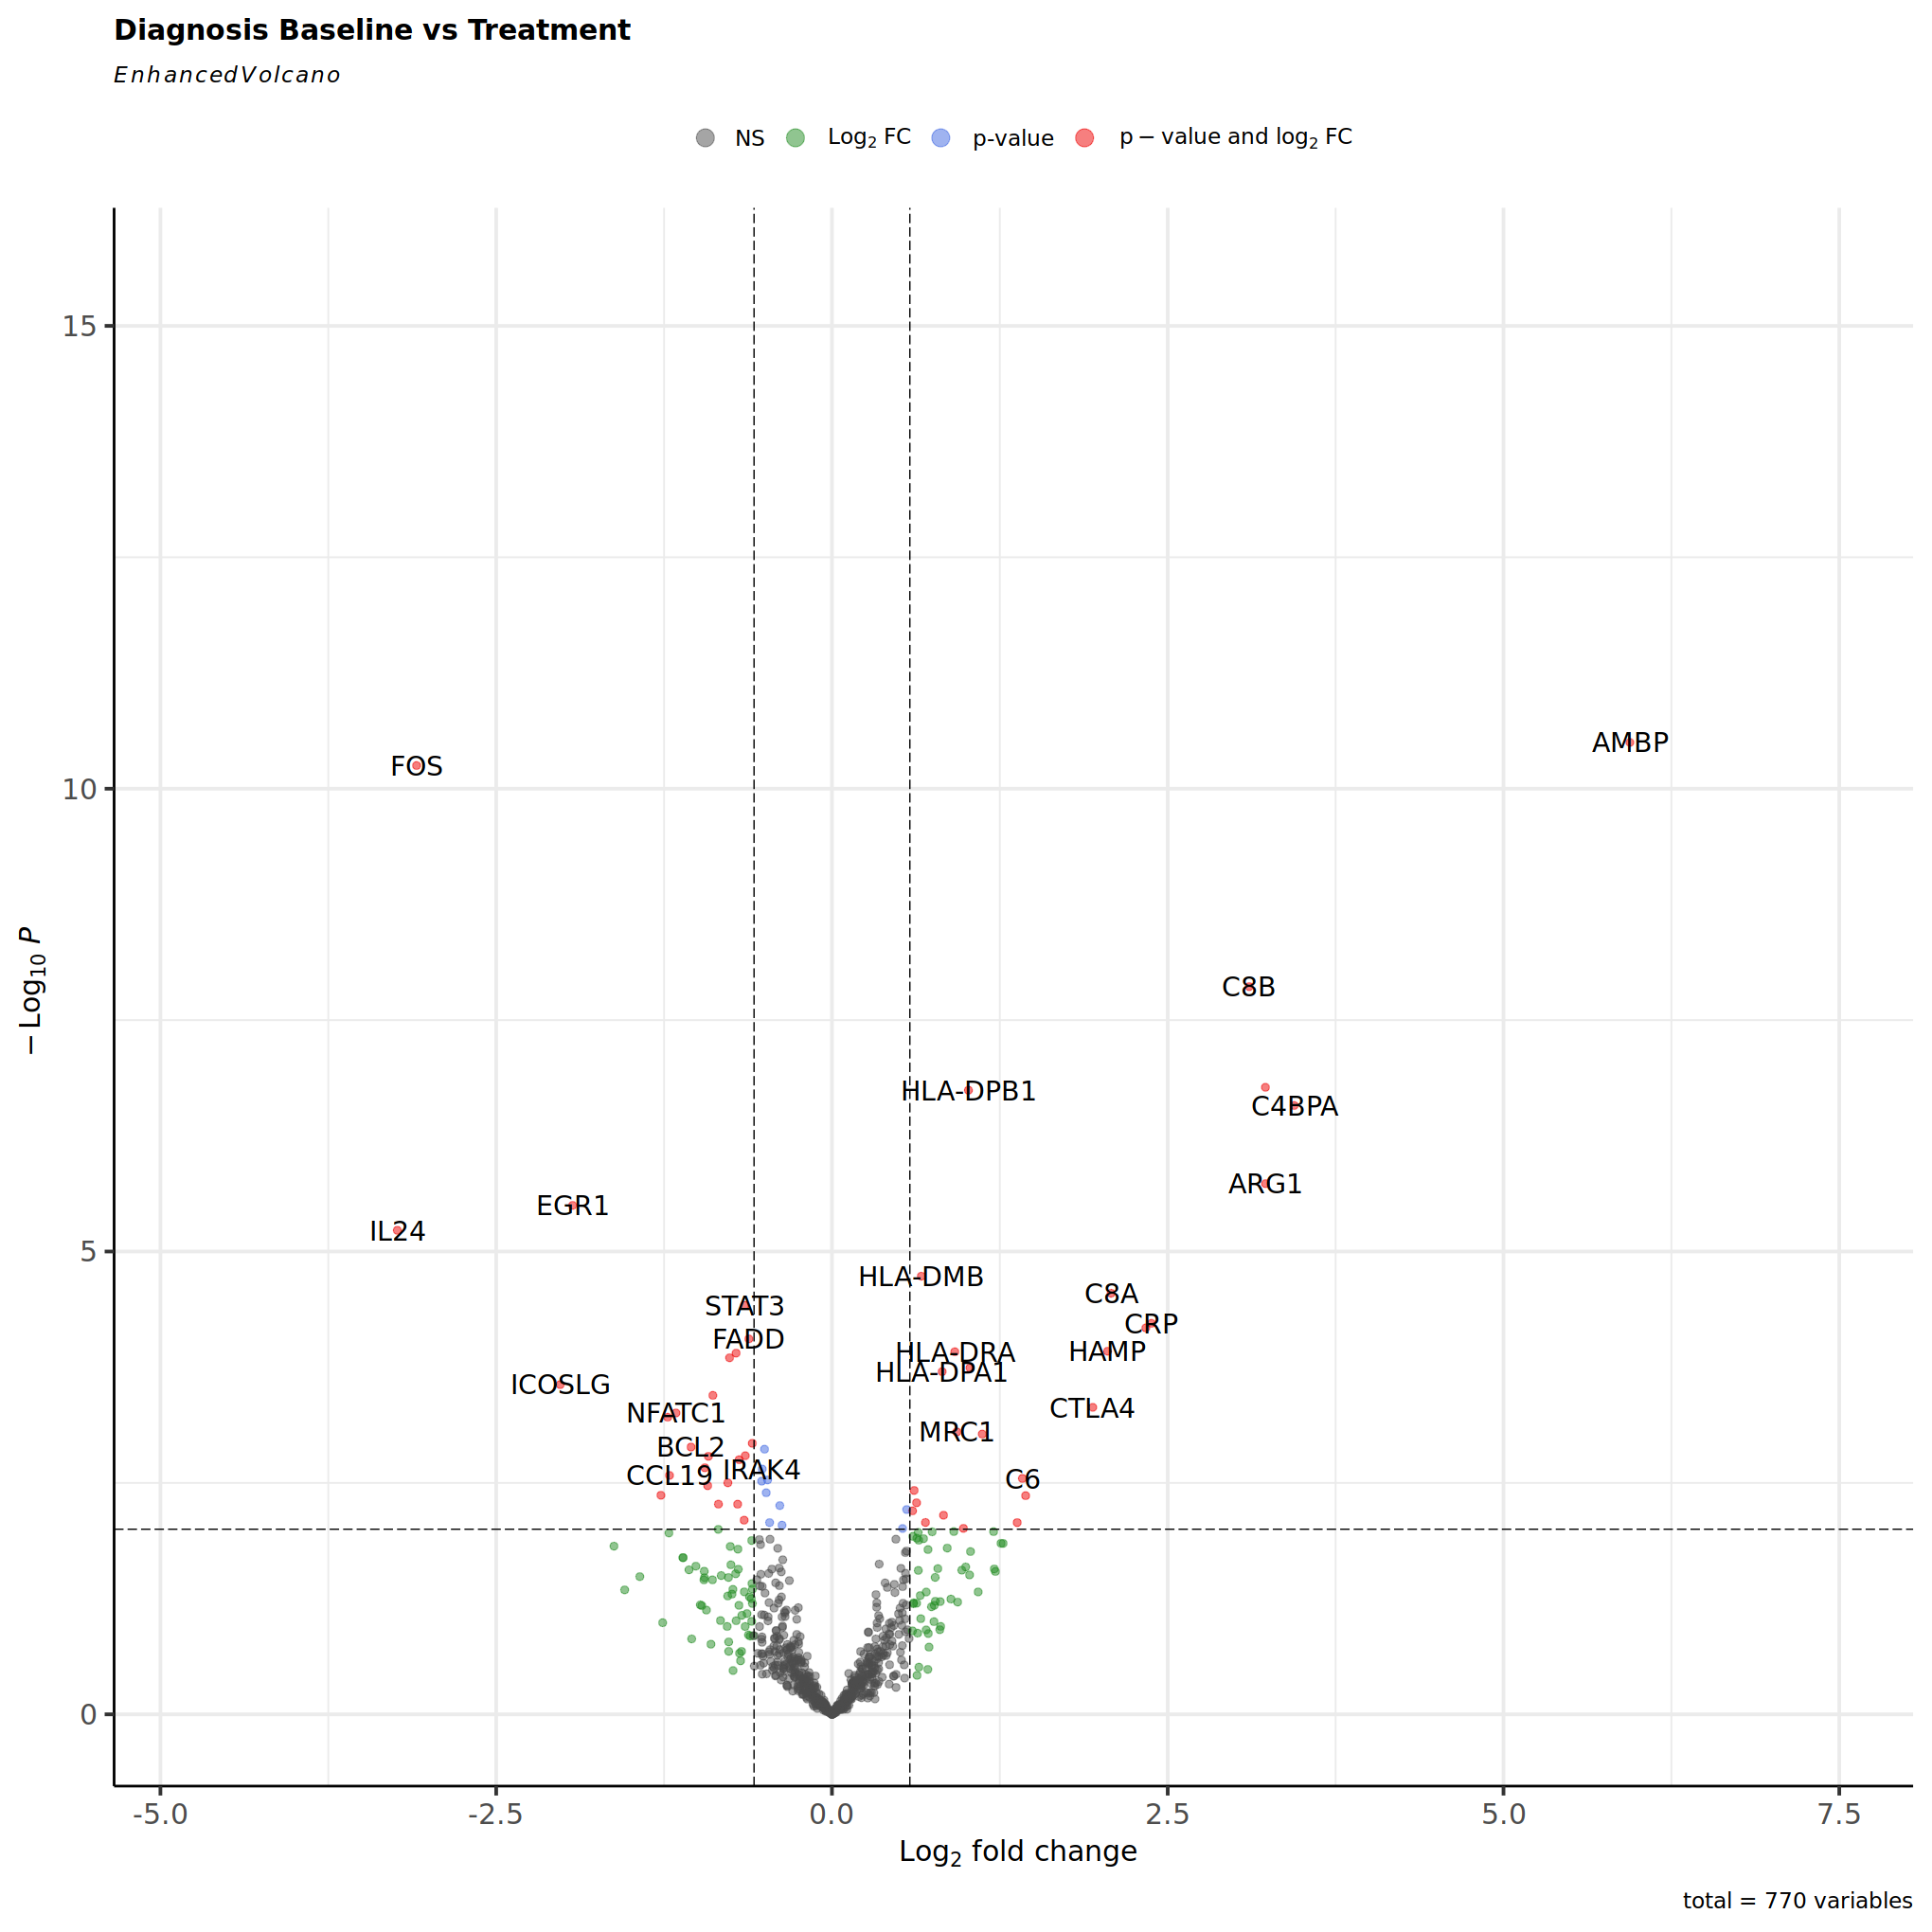

In [38]:
options(repr.plot.width=17, repr.plot.height=17)
# pdf("05_PS_vs_SD_volcano_plot.pdf")
# pdf('06_Baseline_vs_Treatment_volcano_plot_matched_id.pdf')
sdvspd_volplot4 <- EnhancedVolcano(res_valcanoplot4,
                lab = rownames(res_valcanoplot4), selectLab = row.names(top_de_genes4),
                x = 'log2FoldChange',
                y = 'pvalue', title = 'Diagnosis Baseline vs Treatment',
                pCutoff = 0.01, drawConnectors = FALSE,max.overlaps = 30,
                FCcutoff = 0.58,
                pointSize = 2.0,
                labSize = 6.0)
# dev.off()
sdvspd_volplot4

In [39]:
ggsave("07_baseline_vs_treatment_volcano_plot_matched_id.pdf", 
       width = 10,
       height = 10, sdvspd_volplot4)

In [40]:
goi4_1 = c('FOS', 'IL24', 'EGR1')
goi4_1

[1] "FOS"  "IL24" "EGR1"

In [41]:
tcounts4_1 <- t(log2((counts(de_dds4[goi4_1, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(de_dds4), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi4_1)+1):ncol(.))

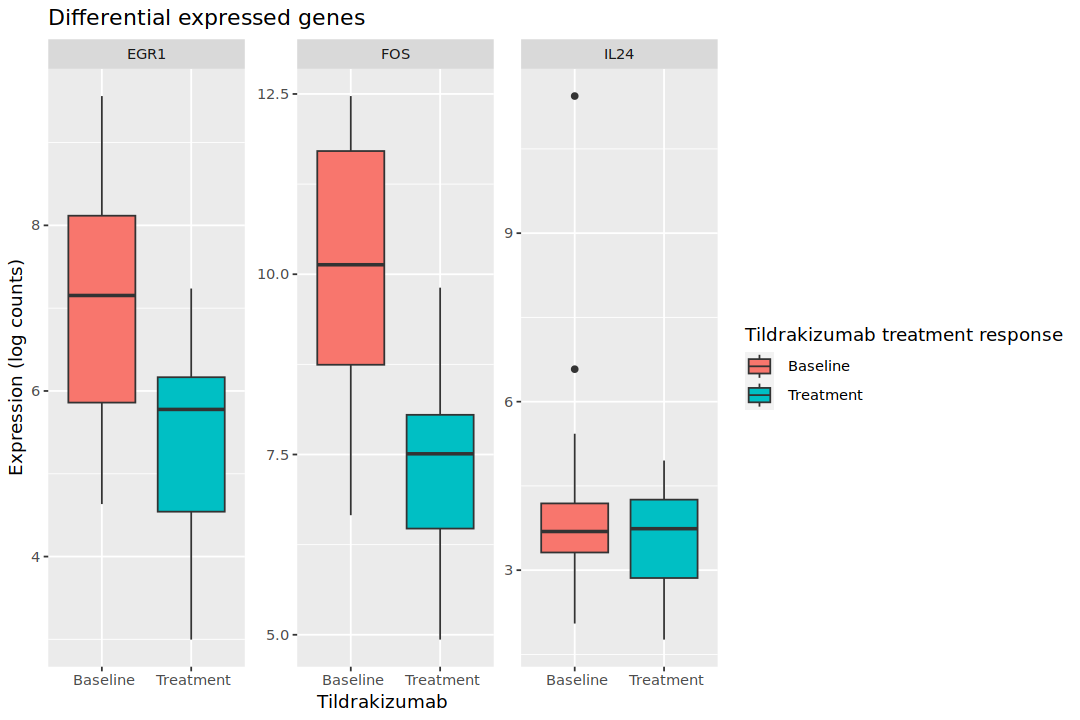

In [42]:
options(repr.plot.width=9, repr.plot.height=6)
sd_boxplot = ggplot(tcounts4_1, aes(Diagnosis, expression, fill=Diagnosis)) + 
  geom_boxplot() + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab treatment response", 
       title="Differential expressed genes")
sd_boxplot

png 
  2

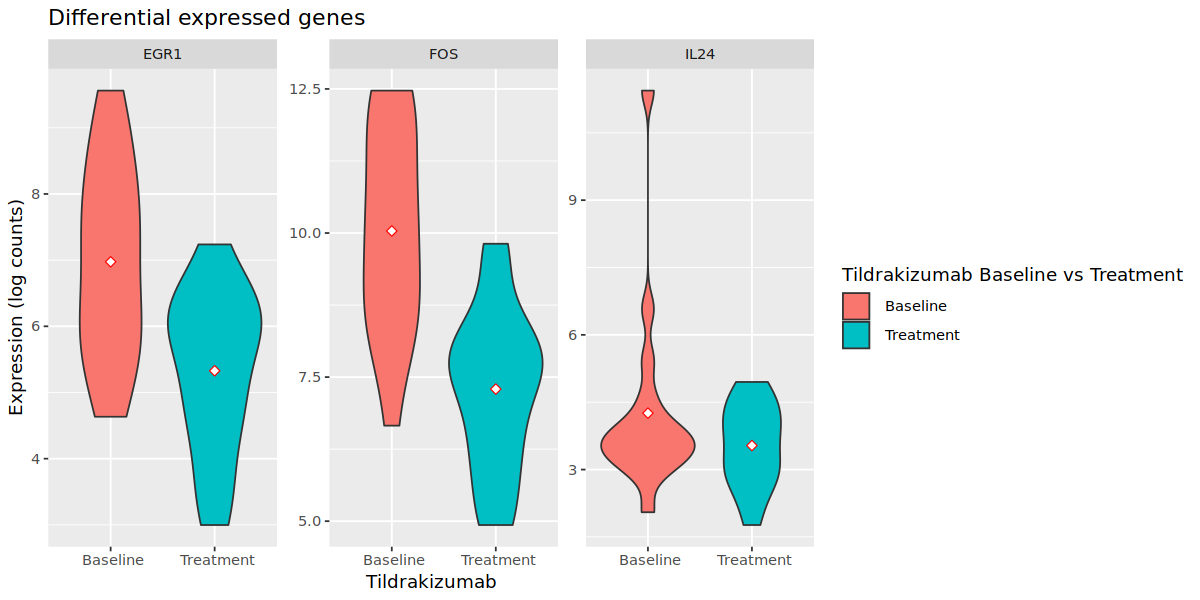

In [43]:
options(repr.plot.width=10, repr.plot.height=5)
pdf("06_baseline_vs_treatment_violin_plot2.pdf")
sd_boxplot2 = ggplot(tcounts4_1, aes(Diagnosis, expression, fill=Diagnosis)) + 
  geom_violin() + 
  stat_summary(fun = mean, geom = "point", shape = 23, size = 2, color = "red", fill = "white") + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab Baseline vs Treatment", 
       title="Differential expressed genes")
dev.off()
sd_boxplot2

In [44]:
ggsave("07_baseline_vs_treatment_violin_plot_matched_id.pdf", 
       width = 10,
       height = 10, sd_boxplot2)

In [45]:
norm_transform_dds <- normTransform(de_dds4)
norm_transform_dds

class: DESeqTransform 
dim: 770 34 
metadata(1): version
assays(1): ''
rownames(770): A2M ABCB1 ... ZNF143 ZNF346
rowData names(26): baseMean baseVar ... deviance maxCooks
colnames(34): 20230616_210462891024_K1241-B_02.RCC
  20230616_210462891024_K1628-B_03.RCC ...
  20230707_210462901024_K4360-Tx_11.RCC
  20230707_210462901024_K4368-Tx_12.RCC
colData names(10): Conditions Diagnosis ... W_1 sizeFactor

In [143]:
# assay(norm_transform_dds)

In [144]:
# order(top_de_genes4$padj , decreasing=FALSE)[1:8]

In [67]:
row.names(top_de_genes4)

[1] "AMBP"     "ARG1"     "BCL2"     "BCL6"     "C4BPA"    "C6"      
 [7] "C8A"      "C8B"      "C9"       "CCL19"    "CHUK"     "CRP"     
[13] "CTLA4"    "EGR1"     "F12"      "FADD"     "FOS"      "FYN"     
[19] "HAMP"     "HLA-DMB"  "HLA-DPA1" "HLA-DPB1" "HLA-DRA"  "ICOSLG"  
[25] "IL24"     "IRAK4"    "IRF3"     "MAP2K2"   "MRC1"     "NFATC1"  
[31] "NFATC2"   "PSMD7"    "STAT3"    "TBK1"     "TNF"      "DHX16"   
[37] "ERCC3"    "SF3A3"    "TLK2"

In [206]:
sorted_top_de = top_de_genes4[order(top_de_genes4$up_in_Treatment==TRUE, top_de_genes4$padj),]

In [248]:
col_labels = as.data.frame(colData(de_dds4)[,c('pid',"Diagnosis","Conditions")])
col_labels

pid   Diagnosis  Conditions          
20230616_210462891024_K1241-B_02.RCC  K1241  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K1628-B_03.RCC  K1628  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K2032-B_05.RCC  K2032  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K2360-B_08.RCC  K2360  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K2742-B_11.RCC  K2742  Baseline  Soft Tissue Sarcoma 
20230616_210462891024_K2849-B_12.RCC  K2849  Baseline  Osteosarcoma        
20230616_210462891024_K853-B_01.RCC   K853   Baseline  Osteosarcoma        
20230707_210462871024_K1241-Tx_09.RCC K1241  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K1628-Tx_10.RCC K1628  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K2032-Tx_11.RCC K2032  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K2360-Tx_12.RCC K2360  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K4106-B_01.RCC  K4106  Baseline  Osteosarcoma        
20230707_210462871024_K4258-B_03.RCC  K4258  Baseline  Osteosarcoma        
20230707_210462871024_K4360-B_05.RCC  K4360  Baseline  Osteosarcoma        
20230707_210462871024_K4368-B_06.RCC  K4368  Baseline  Soft Tissue Sarcoma 
20230707_210462871024_K853-Tx_08.RCC  K853   Treatment Osteosarcoma        
20230707_210462881024_K2894-B_01.RCC  K2894  Baseline  Osteosarcoma        
20230707_210462881024_K2917-B_02.RCC  K2917  Baseline  Soft Tissue Sarcoma 
20230707_210462881024_K3056-B_03.RCC  K3056  Baseline  Osteosarcoma        
20230707_210462881024_K3566-B_04.RCC  K3566  Baseline  Soft Tissue Sarcoma 
20230707_210462881024_K3953-B_06.RCC  K3953  Baseline  Soft Tissue Sarcoma 
20230707_210462881024_K3975-B_07.RCC  K3975  Baseline  Osteosarcoma        
20230707_210462901024_K2742-Tx_01.RCC K2742  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K2849-Tx_02.RCC K2849  Treatment Osteosarcoma        
20230707_210462901024_K2894-Tx_03.RCC K2894  Treatment Osteosarcoma        
20230707_210462901024_K2917-Tx_04.RCC K2917  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K3056-Tx_05.RCC K3056  Treatment Osteosarcoma        
20230707_210462901024_K3566-Tx_06.RCC K3566  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K3953-Tx_07.RCC K3953  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K3975-Tx_08.RCC K3975  Treatment Osteosarcoma        
20230707_210462901024_K4106-Tx_09.RCC K4106  Treatment Osteosarcoma        
20230707_210462901024_K4258-Tx_10.RCC K4258  Treatment Osteosarcoma        
20230707_210462901024_K4360-Tx_11.RCC K4360  Treatment Osteosarcoma        
20230707_210462901024_K4368-Tx_12.RCC K4368  Treatment Soft Tissue Sarcoma

In [260]:
# mt

20230616_210462891024_K1241-B_02.RCC
AMBP     8.132983                           
ARG1     4.662399                           
BCL2     5.445129                           
BCL6    10.305852                           
C4BPA    6.085113                           
C6       6.085113                           
C8A     10.326496                           
C8B      5.949733                           
C9       8.415858                           
CCL19    6.085113                           
CHUK     6.619025                           
CRP      7.074448                           
CTLA4    7.074448                           
EGR1     6.526894                           
F12      6.085113                           
FADD     8.281342                           
FOS      6.085113                           
FYN      8.036044                           
HAMP     6.619025                           
HLA-DMB  5.228245                           
        20230616_210462891024_K1628-B_03.RCC
AMBP    11.708786                           
ARG1     8.119252                           
BCL2    11.441178                           
BCL6    11.345009                           
C4BPA    5.208744                           
C6       7.041483                           
C8A      9.855386                           
C8B      4.377818                           
C9      10.707666                           
CCL19    6.090982                           
CHUK     5.613996                           
CRP      8.970816                           
CTLA4    6.735341                           
EGR1     6.874566                           
F12      8.431397                           
FADD    10.014408                           
FOS      6.324810                           
FYN      9.722421                           
HAMP     7.410363                           
HLA-DMB  7.111976                           
        20230616_210462891024_K2032-B_05.RCC
AMBP     9.213784                           
ARG1     5.871811                           
BCL2     2.950027                           
BCL6    10.496306                           
C4BPA    6.093314                           
C6       7.800978                           
C8A     10.268720                           
C8B      5.736769                           
C9       9.736685                           
CCL19    5.978282                           
CHUK     5.908181                           
CRP      8.356074                           
CTLA4    8.395038                           
EGR1     7.518800                           
F12      8.057276                           
FADD     9.699554                           
FOS      7.470973                           
FYN     10.116750                           
HAMP     7.160153                           
HLA-DMB  4.185300                           
        20230616_210462891024_K2360-B_08.RCC
AMBP    10.950164                           
ARG1     7.401245                           
BCL2     3.809147                           
BCL6    10.961338                           
C4BPA    5.939072                           
C6       7.135876                           
C8A      9.718358                           
C8B      5.853078                           
C9       8.838550                           
CCL19    5.629922                           
CHUK     7.171842                           
CRP      7.725504                           
CTLA4    7.633924                           
EGR1     6.615281                           
F12      6.239441                           
FADD     9.140315                           
FOS      5.993679                           
FYN      9.228339                           
HAMP     7.391110                           
HLA-DMB  4.818555                           
        20230616_210462891024_K2742-B_11.RCC
AMBP    11.924274                           
ARG1     8.199388                           
BCL2     3.864149                           
BCL6    10.361034                           
C4B

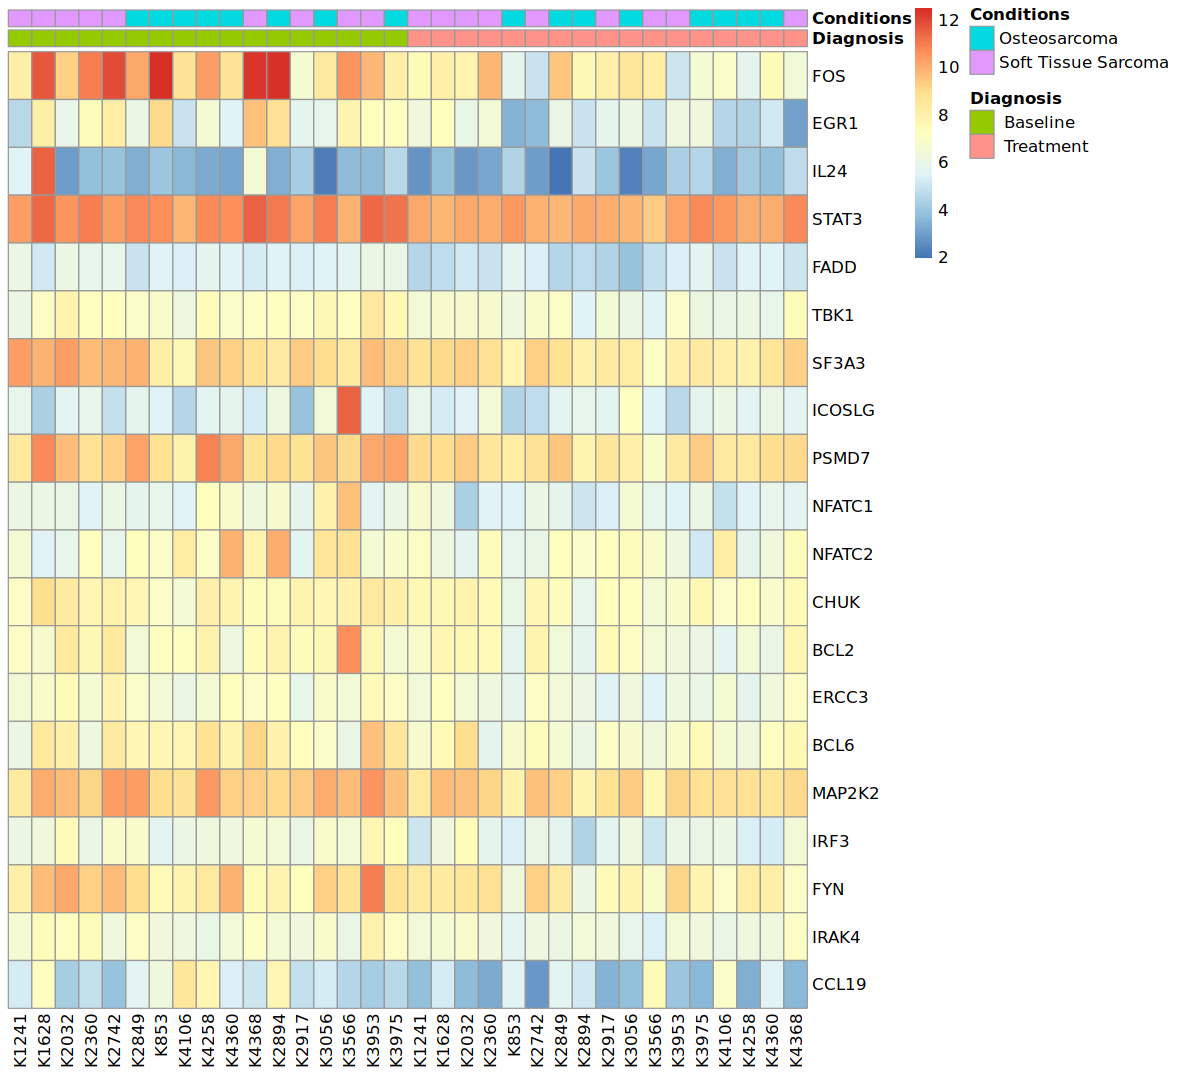

In [276]:
options(repr.plot.width=10, repr.plot.height=9)
pdf("06_baseline_vs_treatment_heatmap.pdf")
# select <- order(rowMeans(counts(de_dds4,normalized=TRUE)),
#                 decreasing=TRUE)[1:15]
# print(select)
df <- as.data.frame(colData(de_dds4)[,c("Diagnosis","Conditions",'pid')])



mt = assay(norm_transform_dds)[row.names( sorted_top_de),][1:20,]
# Get column names
column_names <- colnames(mt)

# Identify columns containing "B_" and "Tx_"
B_columns <- column_names[grepl("B_", column_names)]
Tx_columns <- column_names[grepl("Tx_", column_names)]
# print(B_columns)
# print(Tx_columns)
# Combine the column names with "B_" first and "Tx_" second
sorted_columns <- c(B_columns, Tx_columns)

# Reorder the dataframe with sorted column names
sorted_mt <- mt[, sorted_columns]
sorted_df = df[sorted_columns,]
# print(colnames(sorted_mt))
row.names(sorted_mt) <- row.names(sorted_top_de)[1:20]
# pheatmap(mt, cluster_rows=FALSE, show_rownames=FALSE,
#          cluster_cols=FALSE, annotation_col=df)
genelist <- c('FOS','HLA-DMB' ,'HLA-DRA','IL24', 'EGR1','CTLA4','ARG1','AMBP') 
# Labels to plot
labels <- rownames(sorted_mt) 
# print(labels)
# Set the rest of genes to ""
# labels[!labels %in% genelist] <- "" 

heatmap <- pheatmap(sorted_mt, labels_row = labels, labels_col = sorted_df[,c('pid')],
         cluster_rows=FALSE, show_rownames=TRUE,clustering_distance_rows = "euclidean", 
          cluster_cols=FALSE, annotation_col=sorted_df[,c("Diagnosis","Conditions")], angle_col=90)
# dev.off()


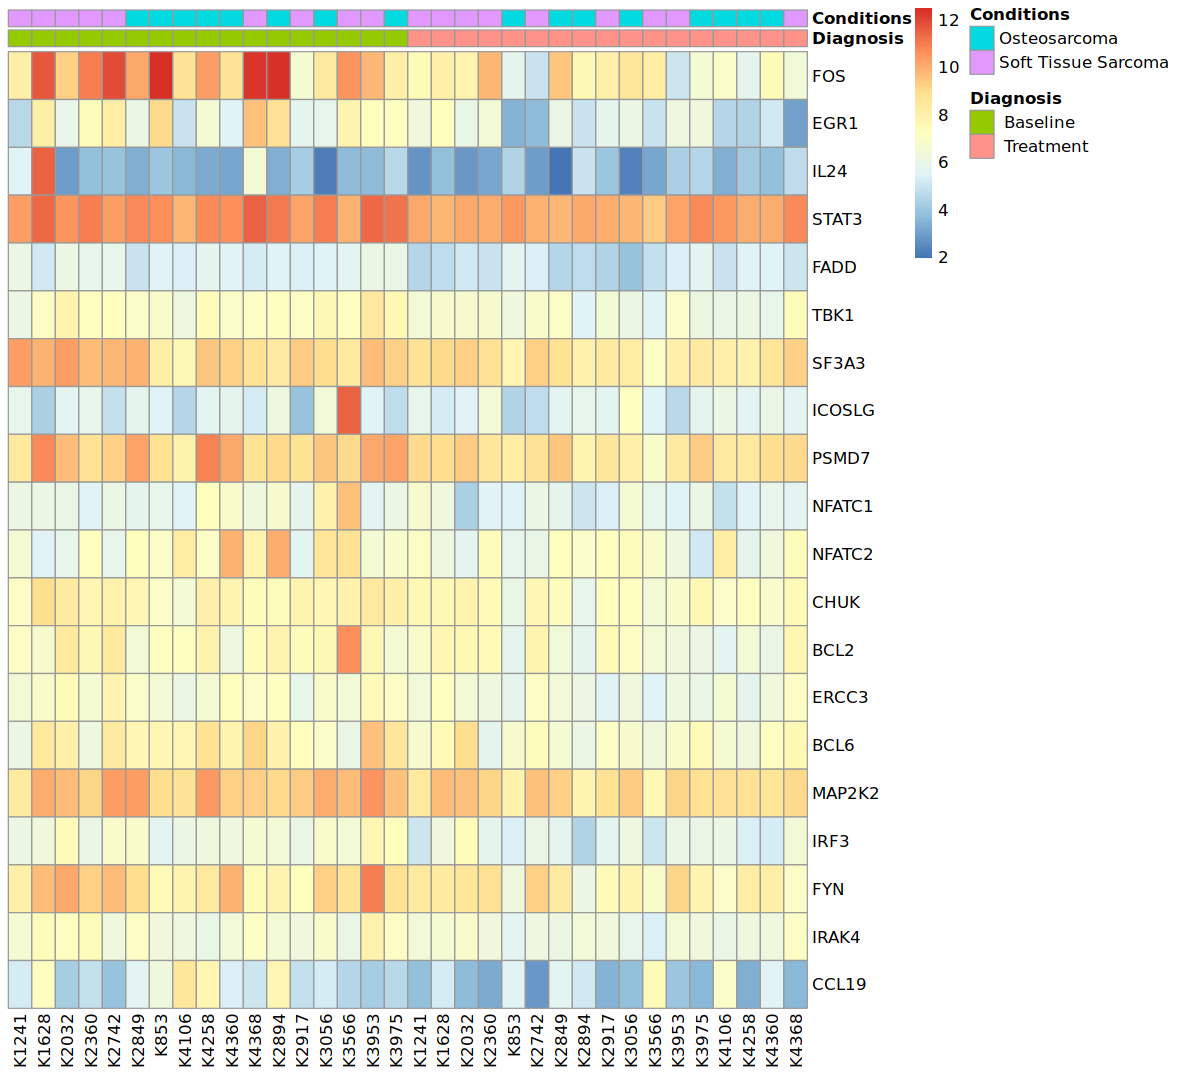

In [277]:
heatmap

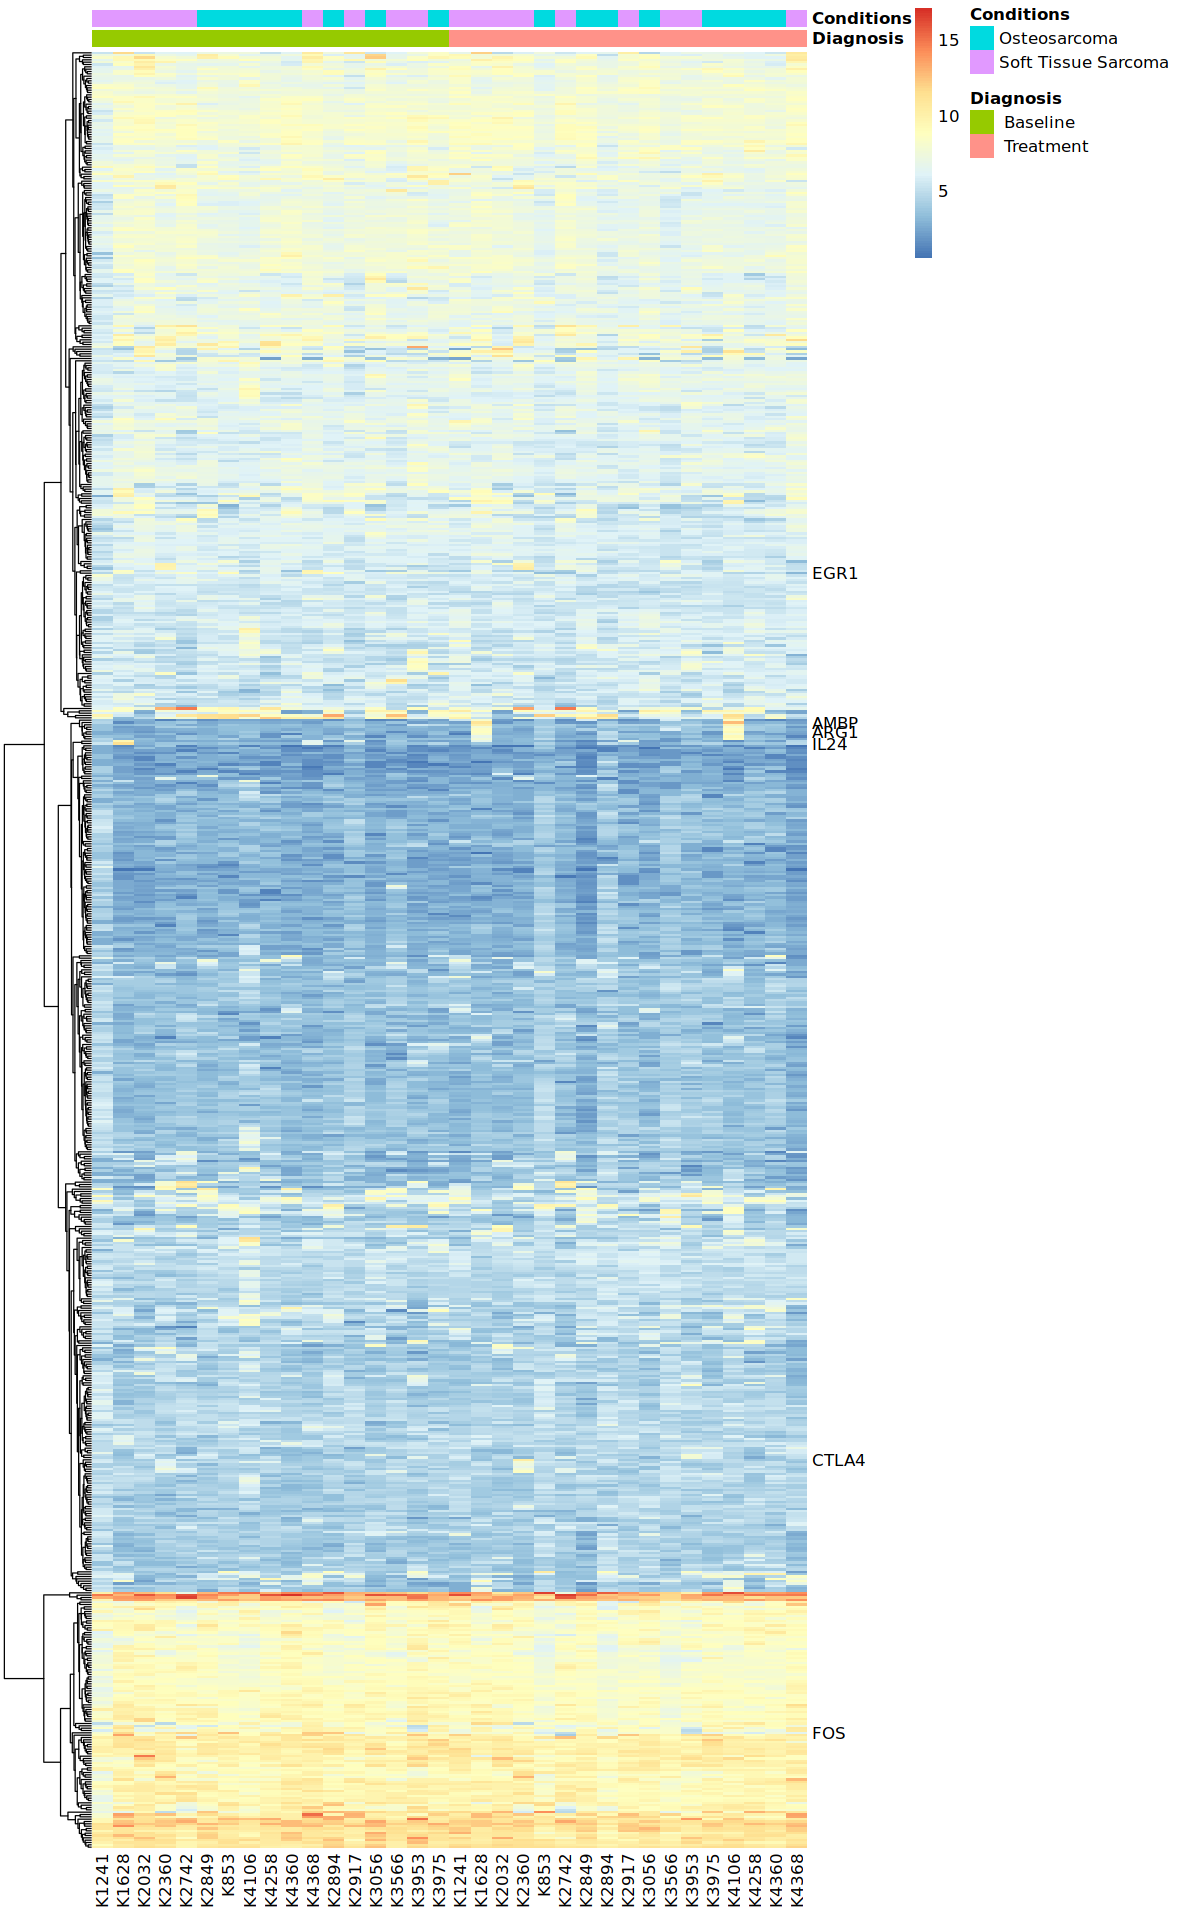

In [66]:
options(repr.plot.width=10, repr.plot.height=16)
# pdf("06_baseline_vs_treatment_heatmap.pdf")
# select <- order(rowMeans(counts(de_dds4,normalized=TRUE)),
#                 decreasing=TRUE)[1:15]
# print(select)
df <- as.data.frame(colData(de_dds4)[,c("Diagnosis","Conditions",'pid')])



mt = assay(norm_transform_dds)
# Get column names
column_names <- colnames(mt)

# Identify columns containing "B_" and "Tx_"
B_columns <- column_names[grepl("B_", column_names)]
Tx_columns <- column_names[grepl("Tx_", column_names)]
# print(B_columns)
# print(Tx_columns)
# Combine the column names with "B_" first and "Tx_" second
sorted_columns <- c(B_columns, Tx_columns)

# Reorder the dataframe with sorted column names
sorted_mt <- mt[, sorted_columns]
sorted_df = df[sorted_columns,]
# print(colnames(sorted_mt))
# row.names(sorted_mt) <- row.names(sorted_top_de)[1:20]
# pheatmap(mt, cluster_rows=FALSE, show_rownames=FALSE,
#          cluster_cols=FALSE, annotation_col=df)
genelist <- c('FOS','IL24', 'EGR1','CTLA4','ARG1','AMBP') 
# Labels to plot
labels <- rownames(sorted_mt) 
# print(labels)
# Set the rest of genes to ""
labels[!labels %in% genelist] <- "" 

heatmap2 <- pheatmap(sorted_mt, labels_row = labels, labels_col = sorted_df[,c('pid')],
         cluster_rows=TRUE, show_rownames=TRUE,clustering_distance_rows = "euclidean", 
          cluster_cols=FALSE, annotation_col=sorted_df[,c("Diagnosis","Conditions")], angle_col=90)

### plot the heatmap with the grouped by baseline and treatment and separate the genes by conditions and cluster in the heatmap

In [278]:
ggsave("06_baseline_vs_treatment_heatmap.pdf", width = 9,
  height = 8, heatmap)
# print(heatmap)
# graphics.off()

## PD vs SD in the baseline

In [22]:
pData(set)

Conditions           Diagnosis  pid  
20230616_210462891024_K1241-B_02.RCC  Soft Tissue Sarcoma   Baseline  K1241
20230616_210462891024_K1628-B_03.RCC  Soft Tissue Sarcoma   Baseline  K1628
20230616_210462891024_K1865-B_04.RCC  Osteosarcoma          Baseline  K1865
20230616_210462891024_K2032-B_05.RCC  Soft Tissue Sarcoma   Baseline  K2032
20230616_210462891024_K2068-B_06.RCC  Soft Tissue Sarcoma   Baseline  K2068
20230616_210462891024_K2323-B_07.RCC  Soft Tissue Sarcoma   Baseline  K2323
20230616_210462891024_K2360-B_08.RCC  Soft Tissue Sarcoma   Baseline  K2360
20230616_210462891024_K2520-B_09.RCC  Soft Tissue Sarcoma   Baseline  K2520
20230616_210462891024_K2669-B_10.RCC  Soft Tissue Sarcoma   Baseline  K2669
20230616_210462891024_K2742-B_11.RCC  Soft Tissue Sarcoma   Baseline  K2742
20230616_210462891024_K2849-B_12.RCC  Osteosarcoma          Baseline  K2849
20230616_210462891024_K853-B_01.RCC   Osteosarcoma          Baseline  K853 
20230707_210462871024_K1241-Tx_09.RCC Soft Tissue Sarcoma   Treatment K1241
20230707_210462871024_K1628-Tx_10.RCC Soft Tissue Sarcoma   Treatment K1628
20230707_210462871024_K2032-Tx_11.RCC Soft Tissue Sarcoma   Treatment K2032
20230707_210462871024_K2360-Tx_12.RCC Soft Tissue Sarcoma   Treatment K2360
20230707_210462871024_K4106-B_01.RCC  Osteosarcoma          Baseline  K4106
20230707_210462871024_K4196-B_02.RCC  Osteosarcoma          Baseline  K4196
20230707_210462871024_K4258-B_03.RCC  Osteosarcoma          Baseline  K4258
20230707_210462871024_K4307-B_04.RCC  Osteosarcoma          Baseline  K4307
20230707_210462871024_K4360-B_05.RCC  Osteosarcoma          Baseline  K4360
20230707_210462871024_K4368-B_06.RCC  Soft Tissue Sarcoma   Baseline  K4368
20230707_210462871024_K5046-B_07.RCC  Osteosarcoma          Baseline  K5046
20230707_210462871024_K853-Tx_08.RCC  Osteosarcoma          Treatment K853 
20230707_210462881024_K2894-B_01.RCC  Osteosarcoma          Baseline  K2894
20230707_210462881024_K2917-B_02.RCC  Soft Tissue Sarcoma   Baseline  K2917
20230707_210462881024_K3056-B_03.RCC  Osteosarcoma          Baseline  K3056
20230707_210462881024_K3566-B_04.RCC  Soft Tissue Sarcoma   Baseline  K3566
20230707_210462881024_K3812-B_05.RCC  Soft Tissue Sarcoma   Baseline  K3812
20230707_210462881024_K3953-B_06.RCC  Soft Tissue Sarcoma   Baseline  K3953
20230707_210462881024_K3975-B_07.RCC  Osteosarcoma          Baseline  K3975
20230707_210462881024_K4010-B_08.RCC  Osteosarcoma          Baseline  K4010
20230707_210462881024_K4020-B_09.RCC  Osteosarcoma          Baseline  K4020
20230707_210462881024_K4023-B_10.RCC  Osteosarcoma          Baseline  K4023
20230707_210462881024_K4054-B_11.RCC  Osteosarcoma          Baseline  K4054
20230707_210462881024_K4093-B_12.RCC  Soft Tissue Sarcoma   Baseline  K4093
20230707_210462901024_K2742-Tx_01.RCC Soft Tissue Sarcoma   Treatment K2742
20230707_210462901024_K2849-Tx_02.RCC Osteosarcoma          Treatment K2849
20230707_210462901024_K2894-Tx_03.RCC Osteosarcoma          Treatment K2894
20230707_210462901024_K2917-Tx_04.RCC Soft Tissue Sarcoma   Treatment K2917
20230707_210462901024_K3056-Tx_05.RCC Osteosarcoma          Treatment K3056
20230707_210462901024_K3566-Tx_06.RCC Soft Tissue Sarcoma   Treatment K3566
20230707_210462901024_K3953-Tx_07.RCC Soft Tissue Sarcoma   Treatment K3953
20230707_210462901024_K3975-Tx_08.RCC Osteosarcoma          Treatment K3975
20230707_210462901024_K4106-Tx_09.RCC Osteosarcoma          Treatment K4106
20230707_210462901024_K4258-Tx_10.RCC Osteosarcoma          Treatment K4258
20230707_210462901024_K4360-Tx_11.RCC Osteosarcoma          Treatment K4360
20230707_210462901024_K4368-Tx_12.RCC Soft Tissue Sarcoma   Treatment K4368
                                      Is_matched Subject_ID RECIST_response
20230616_210462891024_K1241-B_02.RCC  True       TI0045     SD             
20230616_210462891024_K1628-B_03.RCC  True       TI0036     PD             
20230616_210462891024_K1865-B_04.RCC  False      TI0004     PD             
20230616_2

In [23]:
unique(pData(set)$Diagnosis)

[1] " Baseline"  " Treatment"

In [52]:
selected_coldata_baseline  <- subset(pData(set),  Is_matched=="True" & Diagnosis==' Baseline')
# selected_coldata_baseline

In [53]:
subset_count_data_baseline = counts(set)[, row.names(selected_coldata_baseline)]


In [54]:
dds5 <- DESeqDataSetFromMatrix(countData = subset_count_data_baseline,
                              colData = selected_coldata_baseline,
                              design = ~ W_1 + RECIST_response )

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [55]:
de_dds5 <- DESeq(dds5)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [56]:
res_valcanoplot5 <- results(de_dds5)

In [57]:
firstC <- 'PD'
SecondC <- 'SD'
contrast<- c("RECIST_response",firstC,SecondC)
res_deseq5 <- as.data.frame(results(de_dds5))
nam5 <- paste('up_in',firstC, sep = '_')

In [30]:
res_deseq5[, nam5] <- as.logical(res_deseq5$log2FoldChange > 0)

res_deseq5$threshold <- as.logical(res_deseq5$padj < 0.05) 
res_deseq5

baseMean    log2FoldChange lfcSE     stat        pvalue      
A2M     4518.207669 -1.86116625    0.7866065 -2.36607027 0.017978032 
ABCB1     26.567114 -0.02822419    0.5053569 -0.05585002 0.955461284 
ABL1     427.630076 -0.66446199    0.4790599 -1.38701233 0.165438002 
ADA       55.063975 -0.65038990    0.3621479 -1.79592347 0.072506689 
ADORA2A   22.138988  0.72172751    0.3204685  2.25210093 0.024315894 
AICDA     16.260067  1.42058168    0.4943672  2.87353564 0.004059053 
AIRE      16.857612  0.47855988    0.3554035  1.34652545 0.178133119 
AKT3     690.233050 -0.50750311    0.5899671 -0.86022266 0.389666315 
ALCAM    173.604790 -0.83569602    0.6957893 -1.20107627 0.229721615 
AMBP       7.664609  1.01390022    0.3478807  2.91450556 0.003562525 
AMICA1   125.264638  0.75962517    0.4686811  1.62077188 0.105066572 
ANP32B   409.720701 -0.42179908    0.2490908 -1.69335466 0.090387980 
ANXA1   3307.575784 -0.19504493    0.6026085 -0.32366773 0.746189606 
APOE     706.757656  0.16200820    0.6000638  0.26998499 0.787171805 
APP     2649.593904 -0.12506202    0.4519477 -0.27671793 0.781996705 
ARG1       6.658657  0.03327458    0.3350873  0.09930125 0.920899086 
ARG2      39.170081 -0.46281447    0.4754048 -0.97351668 0.330296572 
ATF1     145.428810 -0.68715519    0.2344310 -2.93116208 0.003376965 
ATF2     230.408356 -0.35383994    0.3530220 -1.00231702 0.316190503 
ATG10     63.102626 -0.69010214    0.2462455 -2.80249663 0.005070875 
ATG12     23.059756 -0.30458666    0.3770378 -0.80784127 0.419181964 
ATG16L1   99.083498 -0.32751942    0.2072476 -1.58032922 0.114031491 
ATG5     127.514129 -0.80281178    0.2976768 -2.69692451 0.006998313 
ATG7      76.783168 -0.23062525    0.2421255 -0.95250284 0.340842024 
ATM       12.373774  0.18046620    0.2890416  0.62436056 0.532390822 
AXL      654.283347 -0.16607764    0.4882839 -0.34012519 0.733762250 
BAGE      11.128339 -0.33583792    0.3697109 -0.90837979 0.363677599 
BATF      15.652369  0.45079992    0.2797473  1.61145407 0.107080790 
BAX      453.255152 -0.52409870    0.3671026 -1.42766264 0.153388984 
BCL10    148.576589 -0.58626023    0.2919698 -2.00794833 0.044648783 
⋮       ⋮           ⋮              ⋮         ⋮           ⋮           
DNAJC14  62.88289   -0.30939939    0.2658994 -1.1635956  2.445879e-01
EDC3    311.83785   -0.41098017    0.2555629 -1.6081369  1.078052e-01
EIF2B4  218.64184   -0.66723353    0.2005198 -3.3275193  8.762293e-04
ERCC3   113.12579   -0.11832545    0.2471270 -0.4788042  6.320779e-01
FCF1    958.49130   -0.32529387    0.2430946 -1.3381368  1.808518e-01
G6PD    244.29542   -0.86757514    0.3900992 -2.2239858  2.614940e-02
GPATCH3  69.85805   -0.09393924    0.2595259 -0.3619648  7.173784e-01
GUSB    122.19164    0.38958140    0.3724484  1.0460010  2.955606e-01
HDAC3   164.30126   -0.57677267    0.2096351 -2.7513176  5.935606e-03
HPRT1   376.97997   -1.31819007    0.3302579 -3.9913957  6.568558e-05
MRPS5   247.90409   -0.60142428    0.2448597 -2.4561991  1.404153e-02
MTMR14  196.66560   -0.38159959    0.1521183 -2.5085719  1.212203e-02
NOL7    148.43685   -0.45748949    0.1700630 -2.6901185  7.142666e-03
NUBP1    40.05661   -0.53098514    0.2314044 -2.2946202  2.175490e-02
POLR2A  534.30258   -0.32251870    0.2948514 -1.0938347  2.740275e-01
PPIA    153.57378    0.15189355    0.3717857  0.4085514  6.828689e-01
PRPF38A 251.05532   -0.67626520    0.2484268 -2.7221914  6.485057e-03
SAP130  169.24730   -0.63035292    0.1971569 -3.1972144  1.387617e-03
SDHA    228.66496    0.14148070    0.4648724  0.3043431  7.608665e-01
SF3A3   630.02706   -0.30891092    0.3212828 -0.9614923  3.363047e-01
TBP     133.95994   -0.33928692    0.2331231 -1.4553980  1.455591e-01
TLK2    191.65132   -0.16398460    0.2912411 -0.5630545  5.733978e-01
TMUB2   118.42946   -0.30517144    0.2192733 -1.3917401  1.640011e-01
TRIM39   42.94290   -0.32647939    0.3162017 -1.0325036  3.018363e-01
TUBB    895.67743   -0.98553838    0.2497929 -3.9454213  7.965981e-05
USP39    61.75393 

In [31]:
levels(res_deseq5$RECIST_response)

NULL

In [32]:
norm_mean_w5 <- sapply(levels(de_dds5$RECIST_response), function(lvl) rowMeans( counts(de_dds5,normalized=TRUE)[,de_dds5$RECIST_response == lvl, drop=F] ) )
norm_mean_w5

PD          SD         
A2M     7758.556044 2249.963805
ABCB1     26.391123   26.690307
ABL1     503.355637  374.622183
ADA       69.264606   45.123534
ADORA2A   16.150171   26.331160
AICDA      7.802403   22.180432
AIRE      12.379868   19.992032
AKT3     812.258912  604.814947
ALCAM    234.039996  131.300146
AMBP       4.318023   10.007220
AMICA1    70.043766  163.919249
ANP32B   483.518953  358.061925
ANXA1   3584.883589 3113.460321
APOE     704.190182  708.554888
APP     2788.281209 2552.512791
ARG1       6.391288    6.845816
ARG2      45.847479   34.495902
ATF1     188.109920  115.552033
ATF2     261.377388  208.730034
ATG10     80.352330   51.027833
ATG12     23.596593   22.683970
ATG16L1  114.144014   88.541137
ATG5     172.867472   95.766789
ATG7      84.259995   71.549389
ATM       11.225634   13.177472
AXL      696.946308  624.419274
BAGE      11.957514   10.547917
BATF      12.873942   17.597267
BAX      550.006877  385.528945
BCL10    184.215968  123.629023
⋮       ⋮           ⋮          
DNAJC14   72.04757   56.46761  
EDC3     353.44716  282.71133  
EIF2B4   280.65931  175.22961  
ERCC3    118.84022  109.12568  
FCF1    1058.01647  888.82369  
G6PD     336.49874  179.75310  
GPATCH3   70.69778   69.27024  
GUSB     102.07877  136.27065  
HDAC3    202.22792  137.75260  
HPRT1    590.15456  227.75775  
MRPS5    309.97027  204.45777  
MTMR14   227.65173  174.97531  
NOL7     178.46651  127.41609  
NUBP1     48.77728   33.95215  
POLR2A   606.35429  483.86638  
PPIA     138.76808  163.93777  
PRPF38A  315.18008  206.16799  
SAP130   213.62944  138.17980  
SDHA     217.72837  236.32058  
SF3A3    701.12456  580.25881  
TBP      150.44169  122.42272  
TLK2     202.55137  184.02129  
TMUB2    133.74389  107.70935  
TRIM39    49.20127   38.56205  
TUBB    1253.21603  645.40041  
USP39     81.53756   47.90539  
ZC3H14   314.52221  236.19153  
ZKSCAN5   40.52844   44.19859  
ZNF143    72.57732   63.08664  
ZNF346    73.35710  108.86333

In [33]:
colnames(norm_mean_w5) <- paste('Rowmean_exp_',levels(de_dds5$RECIST_response),sep='')

res5 <- cbind(norm_mean_w5,res_deseq5)
res5

Rowmean_exp_PD Rowmean_exp_SD baseMean    log2FoldChange lfcSE    
A2M     7758.556044    2249.963805    4518.207669 -1.86116625    0.7866065
ABCB1     26.391123      26.690307      26.567114 -0.02822419    0.5053569
ABL1     503.355637     374.622183     427.630076 -0.66446199    0.4790599
ADA       69.264606      45.123534      55.063975 -0.65038990    0.3621479
ADORA2A   16.150171      26.331160      22.138988  0.72172751    0.3204685
AICDA      7.802403      22.180432      16.260067  1.42058168    0.4943672
AIRE      12.379868      19.992032      16.857612  0.47855988    0.3554035
AKT3     812.258912     604.814947     690.233050 -0.50750311    0.5899671
ALCAM    234.039996     131.300146     173.604790 -0.83569602    0.6957893
AMBP       4.318023      10.007220       7.664609  1.01390022    0.3478807
AMICA1    70.043766     163.919249     125.264638  0.75962517    0.4686811
ANP32B   483.518953     358.061925     409.720701 -0.42179908    0.2490908
ANXA1   3584.883589    3113.460321    3307.575784 -0.19504493    0.6026085
APOE     704.190182     708.554888     706.757656  0.16200820    0.6000638
APP     2788.281209    2552.512791    2649.593904 -0.12506202    0.4519477
ARG1       6.391288       6.845816       6.658657  0.03327458    0.3350873
ARG2      45.847479      34.495902      39.170081 -0.46281447    0.4754048
ATF1     188.109920     115.552033     145.428810 -0.68715519    0.2344310
ATF2     261.377388     208.730034     230.408356 -0.35383994    0.3530220
ATG10     80.352330      51.027833      63.102626 -0.69010214    0.2462455
ATG12     23.596593      22.683970      23.059756 -0.30458666    0.3770378
ATG16L1  114.144014      88.541137      99.083498 -0.32751942    0.2072476
ATG5     172.867472      95.766789     127.514129 -0.80281178    0.2976768
ATG7      84.259995      71.549389      76.783168 -0.23062525    0.2421255
ATM       11.225634      13.177472      12.373774  0.18046620    0.2890416
AXL      696.946308     624.419274     654.283347 -0.16607764    0.4882839
BAGE      11.957514      10.547917      11.128339 -0.33583792    0.3697109
BATF      12.873942      17.597267      15.652369  0.45079992    0.2797473
BAX      550.006877     385.528945     453.255152 -0.52409870    0.3671026
BCL10    184.215968     123.629023     148.576589 -0.58626023    0.2919698
⋮       ⋮              ⋮              ⋮           ⋮              ⋮        
DNAJC14   72.04757      56.46761       62.88289   -0.30939939    0.2658994
EDC3     353.44716     282.71133      311.83785   -0.41098017    0.2555629
EIF2B4   280.65931     175.22961      218.64184   -0.66723353    0.2005198
ERCC3    118.84022     109.12568      113.12579   -0.11832545    0.2471270
FCF1    1058.01647     888.82369      958.49130   -0.32529387    0.2430946
G6PD     336.49874     179.75310      244.29542   -0.86757514    0.3900992
GPATCH3   70.69778      69.27024       69.85805   -0.09393924    0.2595259
GUSB     102.07877     136.27065      122.19164    0.38958140    0.3724484
HDAC3    202.22792     137.75260      164.30126   -0.57677267    0.2096351
HPRT1    590.15456     227.75775      376.97997   -1.31819007    0.3302579
MRPS5    309.97027     204.45777      247.90409   -0.60142428    0.2448597
MTMR14   227.65173     174.97531      196.66560   -0.38159959    0.1521183
NOL7     178.46651     127.41609      148.43685   -0.45748949    0.1700630
NUBP1     48.77728      33.95215       40.05661   -0.53098514    0.2314044
POLR2A   606.35429     483.86638      534.30258   -0.32251870    0.2948514
PPIA     138.76808     163.93777      153.57378    0.15189355    0.3717857
PRPF38A  315.18008     206.16799      251.05532   -0.67626520    0.2484268
SAP130   213.62944     138.17980      169.24730   -0.63035292    0.1971569
SDHA     217.72837     236.32058      228.66496    0.14148070    0.4648724
SF3A3    701.12456     580.25881      630.02706   -0.30891092    0.3212828
TBP      150.44169     122.42272      133.95994   -0.33928692    0.2331231
TLK2     202.55137     184.02129 

In [34]:
top_de_genes5 = res5[row.names(res_deseq5)[which(res_deseq5$threshold)],]
top_de_genes5

Rowmean_exp_PD Rowmean_exp_SD baseMean    log2FoldChange lfcSE    
BID           7.912139      18.061481      13.88234  1.0655313     0.3377358
CASP3        76.695224      38.496595      54.22544 -0.9811657     0.3000754
CCL18       171.317151      42.209718      95.37160 -2.1514348     0.7101098
COL3A1    53211.522216   22657.817256   35238.75459 -1.4473042     0.4867314
COLEC12     257.866970      65.726756     144.84331 -1.9382627     0.6364981
CXCL1        15.248661     137.679072      87.26655  2.9408090     0.6994293
CXCL6         6.582982      20.838117      14.96836  1.4989816     0.4570041
DUSP4        26.098668     297.016190     185.46192  3.4622236     0.6762789
F2RL1         5.966061      29.104000      19.57661  2.2385375     0.5287445
FEZ1        355.185776     109.913646     210.90805 -1.6836839     0.5635700
HRAS         85.557207      47.037656      62.89865 -0.8152260     0.2451789
IFIH1       149.907756      51.208246      91.84922 -1.3544199     0.4321936
IFIT1       420.776449      92.733670     227.81011 -1.8632894     0.5697881
IL13RA1     826.416489     410.598139     581.81746 -1.0911691     0.3210328
IL1RL1       15.251700      39.442132      29.48137  1.3201320     0.4312835
IL24        383.784489      15.711564     167.27100 -4.4549000     1.0698854
IRF4         20.391036     305.677092     188.20636  3.7064647     0.7234459
ISG15       907.945946     135.935303     453.82204 -2.4288332     0.5470519
KLRD1         9.073737      22.051994      16.70801  1.2664189     0.4245165
LAG3        135.786786      23.137927      69.52275 -2.4718198     0.6739820
LCN2          4.689583      15.687409      11.15889  1.2720021     0.4122823
LY96        197.598640     112.250961     147.39412 -0.8888937     0.2651206
MAP2K1      318.802457     183.511596     239.21960 -0.8185702     0.1725659
MAP3K7      498.295968     316.076867     391.10826 -0.6677219     0.2255959
MAPK8       176.176859     102.503767     132.83975 -0.7935255     0.2180182
MNX1          4.538617      25.766061      17.02535  2.4779961     0.7114830
MX1        1490.114182     294.373559     786.73735 -2.3124615     0.5711011
NFATC4      172.333636      91.451140     124.75570 -0.9174527     0.2982101
OAS3        239.870102      83.279261     147.75784 -1.4813868     0.4935934
PPBP          8.544928     300.553375     180.31460  2.7582233     0.7714869
PRAME         4.975812     323.460911     192.31999  4.6801362     0.8842546
PSMB7       650.517149     400.307103     503.33477 -0.8664224     0.2199922
RRAD        147.054769      30.511767      78.50006 -2.2766718     0.7261162
RUNX1       174.615962      64.831731     110.03700 -1.3935463     0.3631709
S100A7        6.090271      15.571493      11.66746  1.2370526     0.3234814
SERPINB2     11.978644      31.396374      23.40084  1.3145038     0.4371674
SMAD2       309.313194     175.532032     230.61839 -0.8003203     0.2598113
SMPD3        66.139135       9.357133      32.73796 -2.8298805     0.6826657
SYT17         5.839952      18.638742      13.36865  1.7495148     0.3357353
TICAM2      134.792124      68.080018      95.54971 -1.0084088     0.3390863
TNFRSF10C    17.074116      76.762668      52.18503  1.4505169     0.4107258
TNFSF18       6.018002      14.972887      11.28558  1.2747864     0.3929394
TTK         142.026821      42.887438      83.70954 -1.5521736     0.4804587
EIF2B4      280.659309     175.229608     218.64184 -0.6672335     0.2005198
HPRT1       590.154560     227.757751     376.97997 -1.3181901     0.3302579
SAP130      213.629444     138.179803     169.24730 -0.6303529     0.1971569
TUBB       1253.216033     645.400406     895.67743 -0.9855384     0.2497929
USP39        81.537559      47.905392      61.75393 -0.7273658     0.2259418
          stat      pvalue       padj         up_in_PD threshold
BID        3.154925 1.605392e-03 3.745915e-02  TRUE    TRUE     
CASP3     -3.269731 1.076499e-03 2.960373e-02 FALSE    TRUE     
CCL18     -3.029721 2.447795e-03 4.597078e

In [35]:
write.csv(top_de_genes5, '06_DE_genes_PD_vs_SD_matched_id_baseline_only.csv')

In [338]:
log2(18.061481/7.912139)

[1] 1.190777

In [339]:
log2(38.496595/76.695224)

[1] -0.9944059

In [36]:
options(repr.plot.width=17, repr.plot.height=17)
# pdf("05_PS_vs_SD_volcano_plot.pdf")
# pdf('06_Baseline_vs_Treatment_volcano_plot_matched_id.pdf')
sdvspd_volplot5 <- EnhancedVolcano(res_valcanoplot5,
                lab = rownames(res_valcanoplot5), selectLab = row.names(top_de_genes5),
                x = 'log2FoldChange',
                y = 'pvalue', title = 'RECIST_response PD vs SD among baseline',
                pCutoff = 0.01, drawConnectors = FALSE,max.overlaps = 30,
                FCcutoff = 0.58,
                pointSize = 2.0,
                labSize = 6.0)
# dev.off()
# sdvspd_volplot4

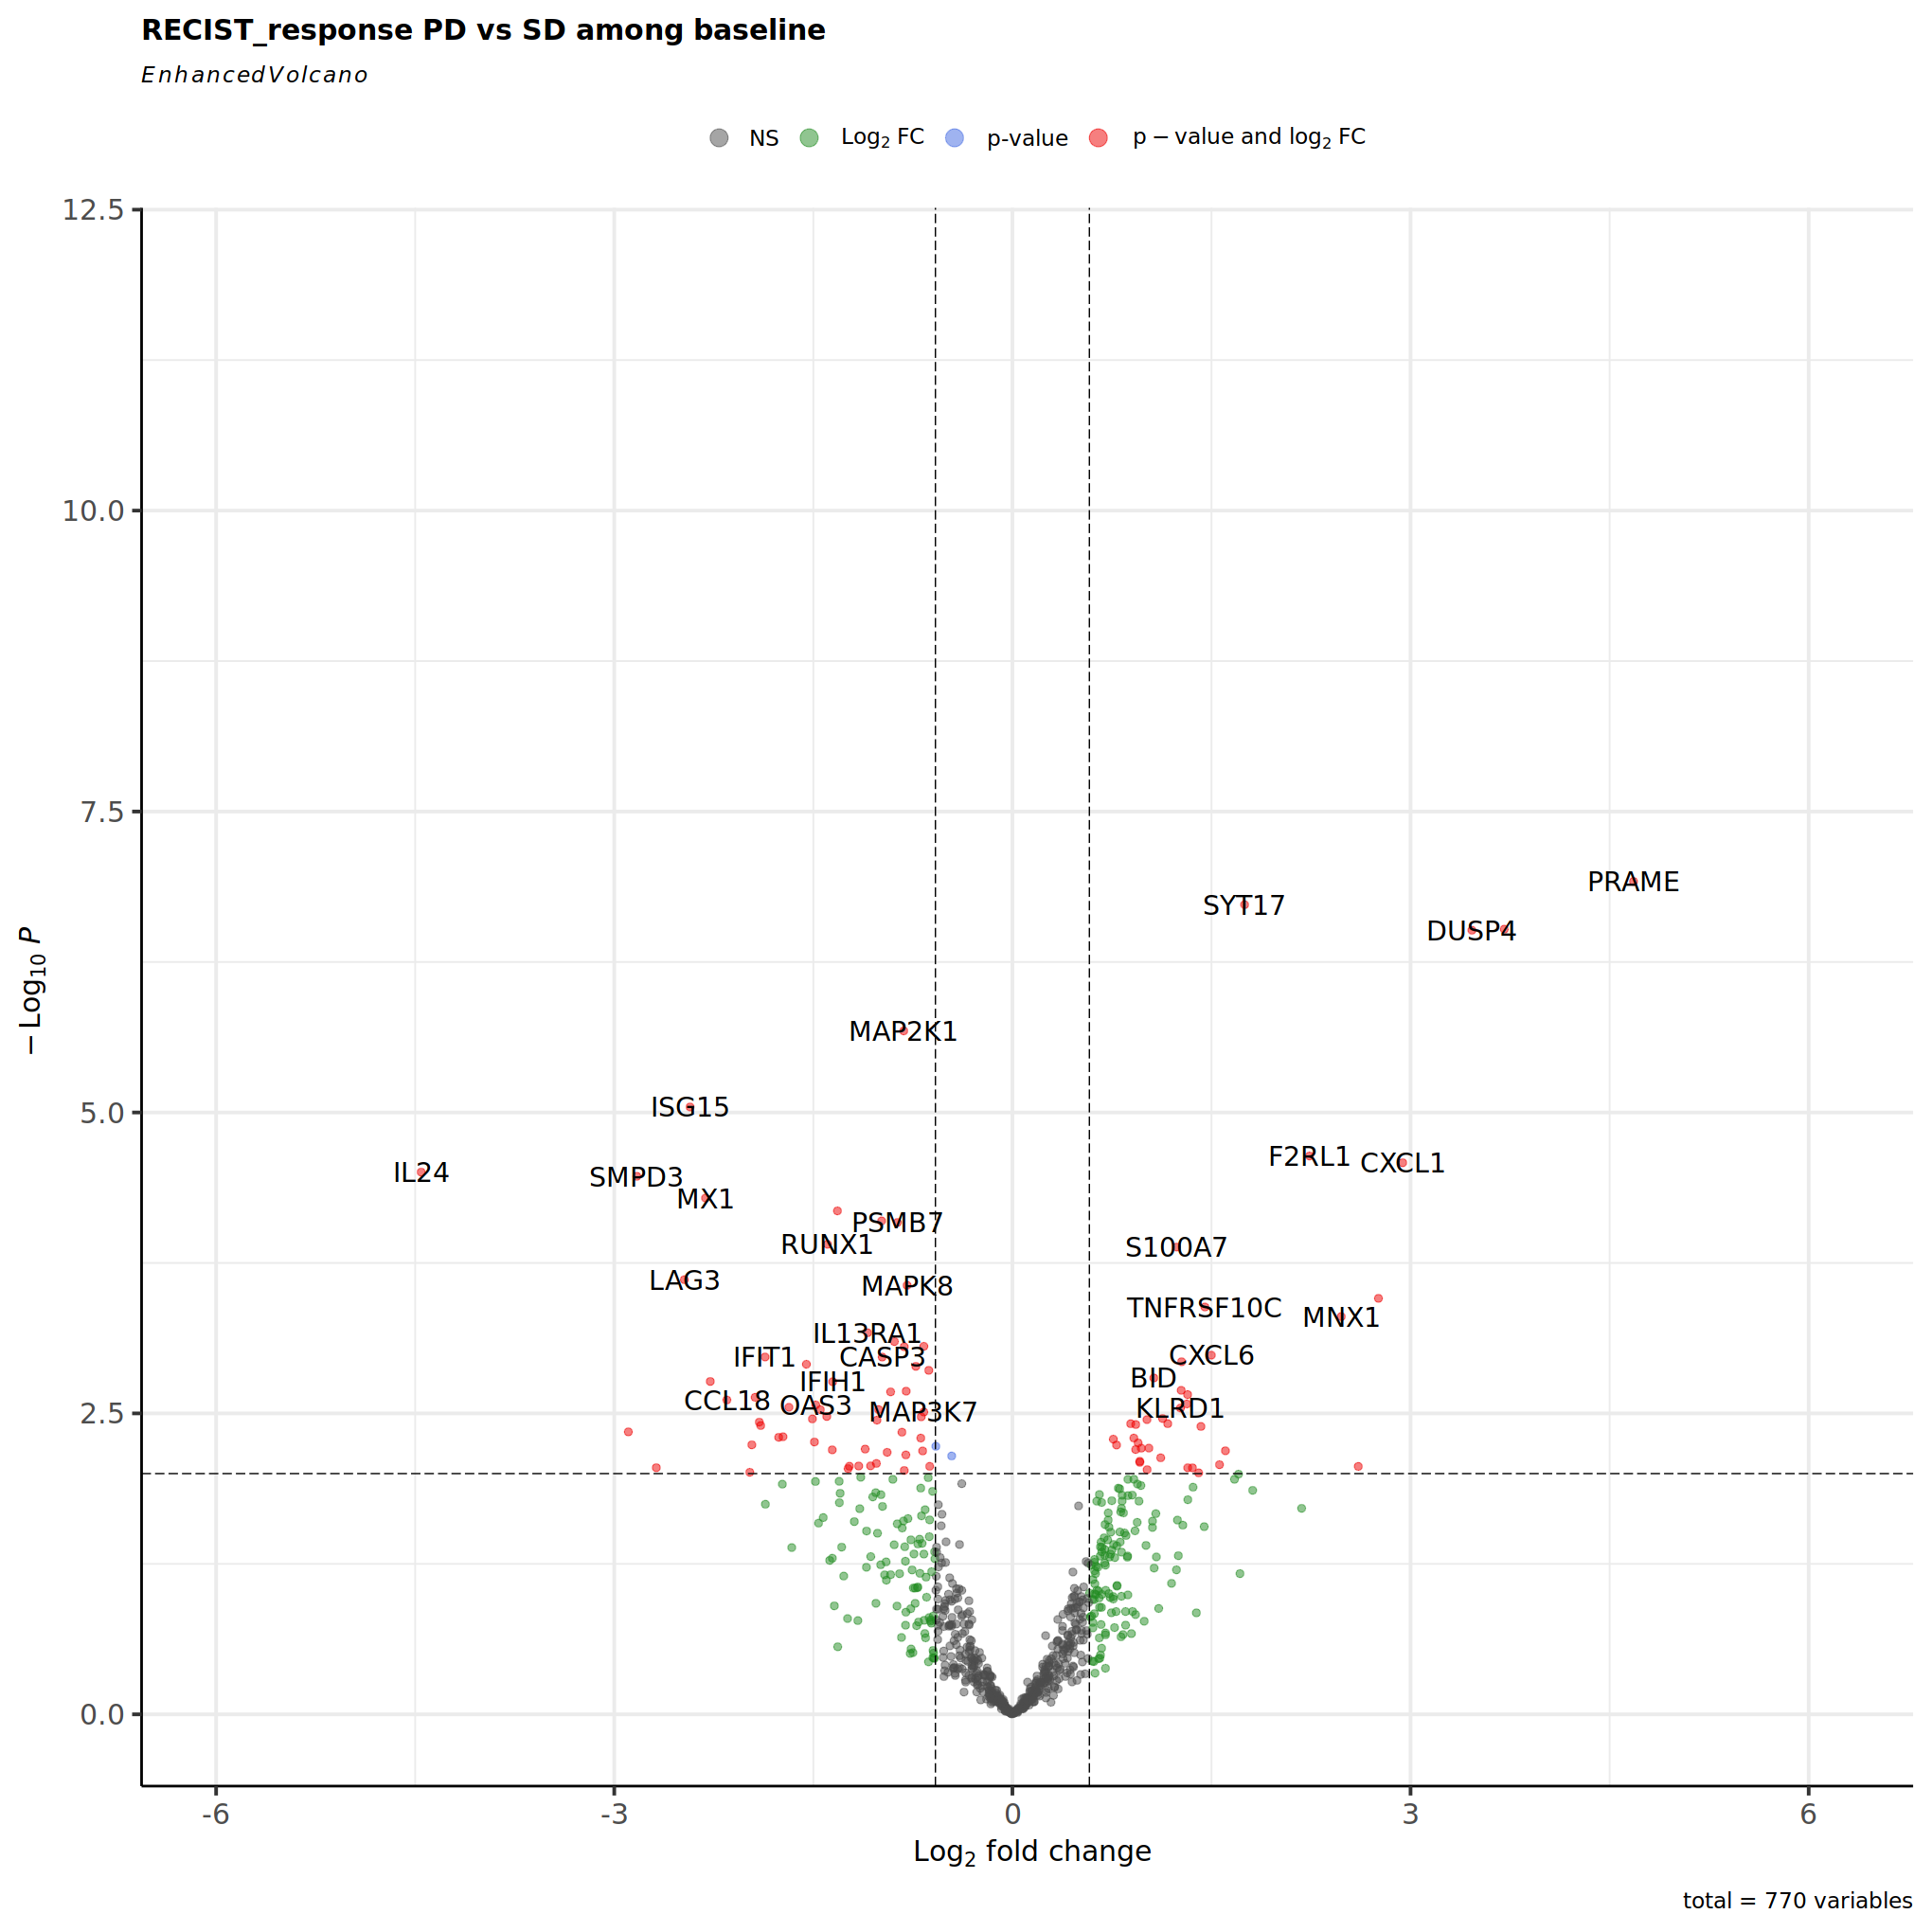

In [37]:
sdvspd_volplot5

In [38]:
ggsave("06_PD_vs_SD_volcano_plot_matched_id_baseline_only.pdf", 
       width = 10,
       height = 10, sdvspd_volplot5)

In [39]:
goi5_1 = c('PRAME', 'DUSP4', 'SYT17', 'CXCL1')
goi5_1

[1] "PRAME" "DUSP4" "SYT17" "CXCL1"

In [40]:
tcounts5_1 <- t(log2((counts(de_dds5[goi5_1, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(de_dds5), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi5_1)+1):ncol(.))

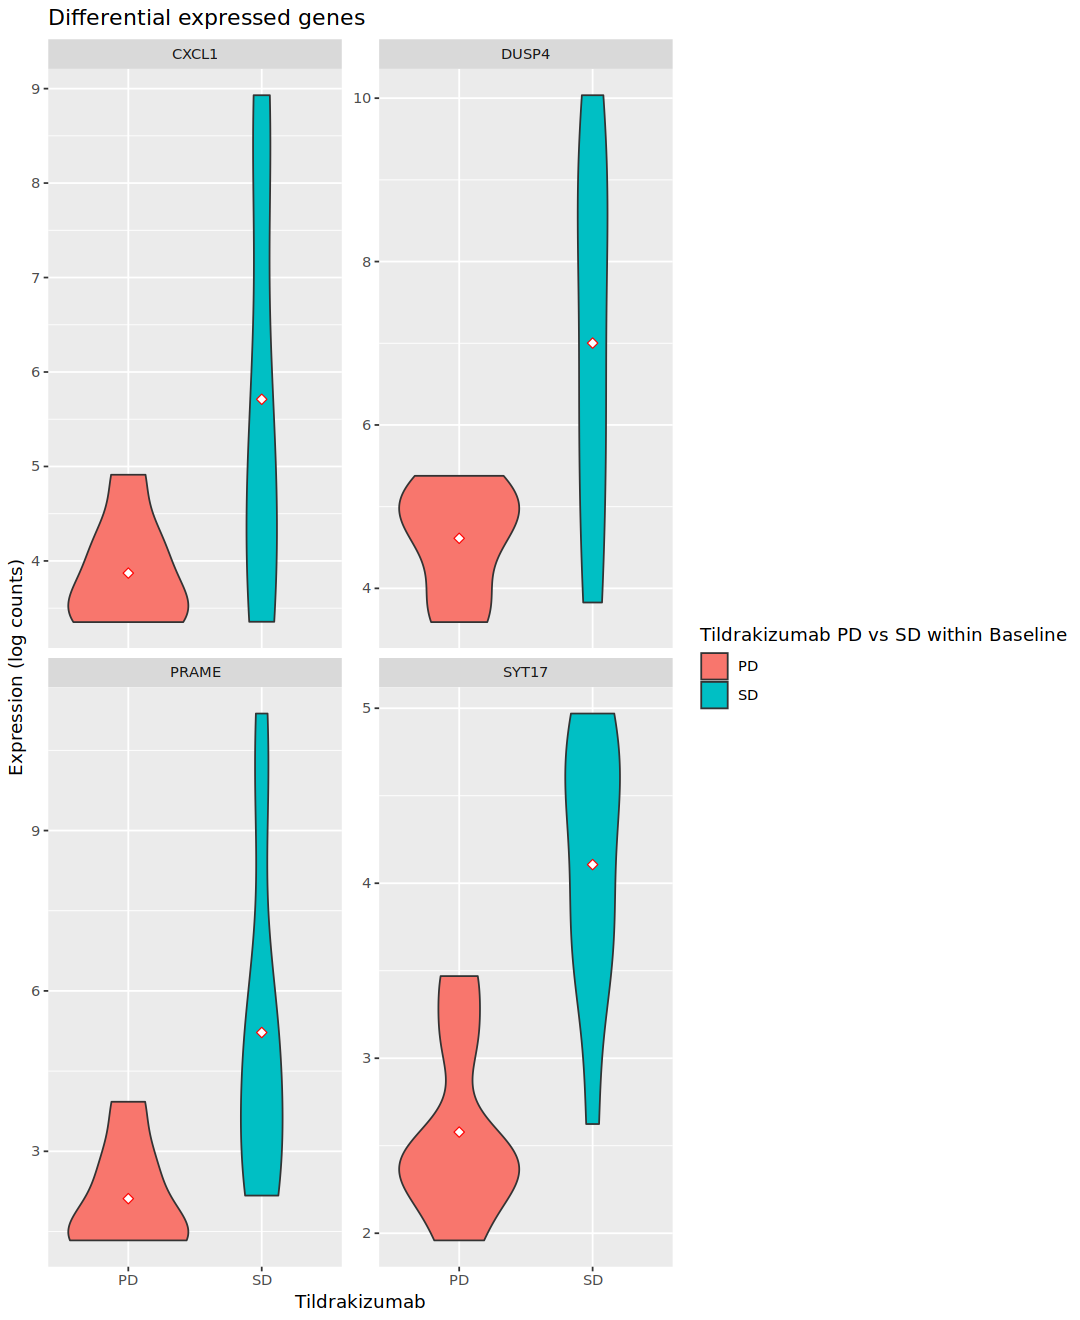

In [45]:
options(repr.plot.width=9, repr.plot.height=11)
# pdf("06_baseline_vs_treatment_violin_plot2.pdf")
sd_boxplot5 = ggplot(tcounts5_1, aes(RECIST_response, expression, fill=RECIST_response)) + 
  geom_violin() + 
  stat_summary(fun = mean, geom = "point", shape = 23, size = 2, color = "red", fill = "white") + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab PD vs SD within Baseline", 
       title="Differential expressed genes")
# dev.off()
sd_boxplot5

In [46]:
ggsave("06_PD_vs_SD_violin_plot_matched_id_within_baseline.pdf", 
       width = 9,
       height = 10, sd_boxplot5)

In [47]:
norm_transform_dds5 <- normTransform(de_dds5)
norm_transform_dds5

class: DESeqTransform 
dim: 770 17 
metadata(1): version
assays(1): ''
rownames(770): A2M ABCB1 ... ZNF143 ZNF346
rowData names(26): baseMean baseVar ... deviance maxCooks
colnames(17): 20230616_210462891024_K1241-B_02.RCC
  20230616_210462891024_K1628-B_03.RCC ...
  20230707_210462881024_K3953-B_06.RCC
  20230707_210462881024_K3975-B_07.RCC
colData names(10): Conditions Diagnosis ... W_1 sizeFactor

In [48]:
sorted_top_de5 = top_de_genes5[order(top_de_genes5$up_in_PD==TRUE, top_de_genes5$padj),]

In [51]:
col_labels5 = as.data.frame(colData(de_dds5)[,c('pid',"Diagnosis",'Conditions',"RECIST_response")])
col_labels5

pid   Diagnosis Conditions          
20230616_210462891024_K1241-B_02.RCC K1241  Baseline Soft Tissue Sarcoma 
20230616_210462891024_K1628-B_03.RCC K1628  Baseline Soft Tissue Sarcoma 
20230616_210462891024_K2032-B_05.RCC K2032  Baseline Soft Tissue Sarcoma 
20230616_210462891024_K2360-B_08.RCC K2360  Baseline Soft Tissue Sarcoma 
20230616_210462891024_K2742-B_11.RCC K2742  Baseline Soft Tissue Sarcoma 
20230616_210462891024_K2849-B_12.RCC K2849  Baseline Osteosarcoma        
20230616_210462891024_K853-B_01.RCC  K853   Baseline Osteosarcoma        
20230707_210462871024_K4106-B_01.RCC K4106  Baseline Osteosarcoma        
20230707_210462871024_K4258-B_03.RCC K4258  Baseline Osteosarcoma        
20230707_210462871024_K4360-B_05.RCC K4360  Baseline Osteosarcoma        
20230707_210462871024_K4368-B_06.RCC K4368  Baseline Soft Tissue Sarcoma 
20230707_210462881024_K2894-B_01.RCC K2894  Baseline Osteosarcoma        
20230707_210462881024_K2917-B_02.RCC K2917  Baseline Soft Tissue Sarcoma 
20230707_210462881024_K3056-B_03.RCC K3056  Baseline Osteosarcoma        
20230707_210462881024_K3566-B_04.RCC K3566  Baseline Soft Tissue Sarcoma 
20230707_210462881024_K3953-B_06.RCC K3953  Baseline Soft Tissue Sarcoma 
20230707_210462881024_K3975-B_07.RCC K3975  Baseline Osteosarcoma        
                                     RECIST_response
20230616_210462891024_K1241-B_02.RCC SD             
20230616_210462891024_K1628-B_03.RCC PD             
20230616_210462891024_K2032-B_05.RCC PD             
20230616_210462891024_K2360-B_08.RCC SD             
20230616_210462891024_K2742-B_11.RCC SD             
20230616_210462891024_K2849-B_12.RCC PD             
20230616_210462891024_K853-B_01.RCC  SD             
20230707_210462871024_K4106-B_01.RCC SD             
20230707_210462871024_K4258-B_03.RCC PD             
20230707_210462871024_K4360-B_05.RCC PD             
20230707_210462871024_K4368-B_06.RCC PD             
20230707_210462881024_K2894-B_01.RCC SD             
20230707_210462881024_K2917-B_02.RCC SD             
20230707_210462881024_K3056-B_03.RCC PD             
20230707_210462881024_K3566-B_04.RCC SD             
20230707_210462881024_K3953-B_06.RCC SD             
20230707_210462881024_K3975-B_07.RCC SD

In [63]:
sorted_df

pid   Diagnosis Conditions          
20230616_210462891024_K1628-B_03.RCC K1628  Baseline Soft Tissue Sarcoma 
20230616_210462891024_K2032-B_05.RCC K2032  Baseline Soft Tissue Sarcoma 
20230616_210462891024_K2849-B_12.RCC K2849  Baseline Osteosarcoma        
20230707_210462871024_K4258-B_03.RCC K4258  Baseline Osteosarcoma        
20230707_210462871024_K4360-B_05.RCC K4360  Baseline Osteosarcoma        
20230707_210462871024_K4368-B_06.RCC K4368  Baseline Soft Tissue Sarcoma 
20230707_210462881024_K3056-B_03.RCC K3056  Baseline Osteosarcoma        
20230616_210462891024_K1241-B_02.RCC K1241  Baseline Soft Tissue Sarcoma 
20230616_210462891024_K2360-B_08.RCC K2360  Baseline Soft Tissue Sarcoma 
20230616_210462891024_K2742-B_11.RCC K2742  Baseline Soft Tissue Sarcoma 
20230616_210462891024_K853-B_01.RCC  K853   Baseline Osteosarcoma        
20230707_210462871024_K4106-B_01.RCC K4106  Baseline Osteosarcoma        
20230707_210462881024_K2894-B_01.RCC K2894  Baseline Osteosarcoma        
20230707_210462881024_K2917-B_02.RCC K2917  Baseline Soft Tissue Sarcoma 
20230707_210462881024_K3566-B_04.RCC K3566  Baseline Soft Tissue Sarcoma 
20230707_210462881024_K3953-B_06.RCC K3953  Baseline Soft Tissue Sarcoma 
20230707_210462881024_K3975-B_07.RCC K3975  Baseline Osteosarcoma        
                                     RECIST_response
20230616_210462891024_K1628-B_03.RCC PD             
20230616_210462891024_K2032-B_05.RCC PD             
20230616_210462891024_K2849-B_12.RCC PD             
20230707_210462871024_K4258-B_03.RCC PD             
20230707_210462871024_K4360-B_05.RCC PD             
20230707_210462871024_K4368-B_06.RCC PD             
20230707_210462881024_K3056-B_03.RCC PD             
20230616_210462891024_K1241-B_02.RCC SD             
20230616_210462891024_K2360-B_08.RCC SD             
20230616_210462891024_K2742-B_11.RCC SD             
20230616_210462891024_K853-B_01.RCC  SD             
20230707_210462871024_K4106-B_01.RCC SD             
20230707_210462881024_K2894-B_01.RCC SD             
20230707_210462881024_K2917-B_02.RCC SD             
20230707_210462881024_K3566-B_04.RCC SD             
20230707_210462881024_K3953-B_06.RCC SD             
20230707_210462881024_K3975-B_07.RCC SD

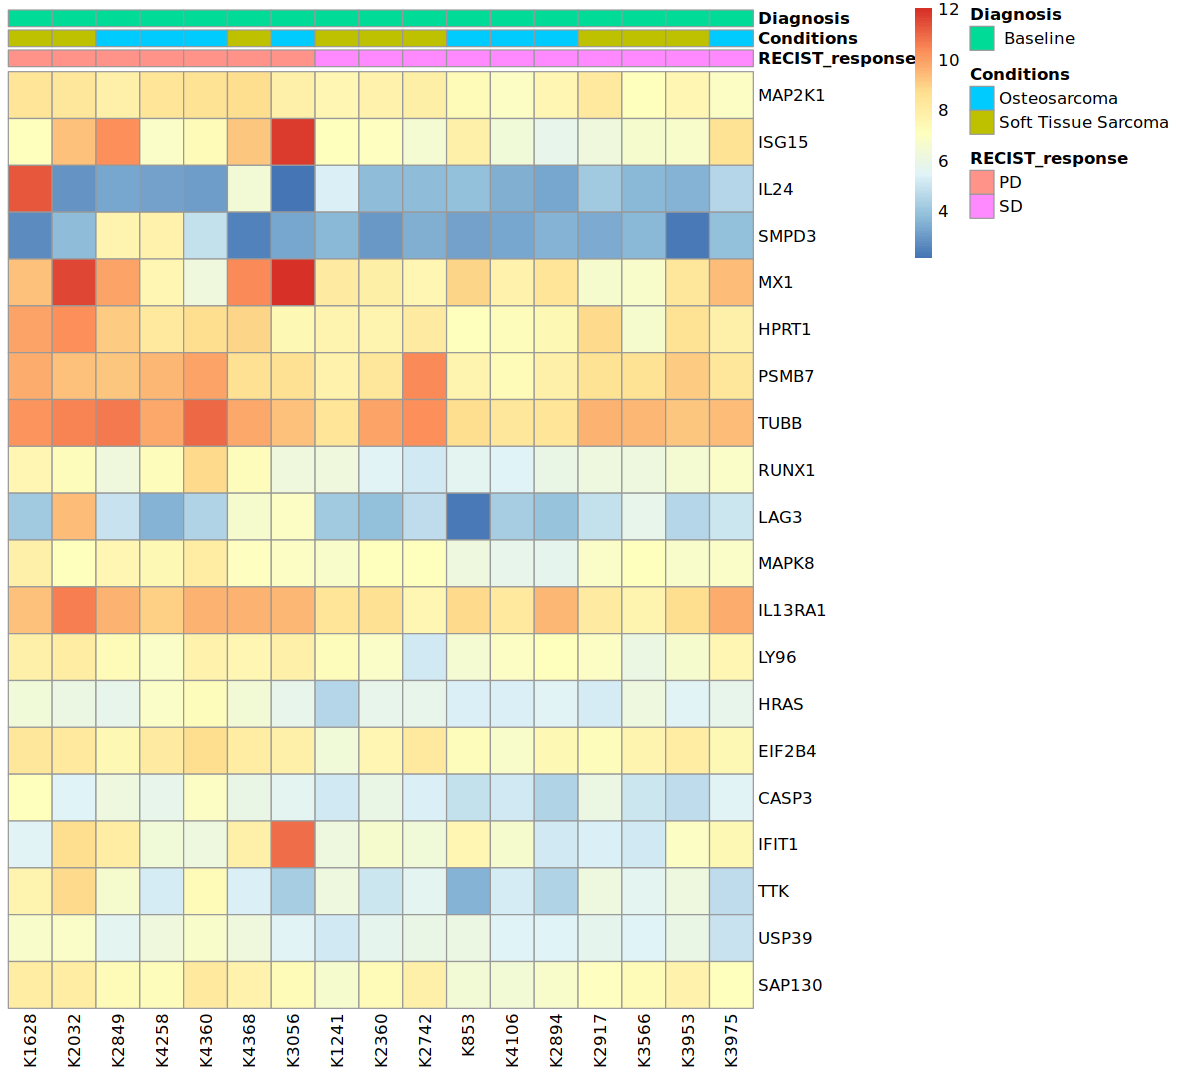

In [66]:
options(repr.plot.width=10, repr.plot.height=9)
# pdf("06_baseline_vs_treatment_heatmap.pdf")
# select <- order(rowMeans(counts(de_dds4,normalized=TRUE)),
#                 decreasing=TRUE)[1:15]
# print(select)
df <- as.data.frame(colData(de_dds5)[,c('pid',"Diagnosis",'Conditions',"RECIST_response")])



mt = assay(norm_transform_dds5)[row.names( sorted_top_de5),][1:20,]
# Get column names
column_names <- colnames(mt)

# Identify columns containing "B_" and "Tx_"
B_columns <- column_names[grepl("B_", column_names)]
Tx_columns <- column_names[grepl("Tx_", column_names)]
# print(B_columns)
# print(Tx_columns)
# Combine the column names with "B_" first and "Tx_" second
sorted_columns <- c(B_columns, Tx_columns)

# Reorder the dataframe with sorted column names
sorted_mt <- mt[, sorted_columns]
# row_names <- row.names(mt)
# pd_columns <- row.names[grepl("B_", column_names)]
# sd_columns <- row.names[grepl("Tx_", column_names)]
sorted_df = df[order(df$RECIST_response),]
# print(colnames(sorted_mt))
row.names(sorted_mt) <- row.names(sorted_top_de5)[1:20]
sorted_mt = sorted_mt[,row.names(sorted_df)]
# pheatmap(mt, cluster_rows=FALSE, show_rownames=FALSE,
#          cluster_cols=FALSE, annotation_col=df)
# genelist <- c('FOS','HLA-DMB' ,'HLA-DRA','IL24', 'EGR1','CTLA4','ARG1','AMBP') 
# Labels to plot
labels <- rownames(sorted_mt) 
# print(labels)
# Set the rest of genes to ""
# labels[!labels %in% genelist] <- "" 

heatmap2 <- pheatmap(sorted_mt, labels_row = labels, labels_col = sorted_df[,c('pid')],
         cluster_rows=FALSE, show_rownames=TRUE,clustering_distance_rows = "euclidean", 
          cluster_cols=FALSE, annotation_col=sorted_df[,c("RECIST_response","Conditions","Diagnosis")], angle_col=90)
# dev.off()

In [67]:
ggsave("06_PD_vs_SD_heatmap_matched_id_baseline_only.pdf", width = 10,
  height = 9, heatmap2)

### PD vs SD within treatment

In [68]:

selected_coldata_treatment  <- subset(pData(set),  Is_matched=="True" & Diagnosis==' Treatment')

In [69]:
subset_count_data_treatment = counts(set)[, row.names(selected_coldata_treatment)]

In [70]:
dds6 <- DESeqDataSetFromMatrix(countData = subset_count_data_treatment,
                              colData = selected_coldata_treatment,
                              design = ~ W_1 + RECIST_response )

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [71]:
de_dds6 <- DESeq(dds6)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing



In [72]:
res_valcanoplot6 <- results(de_dds6)

In [80]:
firstC <- 'PD'
SecondC <- 'SD'
contrast<- c("RECIST_response",firstC,SecondC)
res_deseq6 <- as.data.frame(results(de_dds6))
nam6 <- paste('up_in',firstC, sep = '_')

In [81]:
res_deseq6[, nam6] <- as.logical(res_deseq6$log2FoldChange < 0)

res_deseq6$threshold <- as.logical(res_deseq6$padj < 0.05) 
res_deseq6

baseMean   log2FoldChange lfcSE     stat        pvalue       padj      
A2M     3172.59805 -0.90838230    0.6121662 -1.4838818  0.13784028   0.3774607 
ABCB1     39.30813  0.81388693    0.4175765  1.9490728  0.05128673   0.2381950 
ABL1     354.45185 -0.08331234    0.4235378 -0.1967058  0.84405777   0.9205729 
ADA       58.19889 -0.05711046    0.3488386 -0.1637160  0.86995474   0.9296253 
ADORA2A   35.59469  0.33913464    0.4904870  0.6914244  0.48929890   0.7245388 
AICDA     13.24976  0.69653506    0.4930003  1.4128492  0.15770006   0.4065115 
AIRE      22.59312  0.71533914    0.4038742  1.7711929  0.07652863   0.2820198 
AKT3     592.08921  0.08296361    0.6257325  0.1325864  0.89452049   0.9384253 
ALCAM    210.66061  0.14105480    0.6327494  0.2229236  0.82359494   0.9098538 
AMBP     583.18891 -2.17732744    1.6824084 -1.2941729  0.19560569   0.4605543 
AMICA1   116.52275  0.12240599    0.2469533  0.4956645  0.62013116   0.7897622 
ANP32B   397.43281 -0.23018122    0.3104087 -0.7415424  0.45836465   0.7087164 
ANXA1   2452.96489 -0.58922336    0.5819954 -1.0124192  0.31133764   0.5794138 
APOE     847.12314 -0.69555698    0.6657698 -1.0447409  0.29614271   0.5743826 
APP     2039.86982  0.17627210    0.3812108  0.4624006  0.64379408   0.8025940 
ARG1      71.84830  0.20201166    1.2623926  0.1600229  0.87286307   0.9308927 
ARG2      63.23169 -1.11563605    0.5889874 -1.8941594  0.05820385   0.2544753 
ATF1     136.22792 -0.28259722    0.2237331 -1.2631000  0.20655323   0.4747641 
ATF2     245.48646 -0.17666994    0.3117417 -0.5667191  0.57090507   0.7725780 
ATG10     52.19742 -0.59020389    0.2657386 -2.2209941  0.02635136   0.1811656 
ATG12     26.71673 -0.13292228    0.3502580 -0.3794982  0.70431795   0.8330642 
ATG16L1  106.31343 -0.26378530    0.2485307 -1.0613789  0.28851772   0.5699234 
ATG5     135.21071 -0.34530854    0.1885214 -1.8316671  0.06700103   0.2687020 
ATG7      83.47791 -0.25328948    0.2673989 -0.9472347  0.34351922   0.6097821 
ATM       14.61132  1.03615946    0.4339806  2.3875712  0.01696012   0.1484010 
AXL      617.89964 -0.10923555    0.5108014 -0.2138513  0.83066302   0.9137293 
BAGE      23.36389  0.47957189    0.5688490  0.8430565  0.39919683   0.6694733 
BATF      20.69387  0.24729996    0.3360475  0.7359078  0.46178681   0.7108832 
BAX      419.07241 -0.36437278    0.2838019 -1.2838984  0.19917751   0.4647475 
BCL10    147.55853 -0.56165865    0.2576659 -2.1797938  0.02927275   0.1872345 
⋮       ⋮          ⋮              ⋮         ⋮           ⋮            ⋮         
DNAJC14  76.41898   0.092622759   0.1918102  0.48288767 0.6291754985 0.79290529
EDC3    303.27778  -0.354581496   0.2871635 -1.23477213 0.2169153240 0.49124941
EIF2B4  225.49747  -0.444190431   0.2195646 -2.02305146 0.0430678418 0.22406918
ERCC3    89.20124  -0.334228675   0.2163757 -1.54466840 0.1224264919 0.35306516
FCF1    797.40442  -0.126962130   0.2827470 -0.44903089 0.6534093759 0.80259399
G6PD    190.96963  -1.165802196   0.3427743 -3.40107863 0.0006712052 0.03691628
GPATCH3  67.46086   0.183615665   0.2356754  0.77910400 0.4359184534 0.69231624
GUSB    156.22017   0.797796839   0.4438440  1.79747117 0.0722608518 0.27576878
HDAC3   183.33432  -0.589991928   0.1961275 -3.00820566 0.0026279523 0.06902411
HPRT1   336.66083  -0.821022531   0.3109467 -2.64039641 0.0082809103 0.10627168
MRPS5   312.80121  -0.429908352   0.2639837 -1.62854139 0.1034101400 0.31978236
MTMR14  183.95663  -0.297746672   0.2256747 -1.31936200 0.1870481180 0.44760127
NOL7    168.39936  -0.416071189   0.2573146 -1.61697445 0.1058837961 0.32482280
NUBP1    52.13864  -0.495889146   0.2137296 -2.32017047 0.0203316575 0.15902646
POLR2A  539.13040   0.180678870   0.3374229  0.53546708 0.5923269145 0.78156093
PPIA    170.57904   0.333351125   0.3141679  1.06106031 0.2886624930 0.56992338
PRPF38A 306.53778  -0.635934941   0.2951000 -2.15498139 0.0311632907 0.18894279
SAP130  164.72619  -0.870867527   0.2634038 -3.30620664 0.0009456832 0.04283389
SDHA    

In [82]:
norm_mean_w6 <- sapply(levels(de_dds6$RECIST_response), function(lvl) rowMeans( counts(de_dds6,normalized=TRUE)[,de_dds6$RECIST_response == lvl, drop=F] ) )
norm_mean_w6

PD          SD        
A2M     4302.733139 2381.50348
ABCB1     26.340508   48.38546
ABL1     369.018618  344.25512
ADA       58.444794   58.02676
ADORA2A   31.042342   38.78133
AICDA      9.748986   15.70030
AIRE      16.034275   27.18432
AKT3     588.243380  594.78129
ALCAM    222.156400  202.61355
AMBP     344.890712  749.99765
AMICA1   108.180354  122.36243
ANP32B   426.074753  377.38345
ANXA1   3067.934661 2022.48605
APOE    1085.091731  680.54513
APP     1897.068070 2139.83104
ARG1      70.318619   72.91908
ARG2      93.799748   41.83406
ATF1     152.966260  124.51108
ATF2     256.463828  237.80230
ATG10     63.802462   44.07388
ATG12     25.730905   27.40681
ATG16L1  116.723614   99.02629
ATG5     153.910470  122.12087
ATG7      91.636083   77.76719
ATM        8.463549   18.91476
AXL      648.938307  596.17257
BAGE      17.305714   27.60462
BATF      18.734256   22.06561
BAX      481.959107  375.05172
BCL10    182.482974  123.11143
⋮       ⋮           ⋮         
DNAJC14   73.08163   78.75513 
EDC3     346.57205  272.97178 
EIF2B4   265.99590  197.14856 
ERCC3    102.04532   80.21039 
FCF1     830.55266  774.20065 
G6PD     282.90563  126.61443 
GPATCH3   62.12663   71.19482 
GUSB     109.95503  188.60576 
HDAC3    226.01541  153.45756 
HPRT1    458.83117  251.14159 
MRPS5    363.65593  277.20290 
MTMR14   206.89055  167.90289 
NOL7     197.56981  147.98004 
NUBP1     63.47450   44.20354 
POLR2A   501.96464  565.14643 
PPIA     141.74448  190.76324 
PRPF38A  383.72342  252.50784 
SAP130   226.72723  121.32547 
SDHA     229.37683  206.92506 
SF3A3    472.16756  344.79727 
TBP      176.36590  150.86944 
TLK2     140.91903  155.86711 
TMUB2    124.81200  125.46390 
TRIM39    50.04962   48.22482 
TUBB    1273.68612  805.96273 
USP39    102.73236   67.80078 
ZC3H14   267.19401  225.07320 
ZKSCAN5   49.47865   46.44239 
ZNF143    67.60503   65.53877 
ZNF346    99.70633   90.87474

In [83]:
colnames(norm_mean_w6) <- paste('Rowmean_exp_',levels(de_dds6$RECIST_response),sep='')

res6 <- cbind(norm_mean_w6,res_deseq6)
res6

Rowmean_exp_PD Rowmean_exp_SD baseMean   log2FoldChange lfcSE    
A2M     4302.733139    2381.50348     3172.59805 -0.90838230    0.6121662
ABCB1     26.340508      48.38546       39.30813  0.81388693    0.4175765
ABL1     369.018618     344.25512      354.45185 -0.08331234    0.4235378
ADA       58.444794      58.02676       58.19889 -0.05711046    0.3488386
ADORA2A   31.042342      38.78133       35.59469  0.33913464    0.4904870
AICDA      9.748986      15.70030       13.24976  0.69653506    0.4930003
AIRE      16.034275      27.18432       22.59312  0.71533914    0.4038742
AKT3     588.243380     594.78129      592.08921  0.08296361    0.6257325
ALCAM    222.156400     202.61355      210.66061  0.14105480    0.6327494
AMBP     344.890712     749.99765      583.18891 -2.17732744    1.6824084
AMICA1   108.180354     122.36243      116.52275  0.12240599    0.2469533
ANP32B   426.074753     377.38345      397.43281 -0.23018122    0.3104087
ANXA1   3067.934661    2022.48605     2452.96489 -0.58922336    0.5819954
APOE    1085.091731     680.54513      847.12314 -0.69555698    0.6657698
APP     1897.068070    2139.83104     2039.86982  0.17627210    0.3812108
ARG1      70.318619      72.91908       71.84830  0.20201166    1.2623926
ARG2      93.799748      41.83406       63.23169 -1.11563605    0.5889874
ATF1     152.966260     124.51108      136.22792 -0.28259722    0.2237331
ATF2     256.463828     237.80230      245.48646 -0.17666994    0.3117417
ATG10     63.802462      44.07388       52.19742 -0.59020389    0.2657386
ATG12     25.730905      27.40681       26.71673 -0.13292228    0.3502580
ATG16L1  116.723614      99.02629      106.31343 -0.26378530    0.2485307
ATG5     153.910470     122.12087      135.21071 -0.34530854    0.1885214
ATG7      91.636083      77.76719       83.47791 -0.25328948    0.2673989
ATM        8.463549      18.91476       14.61132  1.03615946    0.4339806
AXL      648.938307     596.17257      617.89964 -0.10923555    0.5108014
BAGE      17.305714      27.60462       23.36389  0.47957189    0.5688490
BATF      18.734256      22.06561       20.69387  0.24729996    0.3360475
BAX      481.959107     375.05172      419.07241 -0.36437278    0.2838019
BCL10    182.482974     123.11143      147.55853 -0.56165865    0.2576659
⋮       ⋮              ⋮              ⋮          ⋮              ⋮        
DNAJC14   73.08163      78.75513       76.41898   0.092622759   0.1918102
EDC3     346.57205     272.97178      303.27778  -0.354581496   0.2871635
EIF2B4   265.99590     197.14856      225.49747  -0.444190431   0.2195646
ERCC3    102.04532      80.21039       89.20124  -0.334228675   0.2163757
FCF1     830.55266     774.20065      797.40442  -0.126962130   0.2827470
G6PD     282.90563     126.61443      190.96963  -1.165802196   0.3427743
GPATCH3   62.12663      71.19482       67.46086   0.183615665   0.2356754
GUSB     109.95503     188.60576      156.22017   0.797796839   0.4438440
HDAC3    226.01541     153.45756      183.33432  -0.589991928   0.1961275
HPRT1    458.83117     251.14159      336.66083  -0.821022531   0.3109467
MRPS5    363.65593     277.20290      312.80121  -0.429908352   0.2639837
MTMR14   206.89055     167.90289      183.95663  -0.297746672   0.2256747
NOL7     197.56981     147.98004      168.39936  -0.416071189   0.2573146
NUBP1     63.47450      44.20354       52.13864  -0.495889146   0.2137296
POLR2A   501.96464     565.14643      539.13040   0.180678870   0.3374229
PPIA     141.74448     190.76324      170.57904   0.333351125   0.3141679
PRPF38A  383.72342     252.50784      306.53778  -0.635934941   0.2951000
SAP130   226.72723     121.32547      164.72619  -0.870867527   0.2634038
SDHA     229.37683     206.92506      216.16991  -0.106843473   0.2991647
SF3A3    472.16756     344.79727      397.24386  -0.463704870   0.2438064
TBP      176.36590     150.86944      161.36798  -0.165994366   0.3392494
TLK2     140.91903     155.86711      149.71202   0.129464374   0.2459112
TMUB2    124

In [84]:
top_de_genes6 = res6[row.names(res_deseq6)[which(res_deseq6$threshold)],]
top_de_genes6

Rowmean_exp_PD Rowmean_exp_SD baseMean    log2FoldChange lfcSE    
BIRC5   196.306961     56.422715      114.022110 -1.7942465     0.4573653
CCL24     2.072611      6.946254        4.939460  1.6928448     0.5187362
CD58    372.781230    156.748570      245.703195 -1.2537522     0.3452447
CDK1    297.382559     84.676962      172.261620 -1.6349962     0.4457469
CTLA4    17.831494    171.700071      108.342422  3.2630839     0.9287343
DUSP4    27.286212    268.496152      169.174412  2.5107386     0.5837700
GPI     899.796514    380.769464      594.486484 -1.1676867     0.3493775
KLRC2     9.086055     41.037102       27.880789  2.2757608     0.6659524
MIF    1687.712085    740.648225     1130.615697 -1.1726316     0.3486339
NUP107  494.307136    175.673686      306.875695 -1.6038184     0.4336113
PPARG    15.831379    133.081571       84.802080  2.0645763     0.5483632
PRAME     8.258589    255.246046      153.545329  4.0422936     0.7255482
RRAD    124.145451     24.645667       65.616166 -2.3303513     0.6209115
SPO11     4.194523     12.572172        9.122552  1.6969361     0.4741564
TFRC    432.618488    174.280479      280.654953 -1.3403098     0.3826299
TTK     118.461901     34.747687       69.218245 -1.6499476     0.3663895
G6PD    282.905630    126.614428      190.969629 -1.1658022     0.3427743
SAP130  226.727229    121.325471      164.726195 -0.8708675     0.2634038
       stat      pvalue       padj         up_in_PD threshold
BIRC5  -3.923005 8.745134e-05 1.683438e-02  TRUE    TRUE     
CCL24   3.263402 1.100832e-03 4.709117e-02 FALSE    TRUE     
CD58   -3.631489 2.817912e-04 2.410880e-02  TRUE    TRUE     
CDK1   -3.667992 2.444626e-04 2.352952e-02  TRUE    TRUE     
CTLA4   3.513474 4.422879e-04 2.953219e-02 FALSE    TRUE     
DUSP4   4.300904 1.701031e-05 4.365978e-03 FALSE    TRUE     
GPI    -3.342192 8.311953e-04 4.000127e-02  TRUE    TRUE     
KLRC2   3.417302 6.324497e-04 3.691628e-02 FALSE    TRUE     
MIF    -3.363504 7.695977e-04 3.950602e-02  TRUE    TRUE     
NUP107 -3.698747 2.166666e-04 2.352952e-02  TRUE    TRUE     
PPARG   3.764980 1.665626e-04 2.241365e-02 FALSE    TRUE     
PRAME   5.571365 2.527514e-08 1.946186e-05 FALSE    TRUE     
RRAD   -3.753113 1.746518e-04 2.241365e-02  TRUE    TRUE     
SPO11   3.578853 3.451052e-04 2.657310e-02 FALSE    TRUE     
TFRC   -3.502889 4.602419e-04 2.953219e-02  TRUE    TRUE     
TTK    -4.503261 6.691873e-06 2.576371e-03  TRUE    TRUE     
G6PD   -3.401079 6.712052e-04 3.691628e-02  TRUE    TRUE     
SAP130 -3.306207 9.456832e-04 4.283389e-02  TRUE    TRUE

In [86]:
write.csv(top_de_genes6, '06_DE_genes_PD_vs_SD_matched_id_treatment_only.csv')

In [87]:
options(repr.plot.width=17, repr.plot.height=17)
# pdf("05_PS_vs_SD_volcano_plot.pdf")
# pdf('06_Baseline_vs_Treatment_volcano_plot_matched_id.pdf')
sdvspd_volplot6 <- EnhancedVolcano(res_valcanoplot6,
                lab = rownames(res_valcanoplot6), selectLab = row.names(top_de_genes6),
                x = 'log2FoldChange',
                y = 'pvalue', title = 'RECIST_response PD vs SD among treatment',
                pCutoff = 0.01, drawConnectors = FALSE,max.overlaps = 30,
                FCcutoff = 0.58,
                pointSize = 2.0,
                labSize = 6.0)

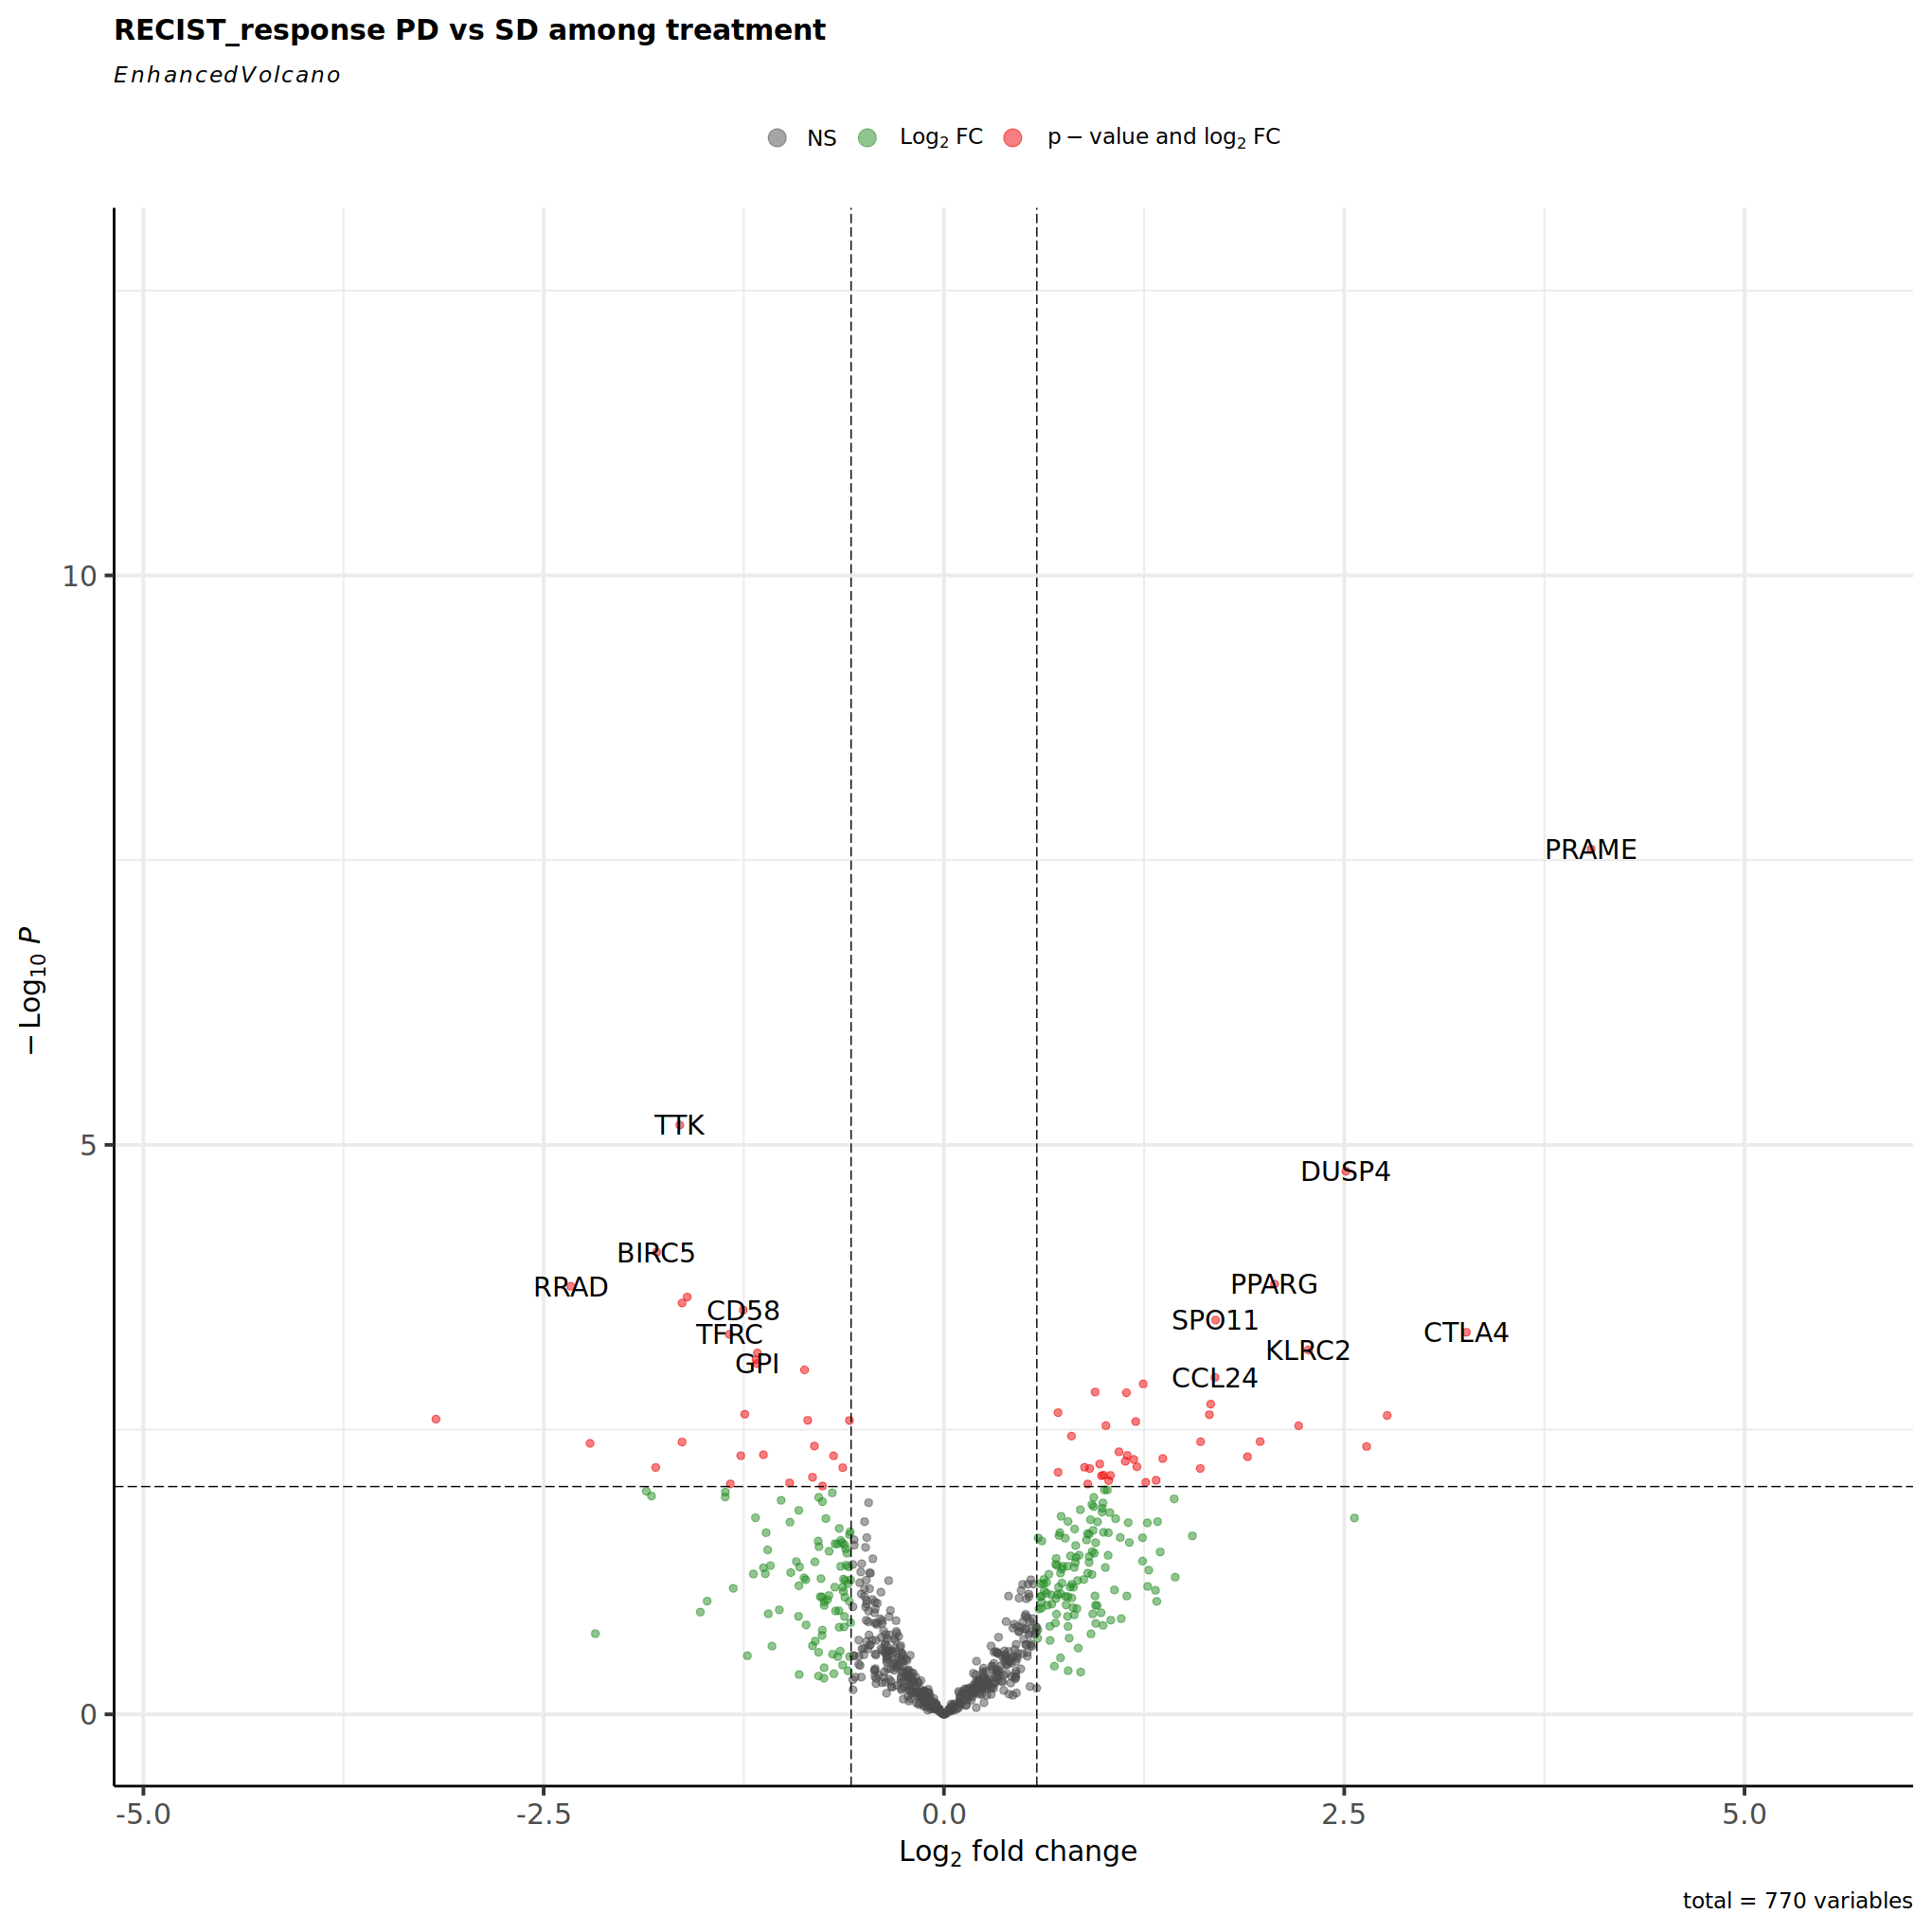

In [88]:
sdvspd_volplot6

In [89]:
ggsave("06_PD_vs_SD_volcano_plot_matched_id_treatment_only.pdf", 
       width = 10,
       height = 10, sdvspd_volplot6)

In [90]:
goi6_1 = c( 'DUSP4', 'PPARG', 'SPO11','CTLA4')
goi6_1

[1] "DUSP4" "PPARG" "SPO11" "CTLA4"

In [92]:
tcounts6_1 <- t(log2((counts(de_dds6[goi6_1, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(de_dds6), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi6_1)+1):ncol(.))

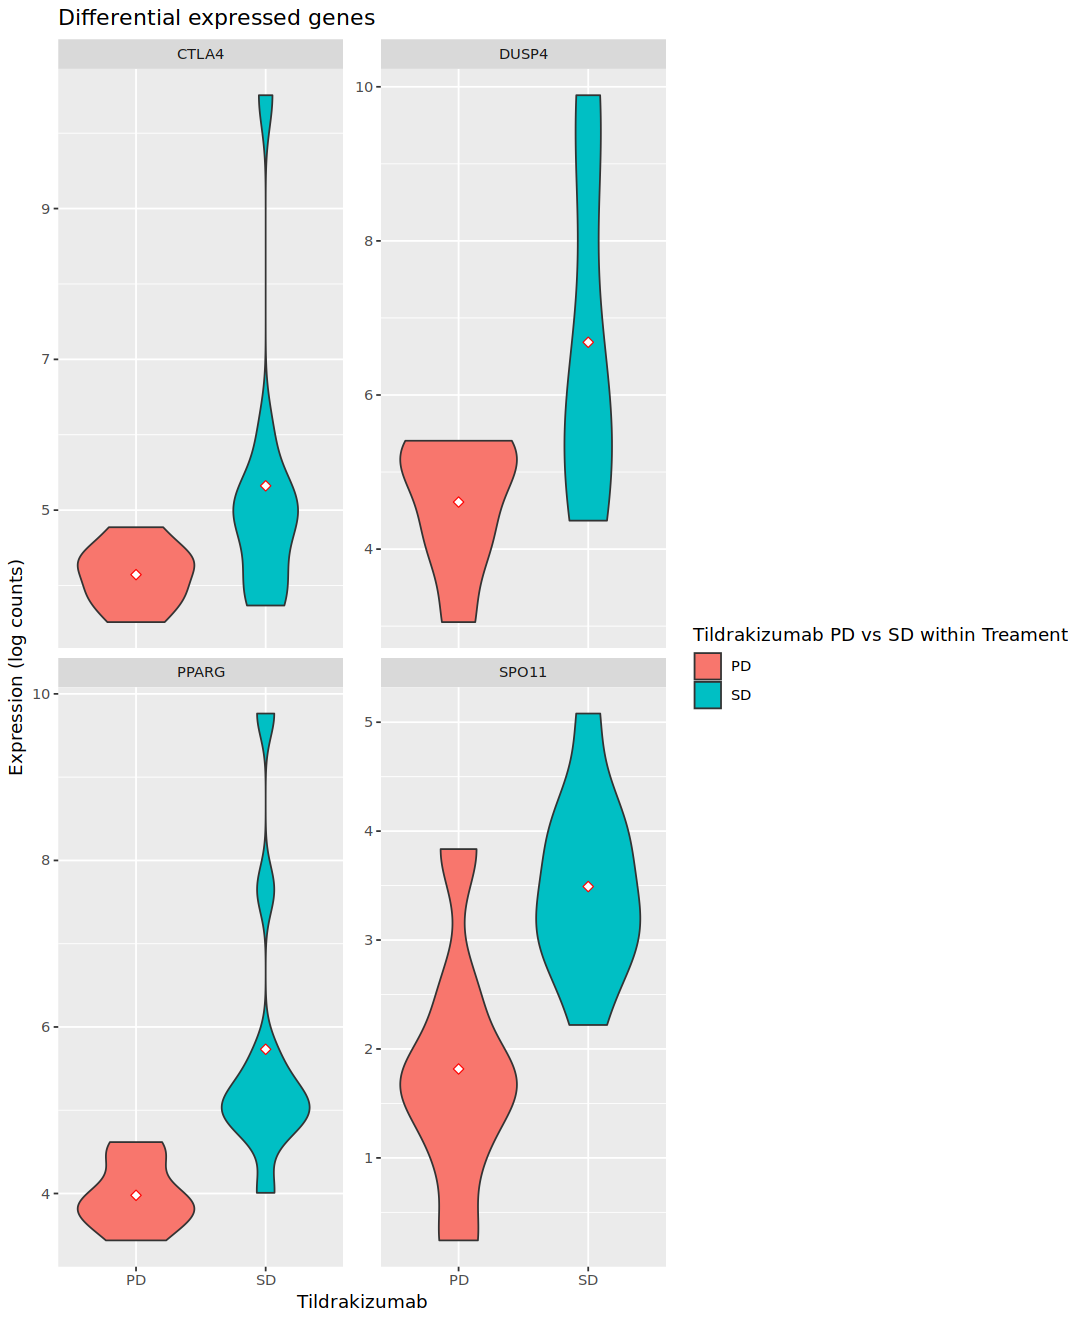

In [93]:
options(repr.plot.width=9, repr.plot.height=11)
# pdf("06_baseline_vs_treatment_violin_plot2.pdf")
sd_boxplot6 = ggplot(tcounts6_1, aes(RECIST_response, expression, fill=RECIST_response)) + 
  geom_violin() + 
  stat_summary(fun = mean, geom = "point", shape = 23, size = 2, color = "red", fill = "white") + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="Tildrakizumab PD vs SD within Treament", 
       title="Differential expressed genes")
# dev.off()
sd_boxplot6

In [94]:
ggsave("06_PD_vs_SD_violin_plot_matched_id_within_treatment.pdf", 
       width = 9,
       height = 10, sd_boxplot6)

In [95]:
norm_transform_dds6 <- normTransform(de_dds6)
norm_transform_dds6

class: DESeqTransform 
dim: 770 17 
metadata(1): version
assays(1): ''
rownames(770): A2M ABCB1 ... ZNF143 ZNF346
rowData names(26): baseMean baseVar ... deviance maxCooks
colnames(17): 20230707_210462871024_K1241-Tx_09.RCC
  20230707_210462871024_K1628-Tx_10.RCC ...
  20230707_210462901024_K4360-Tx_11.RCC
  20230707_210462901024_K4368-Tx_12.RCC
colData names(10): Conditions Diagnosis ... W_1 sizeFactor

In [96]:
sorted_top_de6 = top_de_genes6[order(top_de_genes6$up_in_PD==TRUE, top_de_genes6$padj),]

In [97]:
col_labels6 = as.data.frame(colData(de_dds6)[,c('pid',"Diagnosis",'Conditions',"RECIST_response")])
col_labels6

pid   Diagnosis  Conditions          
20230707_210462871024_K1241-Tx_09.RCC K1241  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K1628-Tx_10.RCC K1628  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K2032-Tx_11.RCC K2032  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K2360-Tx_12.RCC K2360  Treatment Soft Tissue Sarcoma 
20230707_210462871024_K853-Tx_08.RCC  K853   Treatment Osteosarcoma        
20230707_210462901024_K2742-Tx_01.RCC K2742  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K2849-Tx_02.RCC K2849  Treatment Osteosarcoma        
20230707_210462901024_K2894-Tx_03.RCC K2894  Treatment Osteosarcoma        
20230707_210462901024_K2917-Tx_04.RCC K2917  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K3056-Tx_05.RCC K3056  Treatment Osteosarcoma        
20230707_210462901024_K3566-Tx_06.RCC K3566  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K3953-Tx_07.RCC K3953  Treatment Soft Tissue Sarcoma 
20230707_210462901024_K3975-Tx_08.RCC K3975  Treatment Osteosarcoma        
20230707_210462901024_K4106-Tx_09.RCC K4106  Treatment Osteosarcoma        
20230707_210462901024_K4258-Tx_10.RCC K4258  Treatment Osteosarcoma        
20230707_210462901024_K4360-Tx_11.RCC K4360  Treatment Osteosarcoma        
20230707_210462901024_K4368-Tx_12.RCC K4368  Treatment Soft Tissue Sarcoma 
                                      RECIST_response
20230707_210462871024_K1241-Tx_09.RCC SD             
20230707_210462871024_K1628-Tx_10.RCC PD             
20230707_210462871024_K2032-Tx_11.RCC PD             
20230707_210462871024_K2360-Tx_12.RCC SD             
20230707_210462871024_K853-Tx_08.RCC  SD             
20230707_210462901024_K2742-Tx_01.RCC SD             
20230707_210462901024_K2849-Tx_02.RCC PD             
20230707_210462901024_K2894-Tx_03.RCC SD             
20230707_210462901024_K2917-Tx_04.RCC SD             
20230707_210462901024_K3056-Tx_05.RCC PD             
20230707_210462901024_K3566-Tx_06.RCC SD             
20230707_210462901024_K3953-Tx_07.RCC SD             
20230707_210462901024_K3975-Tx_08.RCC SD             
20230707_210462901024_K4106-Tx_09.RCC SD             
20230707_210462901024_K4258-Tx_10.RCC PD             
20230707_210462901024_K4360-Tx_11.RCC PD             
20230707_210462901024_K4368-Tx_12.RCC PD

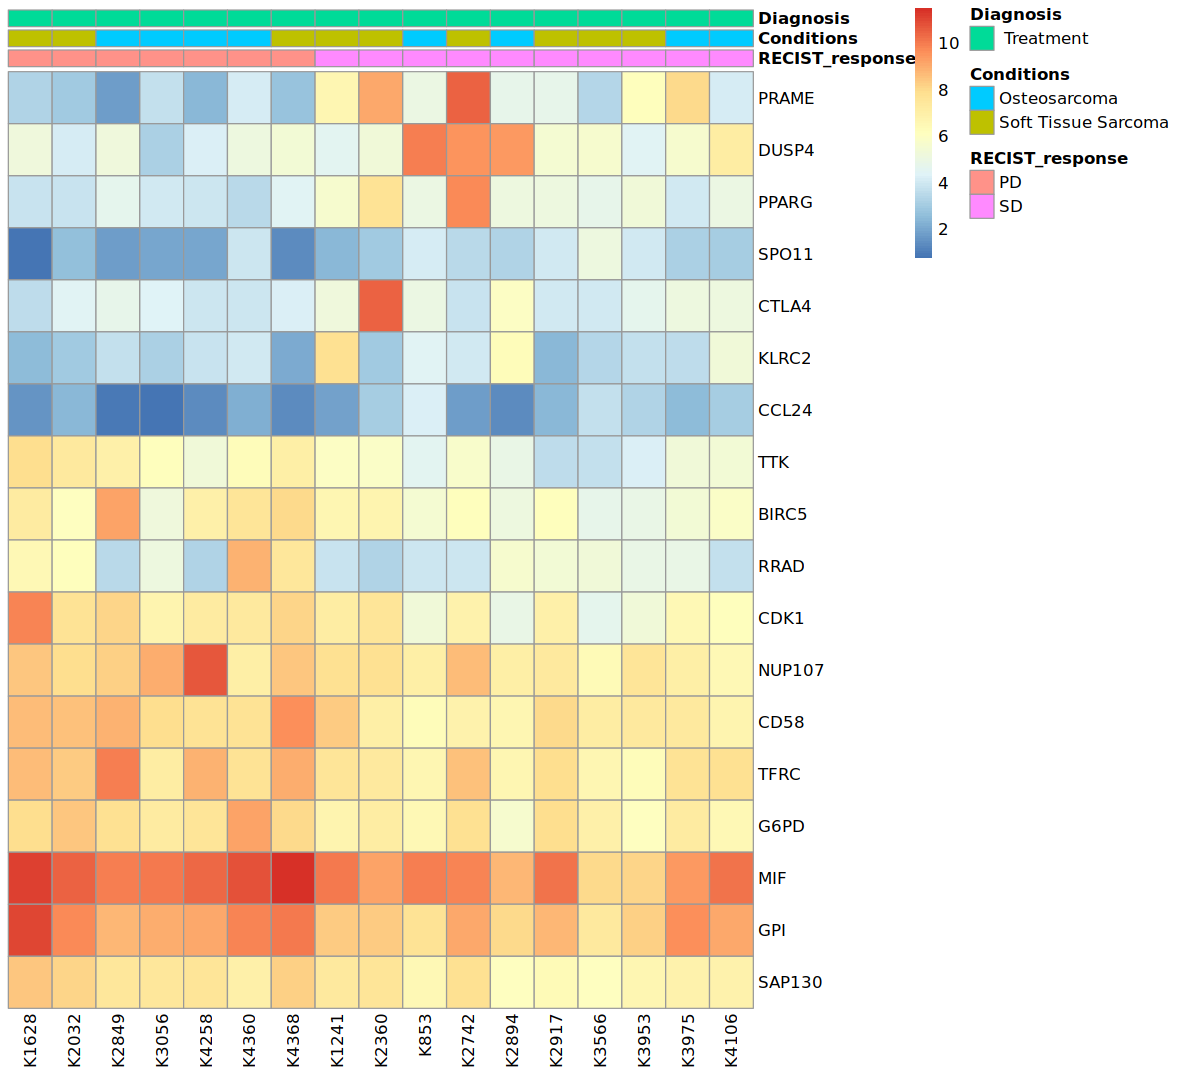

In [100]:
options(repr.plot.width=10, repr.plot.height=9)
# pdf("06_baseline_vs_treatment_heatmap.pdf")
# select <- order(rowMeans(counts(de_dds4,normalized=TRUE)),
#                 decreasing=TRUE)[1:15]
# print(select)
df <- as.data.frame(colData(de_dds6)[,c('pid',"Diagnosis",'Conditions',"RECIST_response")])



mt = assay(norm_transform_dds6)[row.names( sorted_top_de6),][1:18,]
# Get column names
column_names <- colnames(mt)

# Identify columns containing "B_" and "Tx_"
B_columns <- column_names[grepl("B_", column_names)]
Tx_columns <- column_names[grepl("Tx_", column_names)]
# print(B_columns)
# print(Tx_columns)
# Combine the column names with "B_" first and "Tx_" second
sorted_columns <- c(B_columns, Tx_columns)

# Reorder the dataframe with sorted column names
sorted_mt <- mt[, sorted_columns]
# row_names <- row.names(mt)
# pd_columns <- row.names[grepl("B_", column_names)]
# sd_columns <- row.names[grepl("Tx_", column_names)]
sorted_df = df[order(df$RECIST_response),]
# print(colnames(sorted_mt))
row.names(sorted_mt) <- row.names(sorted_top_de6)[1:18]
sorted_mt = sorted_mt[,row.names(sorted_df)]
# pheatmap(mt, cluster_rows=FALSE, show_rownames=FALSE,
#          cluster_cols=FALSE, annotation_col=df)
# genelist <- c('FOS','HLA-DMB' ,'HLA-DRA','IL24', 'EGR1','CTLA4','ARG1','AMBP') 
# Labels to plot
labels <- rownames(sorted_mt) 
# print(labels)
# Set the rest of genes to ""
# labels[!labels %in% genelist] <- "" 

heatmap6 <- pheatmap(sorted_mt, labels_row = labels, labels_col = sorted_df[,c('pid')],
         cluster_rows=FALSE, show_rownames=TRUE,clustering_distance_rows = "euclidean", 
          cluster_cols=FALSE, annotation_col=sorted_df[,c("RECIST_response","Conditions","Diagnosis")], angle_col=90)
# dev.off()

In [101]:
ggsave("06_PD_vs_SD_heatmap_matched_id_treatment_only.pdf", width = 10,
  height = 9, heatmap6)

In [58]:
norm_mean_w5

ERROR: Error in eval(expr, envir, enclos): object 'norm_mean_w5' not found


In [59]:
ilgrep= grep('IL2', row.names(counts(de_dds5)))
counts(de_dds5)[ilgrep,]

20230616_210462891024_K1241-B_02.RCC
IL2      4                                  
IL21     7                                  
IL21R    5                                  
IL22     2                                  
IL22RA1 13                                  
IL22RA2  7                                  
IL23A    5                                  
IL23R    3                                  
IL24     7                                  
IL25     3                                  
IL26     7                                  
IL27     1                                  
IL2RA    3                                  
IL2RB   12                                  
IL2RG    5                                  
        20230616_210462891024_K1628-B_03.RCC
IL2        1                                
IL21       7                                
IL21R      7                                
IL22      10                                
IL22RA1   28                                
IL22RA2   12                                
IL23A     18                                
IL23R     10                                
IL24    4635                                
IL25      10                                
IL26      13                                
IL27      13                                
IL2RA     42                                
IL2RB    179                                
IL2RG     74                                
        20230616_210462891024_K2032-B_05.RCC
IL2       1                                 
IL21      6                                 
IL21R    15                                 
IL22      4                                 
IL22RA1  24                                 
IL22RA2  15                                 
IL23A     6                                 
IL23R    11                                 
IL24      9                                 
IL25      6                                 
IL26     12                                 
IL27      4                                 
IL2RA    61                                 
IL2RB   100                                 
IL2RG    34                                 
        20230616_210462891024_K2360-B_08.RCC
IL2      5                                  
IL21     5                                  
IL21R   11                                  
IL22     2                                  
IL22RA1 20                                  
IL22RA2  9                                  
IL23A   14                                  
IL23R    4                                  
IL24    11                                  
IL25     9                                  
IL26    14                                  
IL27     5                                  
IL2RA   24                                  
IL2RB   78                                  
IL2RG   37                                  
        20230616_210462891024_K2742-B_11.RCC
IL2      4                                  
IL21     8                                  
IL21R    4                                  
IL22     3                                  
IL22RA1 19                                  
IL22RA2 15                                  
IL23A   14                                  
IL23R    9                                  
IL24    10                                  
IL25     4                                  
IL26    15                                  
IL27     7                                  
IL2RA   25                                  
IL2RB   25                                  
IL2RG   10                                  
        20230616_210462891024_K2849-B_12.RCC
IL2      4                                  
IL21     6                                  
IL21R   37                                  
IL22     6                                  
IL22RA1 32                                  
IL22RA2 13                                  
IL23A   14                                  
IL23R   10                                  
IL2

In [61]:
goiil23 = c( 'IL23A')
tcounts_il23 <- t(log2((counts(de_dds5[goiil23, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(de_dds5), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goiil23)+1):ncol(.))

In [64]:
log2((counts(de_dds5[goiil23, ], normalized=TRUE, replaced=FALSE)+.5))

20230616_210462891024_K1241-B_02.RCC 20230616_210462891024_K1628-B_03.RCC
IL23A 4.849169                             3.386717                            
      20230616_210462891024_K2032-B_05.RCC 20230616_210462891024_K2360-B_08.RCC
IL23A 2.190689                             3.993096                            
      20230616_210462891024_K2742-B_11.RCC 20230616_210462891024_K2849-B_12.RCC
IL23A 4.20595                              3.817626                            
      20230616_210462891024_K853-B_01.RCC 20230707_210462871024_K4106-B_01.RCC
IL23A 3.924521                            4.26808                             
      20230707_210462871024_K4258-B_03.RCC 20230707_210462871024_K4360-B_05.RCC
IL23A 4.083279                             3.804906                            
      20230707_210462871024_K4368-B_06.RCC 20230707_210462881024_K2894-B_01.RCC
IL23A 3.657267                             4.405571                            
      20230707_210462881024_K2917-B_02.RCC 20230707_210462881024_K3056-B_03.RCC
IL23A 5.050638                             3.804094                            
      20230707_210462881024_K3566-B_04.RCC 20230707_210462881024_K3953-B_06.RCC
IL23A 3.917102                             3.361804                            
      20230707_210462881024_K3975-B_07.RCC
IL23A 2.905569

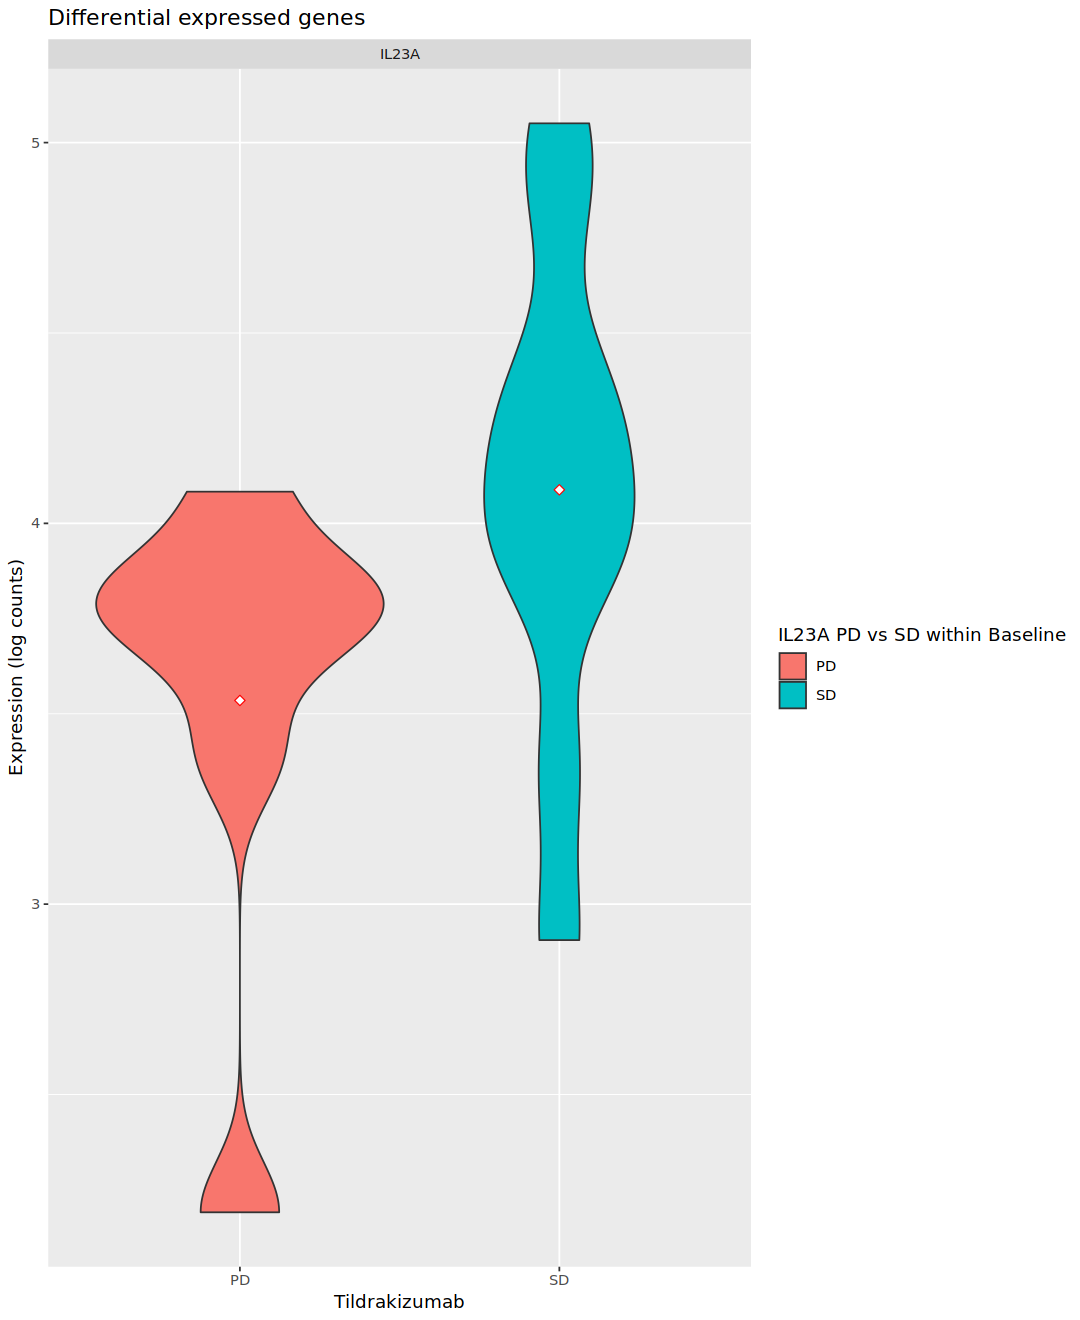

In [70]:
options(repr.plot.width=9, repr.plot.height=11)
# pdf("06_baseline_vs_treatment_violin_plot2.pdf")
sd_boxplot7 = ggplot(tcounts_il23, aes(RECIST_response, expression, fill=c(RECIST_response))) + 
  geom_violin() + 
  stat_summary(fun = mean, geom = "point", shape = 23, size = 2, color = "red", fill = "white") + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Tildrakizumab", 
       y="Expression (log counts)", 
       fill="IL23A PD vs SD within Baseline", 
       title="Differential expressed genes")
# dev.off()
sd_boxplot7

### Add the P-values to this plot

## split the violins in to Osteo vs ST-sarcoma

In [161]:
ggsave("06_IL23A_in_baseline_only.pdf", width = 9,
  height = 9, sd_boxplot7)